In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, SimpleRNN, BatchNormalization
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [8]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    rnn_1 = SimpleRNN(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = BatchNormalization()(rnn_1)
    rnn_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    rnn_1_droput = Dropout(0.3)(rnn_1_LRelu)
    rnn_2 = SimpleRNN(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal')(rnn_1_droput)
    batch_norm2 = BatchNormalization()(rnn_2)
    rnn_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    rnn_2_droput = Dropout(0.3)(rnn_2_LRelu)
    output_dense = Dense(n_features, activation=None)(rnn_2_droput)
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model

## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "AAPL"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10    0.910714    0.912946    0.845982    0.872768    0.742829   
6    2000-01-11    0.856585    0.887277    0.808036    0.828125    0.704832   
7    2000-01-12    0.848214    0.852679    0.772321    0.778460    0.662562   
8    2000-01-13    0.843610    0.881696    0.825893    0.863839    0.735229   
9    2000-01-14    0.892857    0.912946    0.887277    0.896763    0.763251   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  132.160004  132.429993  130.779999  130.960007  129.209259   
5279 2020-12-24  131.320007  133.460007  131.100006  131.970001  130.205795   
5280 2020-12-28  133.990005  137.339996  133.509995  136.690002  134.862686   
5281 2020-12-29  138.050003  138.789993  134.339996  134.869995  133.067017   
5282 2020-12-30  135.580002  135.990005  133.399994  133.720001  131.932373   

          Volume          Ma  
5      505064000    0.915960  
6      441548800    0.890625  
7      976068800    0.873214  
8     1032684800    0.843192  
9      390376000    0.846317  
...          ...         ...  
5278    88223700  128.656000  
5279    54930100  129.286002  
5280   124486200  129.940002  
5281   121047300  131.946002  
5282    96452100  133.274002  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 5, 10)             180       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                             

Time for epoch 54 is 0.6863465309143066 sec Generator Loss: 1.0578733682632446,  Discriminator_loss: 1.1504474878311157
Time for epoch 55 is 0.69482421875 sec Generator Loss: 1.0561312437057495,  Discriminator_loss: 1.151394009590149
Time for epoch 56 is 0.6901464462280273 sec Generator Loss: 1.0524145364761353,  Discriminator_loss: 1.1461983919143677
Time for epoch 57 is 0.7216360569000244 sec Generator Loss: 1.049389123916626,  Discriminator_loss: 1.173079013824463
Time for epoch 58 is 0.7056849002838135 sec Generator Loss: 1.0367566347122192,  Discriminator_loss: 1.1924645900726318
Time for epoch 59 is 0.7055258750915527 sec Generator Loss: 1.0289342403411865,  Discriminator_loss: 1.186624526977539
Time for epoch 60 is 0.7574071884155273 sec Generator Loss: 1.030329942703247,  Discriminator_loss: 1.1641080379486084
Time for epoch 61 is 0.7713935375213623 sec Generator Loss: 1.0170817375183105,  Discriminator_loss: 1.1777652502059937
Time for epoch 62 is 0.7147583961486816 sec Genera

Time for epoch 123 is 0.8688805103302002 sec Generator Loss: 0.9423192739486694,  Discriminator_loss: 1.242653250694275
Time for epoch 124 is 0.8734681606292725 sec Generator Loss: 0.9344325661659241,  Discriminator_loss: 1.242423176765442
Time for epoch 125 is 0.8688297271728516 sec Generator Loss: 0.9263535737991333,  Discriminator_loss: 1.2462632656097412
Time for epoch 126 is 0.7947001457214355 sec Generator Loss: 0.9302950501441956,  Discriminator_loss: 1.2489618062973022
Time for epoch 127 is 0.8263821601867676 sec Generator Loss: 0.9305741190910339,  Discriminator_loss: 1.2391152381896973
Time for epoch 128 is 0.7890827655792236 sec Generator Loss: 0.9344452023506165,  Discriminator_loss: 1.2497025728225708
Time for epoch 129 is 0.7589073181152344 sec Generator Loss: 0.9356520175933838,  Discriminator_loss: 1.2378488779067993
Time for epoch 130 is 0.7186183929443359 sec Generator Loss: 0.9300317764282227,  Discriminator_loss: 1.2384048700332642
Time for epoch 131 is 0.8311145305

Time for epoch 191 is 0.9302263259887695 sec Generator Loss: 0.910277783870697,  Discriminator_loss: 1.2707687616348267
Time for epoch 192 is 0.8263156414031982 sec Generator Loss: 0.9099031090736389,  Discriminator_loss: 1.248928189277649
Time for epoch 193 is 0.9323241710662842 sec Generator Loss: 0.9062164425849915,  Discriminator_loss: 1.2556387186050415
Time for epoch 194 is 0.9752020835876465 sec Generator Loss: 0.9122968912124634,  Discriminator_loss: 1.2580337524414062
Time for epoch 195 is 0.9216606616973877 sec Generator Loss: 0.912093460559845,  Discriminator_loss: 1.261991024017334
Time for epoch 196 is 0.8403909206390381 sec Generator Loss: 0.9108602404594421,  Discriminator_loss: 1.2609573602676392
Time for epoch 197 is 0.8690552711486816 sec Generator Loss: 0.9067025184631348,  Discriminator_loss: 1.2666170597076416
Time for epoch 198 is 0.7610421180725098 sec Generator Loss: 0.9098089337348938,  Discriminator_loss: 1.255676507949829
Time for epoch 199 is 0.7404117584228

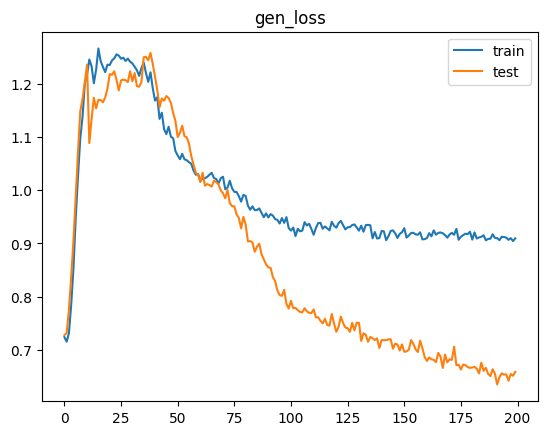

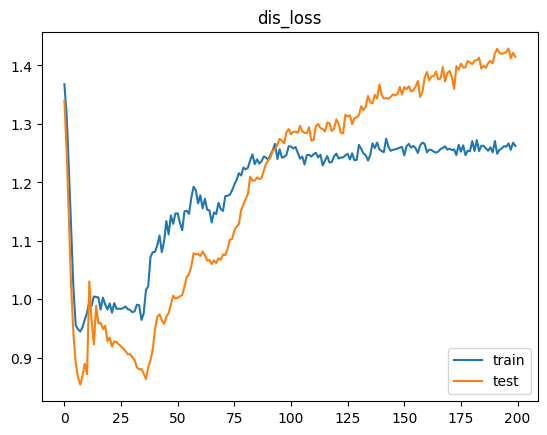

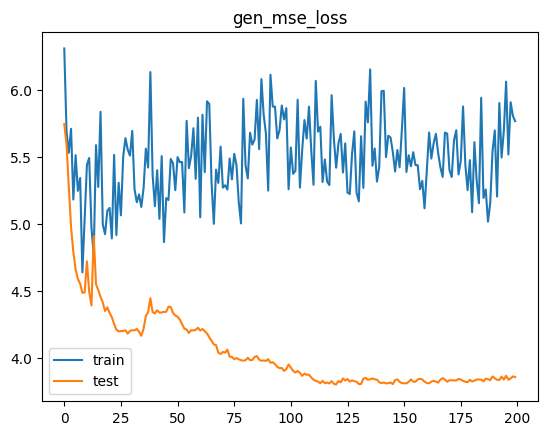

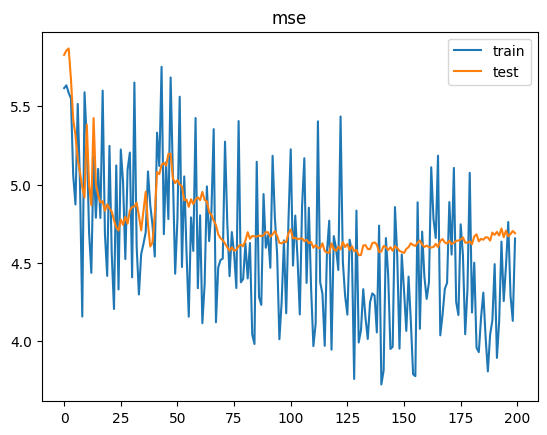

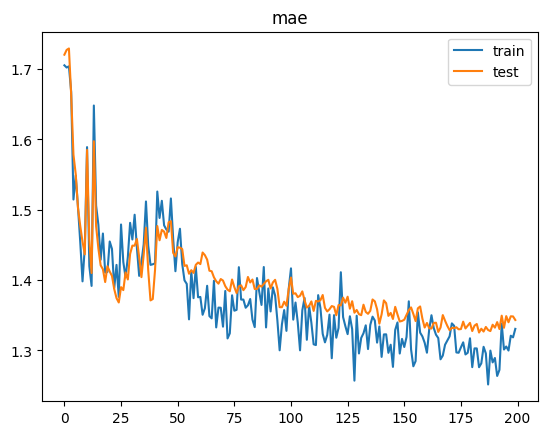

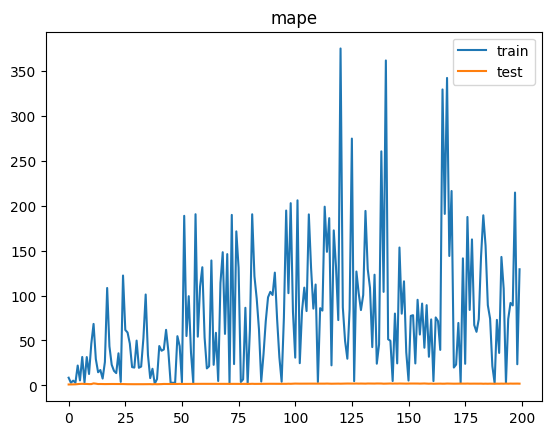

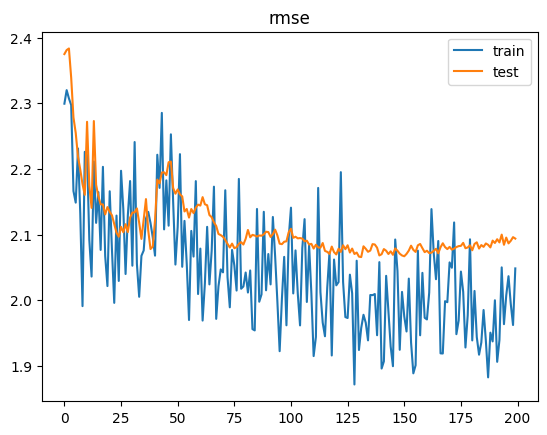

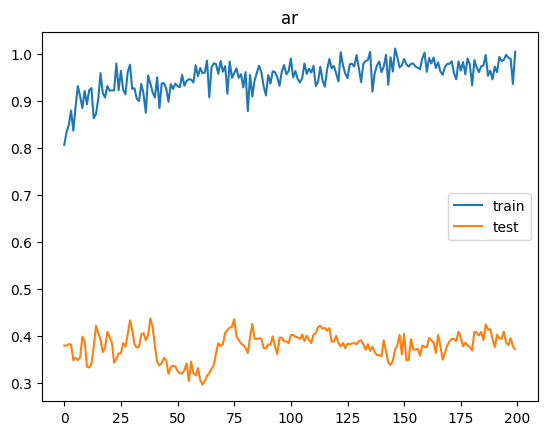

2/2 [==============================] - 0s 4ms/step


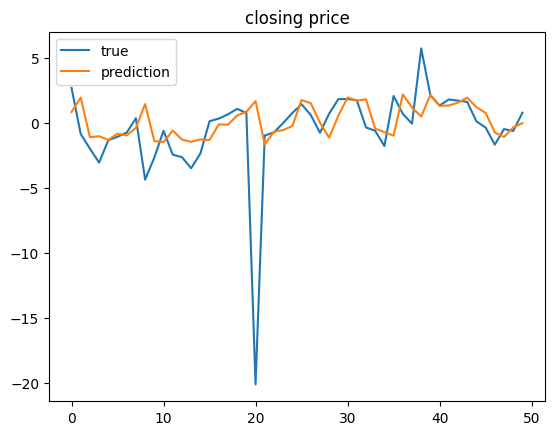

[MSE Baseline] train: 4.714236428266755  test: 4.679867713895856
Delta time with epochs = 200: 0:02:48.728050
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 simple_rnn_3 (

Time for epoch 53 is 0.7369880676269531 sec Generator Loss: 1.0669723749160767,  Discriminator_loss: 1.1662172079086304
Time for epoch 54 is 0.7051510810852051 sec Generator Loss: 1.057835578918457,  Discriminator_loss: 1.178747296333313
Time for epoch 55 is 0.7232875823974609 sec Generator Loss: 1.0441999435424805,  Discriminator_loss: 1.1869266033172607
Time for epoch 56 is 0.7498102188110352 sec Generator Loss: 1.0390625,  Discriminator_loss: 1.1827582120895386
Time for epoch 57 is 0.8698971271514893 sec Generator Loss: 1.0309163331985474,  Discriminator_loss: 1.1827493906021118
Time for epoch 58 is 0.7854914665222168 sec Generator Loss: 1.025886058807373,  Discriminator_loss: 1.1951183080673218
Time for epoch 59 is 0.737680196762085 sec Generator Loss: 1.0226597785949707,  Discriminator_loss: 1.2010581493377686
Time for epoch 60 is 0.7280879020690918 sec Generator Loss: 1.0321298837661743,  Discriminator_loss: 1.1960563659667969
Time for epoch 61 is 0.8060638904571533 sec Generator

Time for epoch 122 is 0.7505307197570801 sec Generator Loss: 0.9419528841972351,  Discriminator_loss: 1.2589244842529297
Time for epoch 123 is 0.7451341152191162 sec Generator Loss: 0.9371311664581299,  Discriminator_loss: 1.2611523866653442
Time for epoch 124 is 0.7341985702514648 sec Generator Loss: 0.9372817873954773,  Discriminator_loss: 1.2613704204559326
Time for epoch 125 is 0.760319709777832 sec Generator Loss: 0.9306224584579468,  Discriminator_loss: 1.2705804109573364
Time for epoch 126 is 0.7828285694122314 sec Generator Loss: 0.9466174840927124,  Discriminator_loss: 1.2535514831542969
Time for epoch 127 is 0.7324302196502686 sec Generator Loss: 0.9384977221488953,  Discriminator_loss: 1.2616173028945923
Time for epoch 128 is 0.7645747661590576 sec Generator Loss: 0.9432646632194519,  Discriminator_loss: 1.2504581212997437
Time for epoch 129 is 0.7537600994110107 sec Generator Loss: 0.9397507905960083,  Discriminator_loss: 1.2723462581634521
Time for epoch 130 is 0.741541147

Time for epoch 190 is 0.7923243045806885 sec Generator Loss: 0.9053874015808105,  Discriminator_loss: 1.2816628217697144
Time for epoch 191 is 0.7951211929321289 sec Generator Loss: 0.9203028678894043,  Discriminator_loss: 1.2555485963821411
Time for epoch 192 is 0.7845380306243896 sec Generator Loss: 0.9066701531410217,  Discriminator_loss: 1.2676912546157837
Time for epoch 193 is 0.800382137298584 sec Generator Loss: 0.9055002927780151,  Discriminator_loss: 1.2723004817962646
Time for epoch 194 is 0.7885985374450684 sec Generator Loss: 0.8996201157569885,  Discriminator_loss: 1.2720311880111694
Time for epoch 195 is 0.785862922668457 sec Generator Loss: 0.8933835029602051,  Discriminator_loss: 1.282228946685791
Time for epoch 196 is 0.7838788032531738 sec Generator Loss: 0.9172996282577515,  Discriminator_loss: 1.2631068229675293
Time for epoch 197 is 0.8589859008789062 sec Generator Loss: 0.9143002033233643,  Discriminator_loss: 1.2696082592010498
Time for epoch 198 is 0.77956652641

Time for epoch 258 is 0.786494255065918 sec Generator Loss: 0.879777729511261,  Discriminator_loss: 1.291597843170166
Time for epoch 259 is 0.793553352355957 sec Generator Loss: 0.890738308429718,  Discriminator_loss: 1.2871935367584229
Time for epoch 260 is 0.814194917678833 sec Generator Loss: 0.8945297598838806,  Discriminator_loss: 1.2874311208724976
Time for epoch 261 is 0.779911994934082 sec Generator Loss: 0.899365246295929,  Discriminator_loss: 1.28139066696167
Time for epoch 262 is 0.7892966270446777 sec Generator Loss: 0.8989769220352173,  Discriminator_loss: 1.2855111360549927
Time for epoch 263 is 0.802941083908081 sec Generator Loss: 0.8948105573654175,  Discriminator_loss: 1.2761470079421997
Time for epoch 264 is 0.7989263534545898 sec Generator Loss: 0.8796790838241577,  Discriminator_loss: 1.282039761543274
Time for epoch 265 is 0.7784850597381592 sec Generator Loss: 0.8938713073730469,  Discriminator_loss: 1.2845102548599243
Time for epoch 266 is 0.8194055557250977 sec

Time for epoch 326 is 0.6668362617492676 sec Generator Loss: 0.8998941779136658,  Discriminator_loss: 1.2724515199661255
Time for epoch 327 is 0.693497896194458 sec Generator Loss: 0.9011698961257935,  Discriminator_loss: 1.2818907499313354
Time for epoch 328 is 0.7401494979858398 sec Generator Loss: 0.9000410437583923,  Discriminator_loss: 1.279073715209961
Time for epoch 329 is 0.6782090663909912 sec Generator Loss: 0.9049865007400513,  Discriminator_loss: 1.2720448970794678
Time for epoch 330 is 0.7277927398681641 sec Generator Loss: 0.8988179564476013,  Discriminator_loss: 1.2775293588638306
Time for epoch 331 is 0.6924288272857666 sec Generator Loss: 0.8947380781173706,  Discriminator_loss: 1.2827355861663818
Time for epoch 332 is 0.689795732498169 sec Generator Loss: 0.9054333567619324,  Discriminator_loss: 1.277699589729309
Time for epoch 333 is 0.6706540584564209 sec Generator Loss: 0.9102806448936462,  Discriminator_loss: 1.279759168624878
Time for epoch 334 is 0.7830276489257

Time for epoch 394 is 0.6889560222625732 sec Generator Loss: 0.8935933709144592,  Discriminator_loss: 1.2786061763763428
Time for epoch 395 is 0.6870408058166504 sec Generator Loss: 0.8928024768829346,  Discriminator_loss: 1.2855563163757324
Time for epoch 396 is 0.691133975982666 sec Generator Loss: 0.8994253277778625,  Discriminator_loss: 1.283464789390564
Time for epoch 397 is 0.668013334274292 sec Generator Loss: 0.8893638849258423,  Discriminator_loss: 1.279768466949463
Time for epoch 398 is 0.6772336959838867 sec Generator Loss: 0.9064748287200928,  Discriminator_loss: 1.280857801437378
Time for epoch 399 is 0.677356481552124 sec Generator Loss: 0.9025880098342896,  Discriminator_loss: 1.284955620765686
Time for epoch 400 is 0.6947243213653564 sec Generator Loss: 0.9019443392753601,  Discriminator_loss: 1.2918204069137573
Time for epoch 401 is 0.7042183876037598 sec Generator Loss: 0.8971304297447205,  Discriminator_loss: 1.2799800634384155
Time for epoch 402 is 0.700254201889038

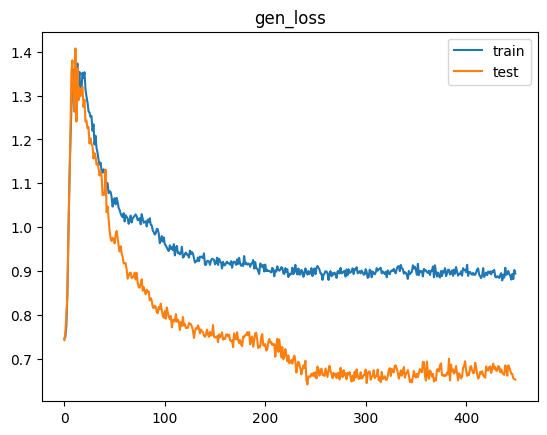

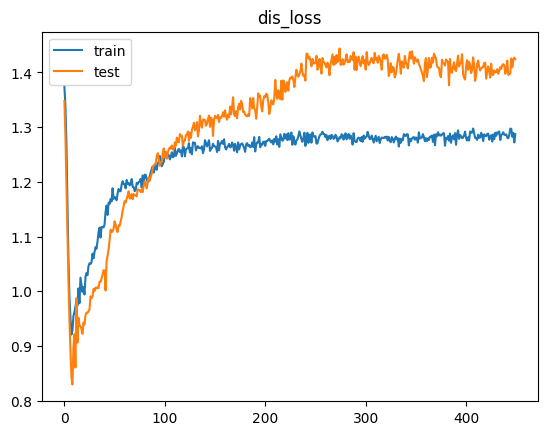

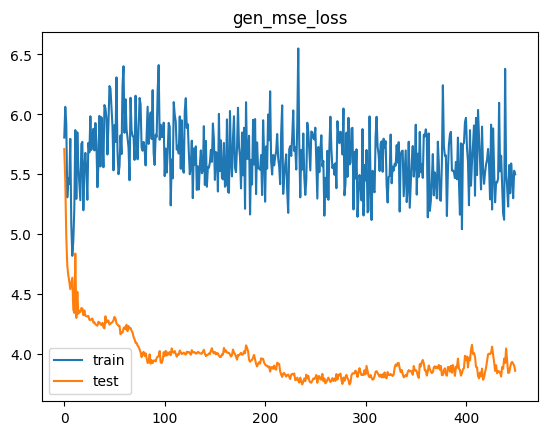

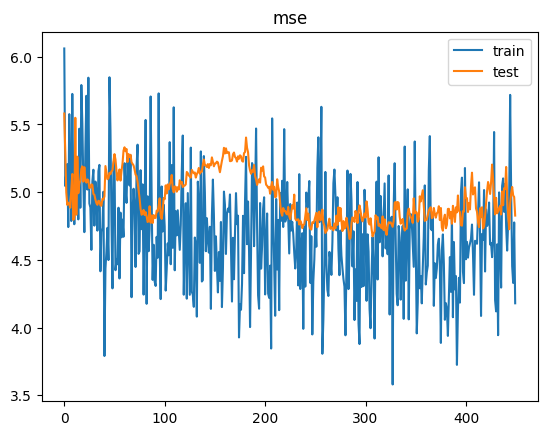

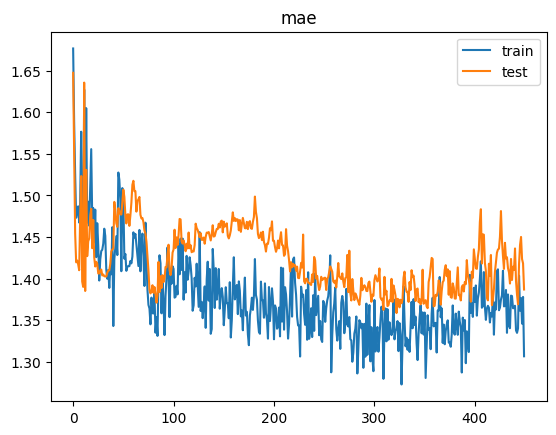

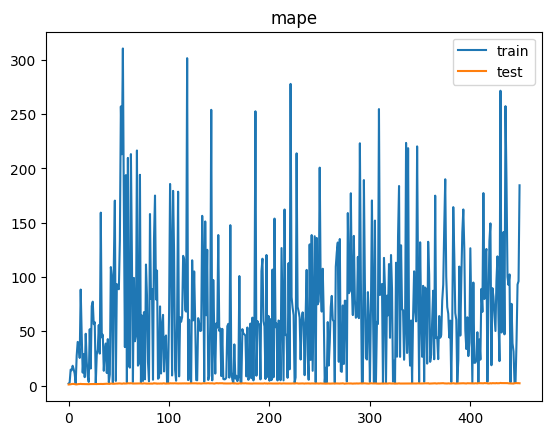

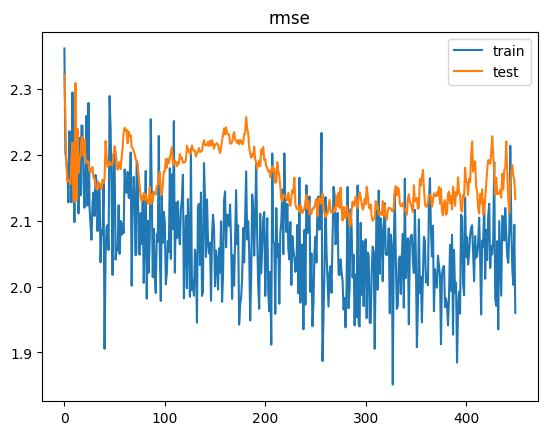

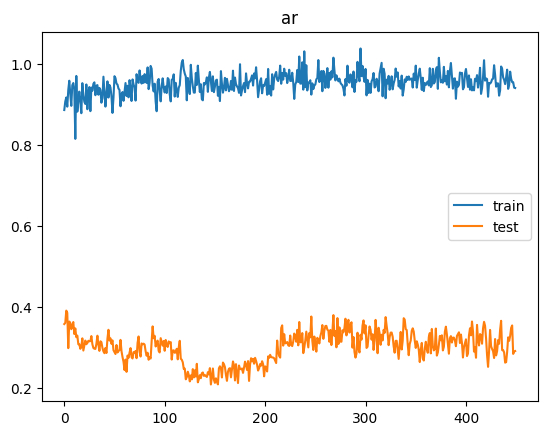

2/2 [==============================] - 0s 2ms/step


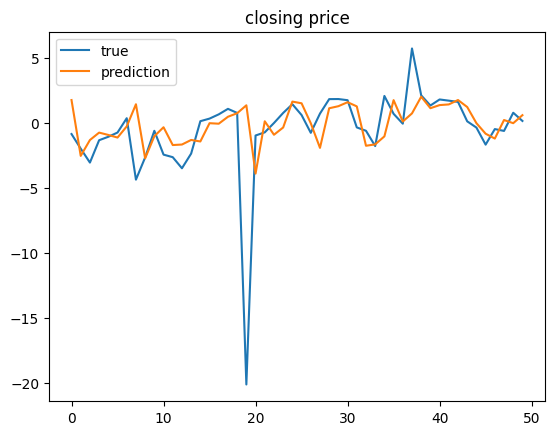

[MSE Baseline] train: 4.029718823388516  test: 4.6881765064049805
Delta time with epochs = 450: 0:05:47.332054
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_5 

Time for epoch 52 is 0.7381296157836914 sec Generator Loss: 1.0191210508346558,  Discriminator_loss: 1.2031127214431763
Time for epoch 53 is 0.7278916835784912 sec Generator Loss: 1.013654351234436,  Discriminator_loss: 1.1954811811447144
Time for epoch 54 is 0.7138805389404297 sec Generator Loss: 0.9991087913513184,  Discriminator_loss: 1.2027473449707031
Time for epoch 55 is 1.1861722469329834 sec Generator Loss: 0.9936620593070984,  Discriminator_loss: 1.2080332040786743
Time for epoch 56 is 0.7182633876800537 sec Generator Loss: 0.9889245629310608,  Discriminator_loss: 1.2150824069976807
Time for epoch 57 is 0.7374117374420166 sec Generator Loss: 1.0095016956329346,  Discriminator_loss: 1.2086310386657715
Time for epoch 58 is 0.7487194538116455 sec Generator Loss: 0.9960534572601318,  Discriminator_loss: 1.2154372930526733
Time for epoch 59 is 0.738018274307251 sec Generator Loss: 0.9972689747810364,  Discriminator_loss: 1.2028558254241943
Time for epoch 60 is 0.7101380825042725 se

Time for epoch 121 is 0.6741101741790771 sec Generator Loss: 0.8915759921073914,  Discriminator_loss: 1.2793394327163696
Time for epoch 122 is 0.7038693428039551 sec Generator Loss: 0.896304726600647,  Discriminator_loss: 1.2860523462295532
Time for epoch 123 is 0.7100784778594971 sec Generator Loss: 0.8906947374343872,  Discriminator_loss: 1.2907774448394775
Time for epoch 124 is 0.7005279064178467 sec Generator Loss: 0.8980321288108826,  Discriminator_loss: 1.2842539548873901
Time for epoch 125 is 0.6833813190460205 sec Generator Loss: 0.9016647338867188,  Discriminator_loss: 1.2819689512252808
Time for epoch 126 is 0.7150745391845703 sec Generator Loss: 0.8827530741691589,  Discriminator_loss: 1.2859712839126587
Time for epoch 127 is 0.6724448204040527 sec Generator Loss: 0.8776422739028931,  Discriminator_loss: 1.2944778203964233
Time for epoch 128 is 0.6804168224334717 sec Generator Loss: 0.8773154020309448,  Discriminator_loss: 1.28919517993927
Time for epoch 129 is 0.68491935729

Time for epoch 189 is 0.6918177604675293 sec Generator Loss: 0.8855386972427368,  Discriminator_loss: 1.2893786430358887
Time for epoch 190 is 0.7009835243225098 sec Generator Loss: 0.8776150345802307,  Discriminator_loss: 1.2886308431625366
Time for epoch 191 is 0.6740639209747314 sec Generator Loss: 0.8727458119392395,  Discriminator_loss: 1.2954380512237549
Time for epoch 192 is 0.6862664222717285 sec Generator Loss: 0.8661049008369446,  Discriminator_loss: 1.3051469326019287
Time for epoch 193 is 0.6799213886260986 sec Generator Loss: 0.8798083066940308,  Discriminator_loss: 1.2955518960952759
Time for epoch 194 is 0.7032127380371094 sec Generator Loss: 0.8687676191329956,  Discriminator_loss: 1.2987034320831299
Time for epoch 195 is 0.7046146392822266 sec Generator Loss: 0.8699253797531128,  Discriminator_loss: 1.299067735671997
Time for epoch 196 is 0.6903014183044434 sec Generator Loss: 0.8616517782211304,  Discriminator_loss: 1.3025630712509155
Time for epoch 197 is 0.689086437

Time for epoch 257 is 0.7422206401824951 sec Generator Loss: 0.8808309435844421,  Discriminator_loss: 1.2804880142211914
Time for epoch 258 is 0.7461519241333008 sec Generator Loss: 0.9005541801452637,  Discriminator_loss: 1.2732839584350586
Time for epoch 259 is 0.7641494274139404 sec Generator Loss: 0.8812655806541443,  Discriminator_loss: 1.2888585329055786
Time for epoch 260 is 0.7467374801635742 sec Generator Loss: 0.8854258060455322,  Discriminator_loss: 1.272631287574768
Time for epoch 261 is 0.7307984828948975 sec Generator Loss: 0.8887609839439392,  Discriminator_loss: 1.2843698263168335
Time for epoch 262 is 0.7221119403839111 sec Generator Loss: 0.8829620480537415,  Discriminator_loss: 1.29146146774292
Time for epoch 263 is 0.7220818996429443 sec Generator Loss: 0.9004144668579102,  Discriminator_loss: 1.2738115787506104
Time for epoch 264 is 0.7142231464385986 sec Generator Loss: 0.8990601897239685,  Discriminator_loss: 1.273512601852417
Time for epoch 265 is 0.755407810211

Time for epoch 326 is 0.7441833019256592 sec Generator Loss: 0.911405086517334,  Discriminator_loss: 1.2706763744354248
Time for epoch 327 is 0.725273609161377 sec Generator Loss: 0.910210907459259,  Discriminator_loss: 1.2651894092559814
Time for epoch 328 is 0.7257175445556641 sec Generator Loss: 0.9219415187835693,  Discriminator_loss: 1.2692830562591553
Time for epoch 329 is 0.7371418476104736 sec Generator Loss: 0.900541365146637,  Discriminator_loss: 1.2836378812789917
Time for epoch 330 is 0.742469072341919 sec Generator Loss: 0.9064972400665283,  Discriminator_loss: 1.2720447778701782
Time for epoch 331 is 0.7557730674743652 sec Generator Loss: 0.9250952005386353,  Discriminator_loss: 1.2645416259765625
Time for epoch 332 is 0.8140819072723389 sec Generator Loss: 0.9083340167999268,  Discriminator_loss: 1.2717193365097046
Time for epoch 333 is 0.7439854145050049 sec Generator Loss: 0.916282057762146,  Discriminator_loss: 1.2619088888168335
Time for epoch 334 is 0.73798608779907

Time for epoch 394 is 0.7466397285461426 sec Generator Loss: 0.9183323383331299,  Discriminator_loss: 1.2610297203063965
Time for epoch 395 is 0.7187366485595703 sec Generator Loss: 0.9446627497673035,  Discriminator_loss: 1.2405163049697876
Time for epoch 396 is 0.722405195236206 sec Generator Loss: 0.9353966116905212,  Discriminator_loss: 1.2529594898223877
Time for epoch 397 is 0.7135767936706543 sec Generator Loss: 0.9369425773620605,  Discriminator_loss: 1.2578809261322021
Time for epoch 398 is 0.7180254459381104 sec Generator Loss: 0.9484081268310547,  Discriminator_loss: 1.2557395696640015
Time for epoch 399 is 0.6954634189605713 sec Generator Loss: 0.9349494576454163,  Discriminator_loss: 1.2603099346160889
Time for epoch 400 is 0.7118303775787354 sec Generator Loss: 0.937815248966217,  Discriminator_loss: 1.2523376941680908
Time for epoch 401 is 0.7039194107055664 sec Generator Loss: 0.93659508228302,  Discriminator_loss: 1.254078984260559
Time for epoch 402 is 0.7076871395111

Time for epoch 462 is 0.7333614826202393 sec Generator Loss: 0.9372215867042542,  Discriminator_loss: 1.2501598596572876
Time for epoch 463 is 0.7403006553649902 sec Generator Loss: 0.9542794227600098,  Discriminator_loss: 1.2450401782989502
Time for epoch 464 is 0.7541160583496094 sec Generator Loss: 0.9563601016998291,  Discriminator_loss: 1.2414109706878662
Time for epoch 465 is 0.7205770015716553 sec Generator Loss: 0.9356904029846191,  Discriminator_loss: 1.2566817998886108
Time for epoch 466 is 0.7197773456573486 sec Generator Loss: 0.947983980178833,  Discriminator_loss: 1.2521321773529053
Time for epoch 467 is 0.7216463088989258 sec Generator Loss: 0.9454547762870789,  Discriminator_loss: 1.2476953268051147
Time for epoch 468 is 0.7742445468902588 sec Generator Loss: 0.9410972595214844,  Discriminator_loss: 1.2466075420379639
Time for epoch 469 is 0.7417995929718018 sec Generator Loss: 0.9398162364959717,  Discriminator_loss: 1.2418136596679688
Time for epoch 470 is 0.754962921

Time for epoch 531 is 0.729985237121582 sec Generator Loss: 0.9332520365715027,  Discriminator_loss: 1.2523611783981323
Time for epoch 532 is 0.7308547496795654 sec Generator Loss: 0.9431948661804199,  Discriminator_loss: 1.2567484378814697
Time for epoch 533 is 0.6944952011108398 sec Generator Loss: 0.9397577047348022,  Discriminator_loss: 1.251078486442566
Time for epoch 534 is 0.6940603256225586 sec Generator Loss: 0.9446795582771301,  Discriminator_loss: 1.2517919540405273
Time for epoch 535 is 0.7064647674560547 sec Generator Loss: 0.9301918148994446,  Discriminator_loss: 1.2512398958206177
Time for epoch 536 is 0.6913125514984131 sec Generator Loss: 0.9452566504478455,  Discriminator_loss: 1.2518163919448853
Time for epoch 537 is 0.7747135162353516 sec Generator Loss: 0.9342840909957886,  Discriminator_loss: 1.2537341117858887
Time for epoch 538 is 0.7287976741790771 sec Generator Loss: 0.9452389478683472,  Discriminator_loss: 1.2441891431808472
Time for epoch 539 is 0.7449839115

Time for epoch 599 is 0.7123570442199707 sec Generator Loss: 0.9384130239486694,  Discriminator_loss: 1.2511355876922607
Time for epoch 600 is 0.7235538959503174 sec Generator Loss: 0.9521178007125854,  Discriminator_loss: 1.246703863143921
Time for epoch 601 is 0.6964921951293945 sec Generator Loss: 0.9290080070495605,  Discriminator_loss: 1.2512028217315674
Time for epoch 602 is 0.6982159614562988 sec Generator Loss: 0.9439142942428589,  Discriminator_loss: 1.254132866859436
Time for epoch 603 is 0.7079145908355713 sec Generator Loss: 0.9452154636383057,  Discriminator_loss: 1.2575002908706665
Time for epoch 604 is 0.6973426342010498 sec Generator Loss: 0.9457563161849976,  Discriminator_loss: 1.2526664733886719
Time for epoch 605 is 0.7072279453277588 sec Generator Loss: 0.9442334771156311,  Discriminator_loss: 1.2411941289901733
Time for epoch 606 is 0.7001481056213379 sec Generator Loss: 0.9481431841850281,  Discriminator_loss: 1.2471349239349365
Time for epoch 607 is 0.7261712551

Time for epoch 668 is 0.7352595329284668 sec Generator Loss: 0.9578619599342346,  Discriminator_loss: 1.2436586618423462
Time for epoch 669 is 0.6992971897125244 sec Generator Loss: 0.9507561922073364,  Discriminator_loss: 1.2541370391845703
Time for epoch 670 is 0.6962411403656006 sec Generator Loss: 0.9396728873252869,  Discriminator_loss: 1.2541229724884033
Time for epoch 671 is 0.6889591217041016 sec Generator Loss: 0.9380951523780823,  Discriminator_loss: 1.2515475749969482
Time for epoch 672 is 0.6908681392669678 sec Generator Loss: 0.9524033069610596,  Discriminator_loss: 1.229909896850586
Time for epoch 673 is 0.7007124423980713 sec Generator Loss: 0.9490638971328735,  Discriminator_loss: 1.245444893836975
Time for epoch 674 is 0.7022073268890381 sec Generator Loss: 0.9538953304290771,  Discriminator_loss: 1.2463715076446533
Time for epoch 675 is 0.7443439960479736 sec Generator Loss: 0.9497774839401245,  Discriminator_loss: 1.250311017036438
Time for epoch 676 is 0.70370936393

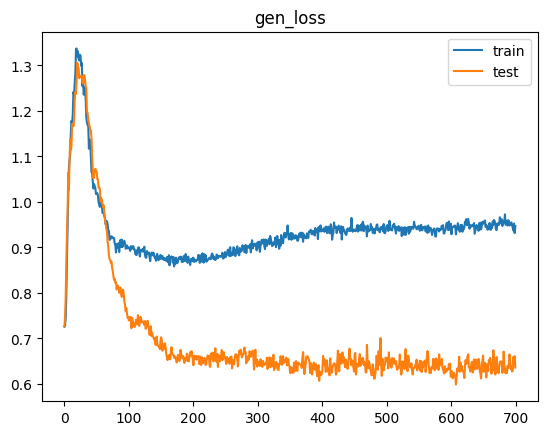

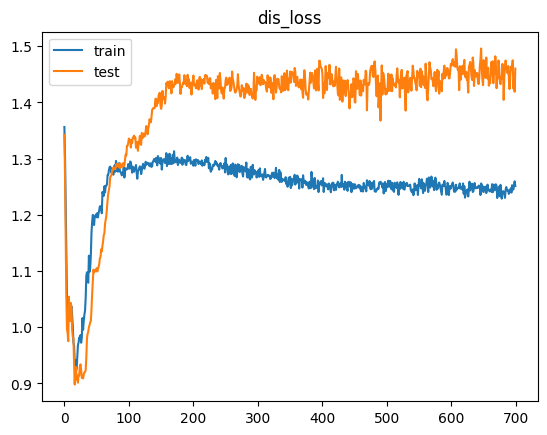

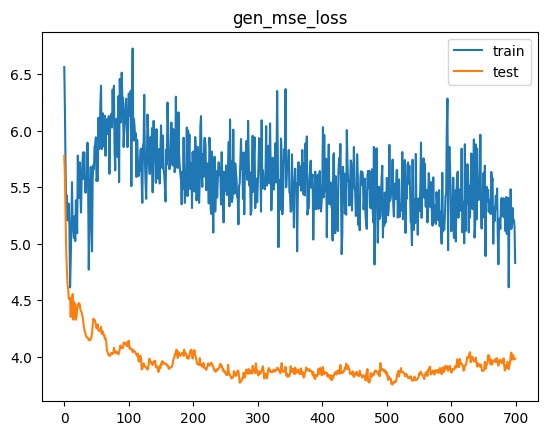

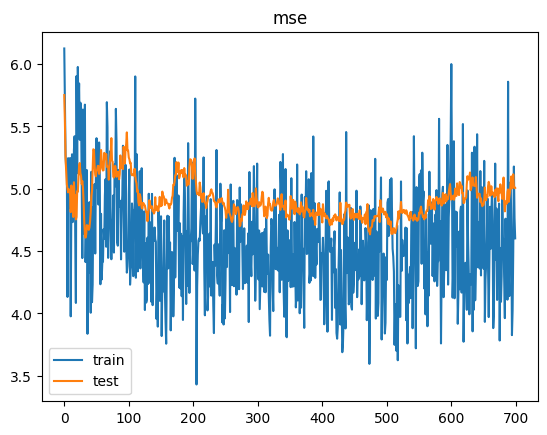

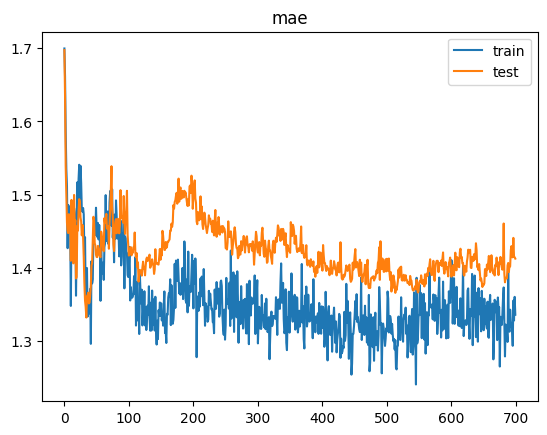

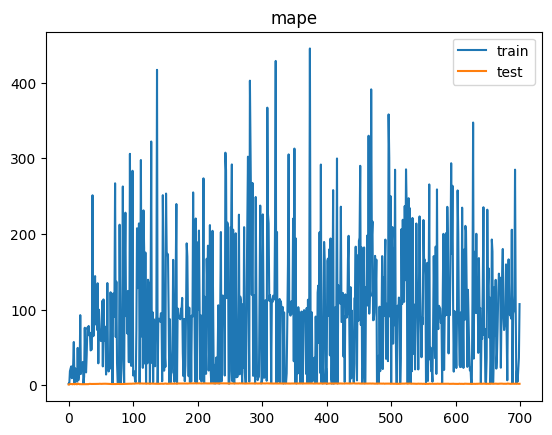

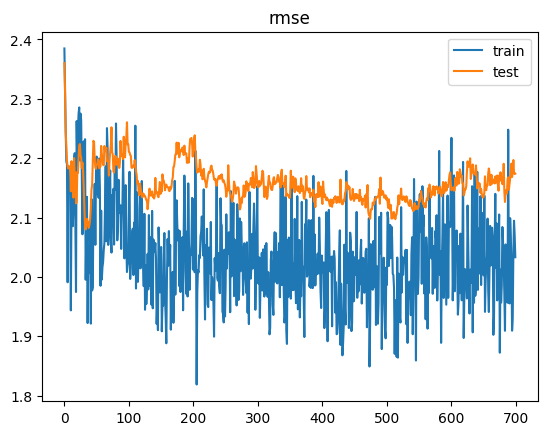

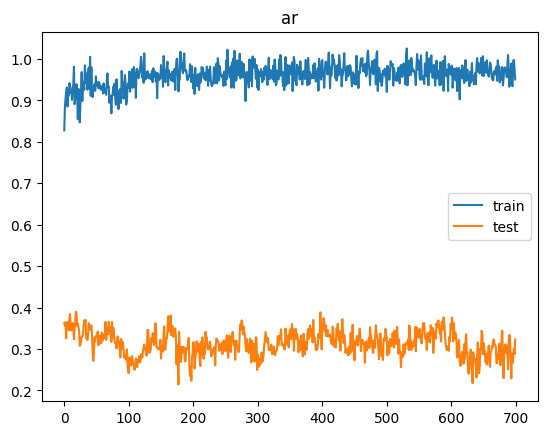

2/2 [==============================] - 0s 2ms/step


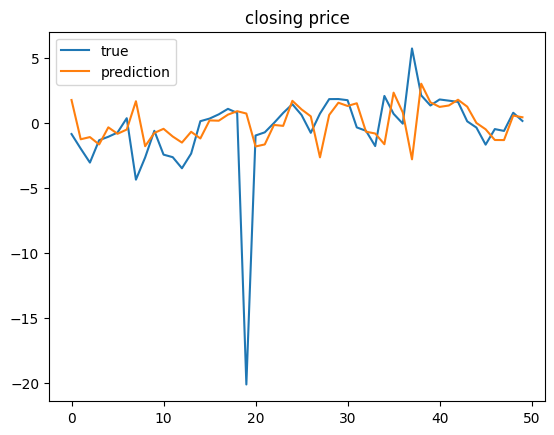

[MSE Baseline] train: 5.1695592779483475  test: 4.6881765064049805
Delta time with epochs = 700: 0:08:38.617343
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_7

Time for epoch 53 is 0.6974492073059082 sec Generator Loss: 1.0363887548446655,  Discriminator_loss: 1.1745339632034302
Time for epoch 54 is 0.7158970832824707 sec Generator Loss: 1.0498805046081543,  Discriminator_loss: 1.1764870882034302
Time for epoch 55 is 0.7128934860229492 sec Generator Loss: 1.0429843664169312,  Discriminator_loss: 1.191011667251587
Time for epoch 56 is 0.7008979320526123 sec Generator Loss: 1.049054741859436,  Discriminator_loss: 1.1766645908355713
Time for epoch 57 is 0.709453821182251 sec Generator Loss: 1.0316959619522095,  Discriminator_loss: 1.1938897371292114
Time for epoch 58 is 0.731755256652832 sec Generator Loss: 1.0196994543075562,  Discriminator_loss: 1.202478289604187
Time for epoch 59 is 0.7489314079284668 sec Generator Loss: 1.032709002494812,  Discriminator_loss: 1.1868007183074951
Time for epoch 60 is 0.7205162048339844 sec Generator Loss: 1.0257703065872192,  Discriminator_loss: 1.184737205505371
Time for epoch 61 is 0.7180063724517822 sec Gen

Time for epoch 122 is 0.7527346611022949 sec Generator Loss: 0.9285953044891357,  Discriminator_loss: 1.2574323415756226
Time for epoch 123 is 0.725654125213623 sec Generator Loss: 0.9155211448669434,  Discriminator_loss: 1.2781529426574707
Time for epoch 124 is 0.7115364074707031 sec Generator Loss: 0.9248965978622437,  Discriminator_loss: 1.2604622840881348
Time for epoch 125 is 0.7174434661865234 sec Generator Loss: 0.9257727265357971,  Discriminator_loss: 1.2537562847137451
Time for epoch 126 is 0.7320773601531982 sec Generator Loss: 0.9158790707588196,  Discriminator_loss: 1.2710949182510376
Time for epoch 127 is 0.7252249717712402 sec Generator Loss: 0.9231083393096924,  Discriminator_loss: 1.2726324796676636
Time for epoch 128 is 0.7012851238250732 sec Generator Loss: 0.9053307771682739,  Discriminator_loss: 1.267697811126709
Time for epoch 129 is 0.704728364944458 sec Generator Loss: 0.9163034558296204,  Discriminator_loss: 1.258225440979004
Time for epoch 130 is 0.711897134780

Time for epoch 190 is 0.7103662490844727 sec Generator Loss: 0.9035948514938354,  Discriminator_loss: 1.274429440498352
Time for epoch 191 is 0.7042789459228516 sec Generator Loss: 0.9072023034095764,  Discriminator_loss: 1.2641128301620483
Time for epoch 192 is 0.7001569271087646 sec Generator Loss: 0.897956907749176,  Discriminator_loss: 1.2824681997299194
Time for epoch 193 is 0.713263750076294 sec Generator Loss: 0.9001645445823669,  Discriminator_loss: 1.2719563245773315
Time for epoch 194 is 0.7120487689971924 sec Generator Loss: 0.9017450213432312,  Discriminator_loss: 1.273849368095398
Time for epoch 195 is 0.7083530426025391 sec Generator Loss: 0.9061275124549866,  Discriminator_loss: 1.2683683633804321
Time for epoch 196 is 0.794764518737793 sec Generator Loss: 0.8894597887992859,  Discriminator_loss: 1.284434199333191
Time for epoch 197 is 0.7210969924926758 sec Generator Loss: 0.8937670588493347,  Discriminator_loss: 1.2772377729415894
Time for epoch 198 is 0.70693635940551

Time for epoch 259 is 0.7127916812896729 sec Generator Loss: 0.87850421667099,  Discriminator_loss: 1.2895115613937378
Time for epoch 260 is 0.7210626602172852 sec Generator Loss: 0.8897937536239624,  Discriminator_loss: 1.2796077728271484
Time for epoch 261 is 0.7470426559448242 sec Generator Loss: 0.884621798992157,  Discriminator_loss: 1.275868535041809
Time for epoch 262 is 0.7629408836364746 sec Generator Loss: 0.8889645338058472,  Discriminator_loss: 1.2852704524993896
Time for epoch 263 is 0.7189779281616211 sec Generator Loss: 0.8787805438041687,  Discriminator_loss: 1.2912461757659912
Time for epoch 264 is 0.7096676826477051 sec Generator Loss: 0.8821160197257996,  Discriminator_loss: 1.289933681488037
Time for epoch 265 is 0.7169015407562256 sec Generator Loss: 0.8789675235748291,  Discriminator_loss: 1.2853028774261475
Time for epoch 266 is 0.7135868072509766 sec Generator Loss: 0.8758221864700317,  Discriminator_loss: 1.2976806163787842
Time for epoch 267 is 0.7127377986907

Time for epoch 328 is 0.7615714073181152 sec Generator Loss: 0.881801962852478,  Discriminator_loss: 1.291407823562622
Time for epoch 329 is 0.753920316696167 sec Generator Loss: 0.901687741279602,  Discriminator_loss: 1.2683911323547363
Time for epoch 330 is 0.7840554714202881 sec Generator Loss: 0.8867321610450745,  Discriminator_loss: 1.2789461612701416
Time for epoch 331 is 0.7767865657806396 sec Generator Loss: 0.8956640958786011,  Discriminator_loss: 1.2917898893356323
Time for epoch 332 is 0.7541384696960449 sec Generator Loss: 0.8934495449066162,  Discriminator_loss: 1.289465308189392
Time for epoch 333 is 0.755791187286377 sec Generator Loss: 0.8962699174880981,  Discriminator_loss: 1.290773868560791
Time for epoch 334 is 0.7631855010986328 sec Generator Loss: 0.8882190585136414,  Discriminator_loss: 1.2827450037002563
Time for epoch 335 is 0.7673134803771973 sec Generator Loss: 0.8930453658103943,  Discriminator_loss: 1.2886285781860352
Time for epoch 336 is 0.788301706314086

Time for epoch 396 is 0.7063188552856445 sec Generator Loss: 0.8885271549224854,  Discriminator_loss: 1.2907752990722656
Time for epoch 397 is 0.7375423908233643 sec Generator Loss: 0.885577380657196,  Discriminator_loss: 1.2866116762161255
Time for epoch 398 is 0.7707400321960449 sec Generator Loss: 0.8982247114181519,  Discriminator_loss: 1.2786998748779297
Time for epoch 399 is 0.7483780384063721 sec Generator Loss: 0.9019418954849243,  Discriminator_loss: 1.290535569190979
Time for epoch 400 is 0.7424135208129883 sec Generator Loss: 0.8860996961593628,  Discriminator_loss: 1.2872657775878906
Time for epoch 401 is 0.7427823543548584 sec Generator Loss: 0.8995762467384338,  Discriminator_loss: 1.2815624475479126
Time for epoch 402 is 0.7699453830718994 sec Generator Loss: 0.8981346487998962,  Discriminator_loss: 1.2755696773529053
Time for epoch 403 is 0.7491481304168701 sec Generator Loss: 0.8961731195449829,  Discriminator_loss: 1.2715048789978027
Time for epoch 404 is 0.7781260013

Time for epoch 464 is 0.7220911979675293 sec Generator Loss: 0.8886361718177795,  Discriminator_loss: 1.2928000688552856
Time for epoch 465 is 0.7523598670959473 sec Generator Loss: 0.886640191078186,  Discriminator_loss: 1.287722110748291
Time for epoch 466 is 0.734839677810669 sec Generator Loss: 0.9049993753433228,  Discriminator_loss: 1.2788069248199463
Time for epoch 467 is 0.7128217220306396 sec Generator Loss: 0.8861239552497864,  Discriminator_loss: 1.297532081604004
Time for epoch 468 is 0.7199220657348633 sec Generator Loss: 0.8862236142158508,  Discriminator_loss: 1.2893720865249634
Time for epoch 469 is 0.7410111427307129 sec Generator Loss: 0.8854895830154419,  Discriminator_loss: 1.295097827911377
Time for epoch 470 is 0.7191271781921387 sec Generator Loss: 0.9093387722969055,  Discriminator_loss: 1.2926501035690308
Time for epoch 471 is 0.7176930904388428 sec Generator Loss: 0.8765401840209961,  Discriminator_loss: 1.2968370914459229
Time for epoch 472 is 0.7465975284576

Time for epoch 533 is 0.7548749446868896 sec Generator Loss: 0.890487015247345,  Discriminator_loss: 1.2974566221237183
Time for epoch 534 is 0.7153592109680176 sec Generator Loss: 0.8980237245559692,  Discriminator_loss: 1.2826690673828125
Time for epoch 535 is 0.7137770652770996 sec Generator Loss: 0.8846383690834045,  Discriminator_loss: 1.2978744506835938
Time for epoch 536 is 0.7161927223205566 sec Generator Loss: 0.8768335580825806,  Discriminator_loss: 1.2930923700332642
Time for epoch 537 is 0.7394199371337891 sec Generator Loss: 0.8844788670539856,  Discriminator_loss: 1.3004666566848755
Time for epoch 538 is 0.7223165035247803 sec Generator Loss: 0.8846908211708069,  Discriminator_loss: 1.2887459993362427
Time for epoch 539 is 0.7453258037567139 sec Generator Loss: 0.8941917419433594,  Discriminator_loss: 1.2813901901245117
Time for epoch 540 is 0.7350528240203857 sec Generator Loss: 0.8889428377151489,  Discriminator_loss: 1.288806676864624
Time for epoch 541 is 0.7105627059

Time for epoch 601 is 0.7317118644714355 sec Generator Loss: 0.9135711789131165,  Discriminator_loss: 1.2784417867660522
Time for epoch 602 is 0.7321901321411133 sec Generator Loss: 0.8935137987136841,  Discriminator_loss: 1.2809383869171143
Time for epoch 603 is 0.7116968631744385 sec Generator Loss: 0.8955291509628296,  Discriminator_loss: 1.2805657386779785
Time for epoch 604 is 0.7195653915405273 sec Generator Loss: 0.9096980690956116,  Discriminator_loss: 1.2741259336471558
Time for epoch 605 is 0.7136821746826172 sec Generator Loss: 0.8966208696365356,  Discriminator_loss: 1.2874373197555542
Time for epoch 606 is 0.7319223880767822 sec Generator Loss: 0.915337085723877,  Discriminator_loss: 1.2789901494979858
Time for epoch 607 is 0.7385306358337402 sec Generator Loss: 0.9112498164176941,  Discriminator_loss: 1.285765290260315
Time for epoch 608 is 0.7263987064361572 sec Generator Loss: 0.9032959938049316,  Discriminator_loss: 1.2807854413986206
Time for epoch 609 is 0.7177045345

Time for epoch 670 is 0.7379679679870605 sec Generator Loss: 0.9268178939819336,  Discriminator_loss: 1.2711002826690674
Time for epoch 671 is 0.7187516689300537 sec Generator Loss: 0.9286493062973022,  Discriminator_loss: 1.276162028312683
Time for epoch 672 is 0.7358026504516602 sec Generator Loss: 0.9094086289405823,  Discriminator_loss: 1.2796273231506348
Time for epoch 673 is 0.7457692623138428 sec Generator Loss: 0.9249523282051086,  Discriminator_loss: 1.2679752111434937
Time for epoch 674 is 0.7336623668670654 sec Generator Loss: 0.8983535170555115,  Discriminator_loss: 1.2855510711669922
Time for epoch 675 is 0.7228126525878906 sec Generator Loss: 0.9063137173652649,  Discriminator_loss: 1.2721933126449585
Time for epoch 676 is 0.7262043952941895 sec Generator Loss: 0.9169243574142456,  Discriminator_loss: 1.2738343477249146
Time for epoch 677 is 0.7474403381347656 sec Generator Loss: 0.9110174775123596,  Discriminator_loss: 1.2734745740890503
Time for epoch 678 is 0.716984510

Time for epoch 738 is 0.7639200687408447 sec Generator Loss: 0.9344373941421509,  Discriminator_loss: 1.26664137840271
Time for epoch 739 is 0.7828946113586426 sec Generator Loss: 0.9451537728309631,  Discriminator_loss: 1.2656711339950562
Time for epoch 740 is 0.8098127841949463 sec Generator Loss: 0.9240517020225525,  Discriminator_loss: 1.2692676782608032
Time for epoch 741 is 0.8149359226226807 sec Generator Loss: 0.9167317152023315,  Discriminator_loss: 1.2759723663330078
Time for epoch 742 is 0.820037841796875 sec Generator Loss: 0.918394923210144,  Discriminator_loss: 1.2740113735198975
Time for epoch 743 is 0.7910406589508057 sec Generator Loss: 0.9357054233551025,  Discriminator_loss: 1.2646045684814453
Time for epoch 744 is 0.7826995849609375 sec Generator Loss: 0.9236727952957153,  Discriminator_loss: 1.2742502689361572
Time for epoch 745 is 0.73382568359375 sec Generator Loss: 0.9342323541641235,  Discriminator_loss: 1.2620413303375244
Time for epoch 746 is 0.74378824234008

Time for epoch 806 is 0.8006751537322998 sec Generator Loss: 0.939706563949585,  Discriminator_loss: 1.2557140588760376
Time for epoch 807 is 0.7845444679260254 sec Generator Loss: 0.9379320740699768,  Discriminator_loss: 1.260303258895874
Time for epoch 808 is 0.7651019096374512 sec Generator Loss: 0.9390511512756348,  Discriminator_loss: 1.2591344118118286
Time for epoch 809 is 0.8159916400909424 sec Generator Loss: 0.948158323764801,  Discriminator_loss: 1.2582690715789795
Time for epoch 810 is 0.8470406532287598 sec Generator Loss: 0.9419677257537842,  Discriminator_loss: 1.2565536499023438
Time for epoch 811 is 0.8770196437835693 sec Generator Loss: 0.9428802728652954,  Discriminator_loss: 1.2576786279678345
Time for epoch 812 is 0.7962062358856201 sec Generator Loss: 0.9328726530075073,  Discriminator_loss: 1.2745622396469116
Time for epoch 813 is 0.9361395835876465 sec Generator Loss: 0.9360007643699646,  Discriminator_loss: 1.2558027505874634
Time for epoch 814 is 0.83449578285

Time for epoch 875 is 0.8380029201507568 sec Generator Loss: 0.9524208903312683,  Discriminator_loss: 1.2523685693740845
Time for epoch 876 is 0.8287487030029297 sec Generator Loss: 0.9558326005935669,  Discriminator_loss: 1.2478985786437988
Time for epoch 877 is 0.8622534275054932 sec Generator Loss: 0.9341242909431458,  Discriminator_loss: 1.2620824575424194
Time for epoch 878 is 0.8527891635894775 sec Generator Loss: 0.9476677775382996,  Discriminator_loss: 1.248842716217041
Time for epoch 879 is 0.8449432849884033 sec Generator Loss: 0.9384878277778625,  Discriminator_loss: 1.2674793004989624
Time for epoch 880 is 0.8131029605865479 sec Generator Loss: 0.9455925226211548,  Discriminator_loss: 1.252571702003479
Time for epoch 881 is 0.8429622650146484 sec Generator Loss: 0.9439862966537476,  Discriminator_loss: 1.250337839126587
Time for epoch 882 is 0.8335485458374023 sec Generator Loss: 0.9519819021224976,  Discriminator_loss: 1.252651572227478
Time for epoch 883 is 0.838957071304

Time for epoch 943 is 0.9035077095031738 sec Generator Loss: 0.9719239473342896,  Discriminator_loss: 1.2497227191925049
Time for epoch 944 is 0.8322341442108154 sec Generator Loss: 0.9701178073883057,  Discriminator_loss: 1.2394318580627441
Time for epoch 945 is 0.9267213344573975 sec Generator Loss: 0.9552246332168579,  Discriminator_loss: 1.2476412057876587
Time for epoch 946 is 0.8426775932312012 sec Generator Loss: 0.9728811383247375,  Discriminator_loss: 1.2410293817520142
Time for epoch 947 is 0.8606405258178711 sec Generator Loss: 0.9614988565444946,  Discriminator_loss: 1.2440235614776611
Time for epoch 948 is 0.813319206237793 sec Generator Loss: 0.9613738656044006,  Discriminator_loss: 1.2527180910110474
Time for epoch 949 is 0.8522868156433105 sec Generator Loss: 0.9747249484062195,  Discriminator_loss: 1.2391701936721802
Time for epoch 950 is 0.8541367053985596 sec Generator Loss: 0.9672554135322571,  Discriminator_loss: 1.2362241744995117


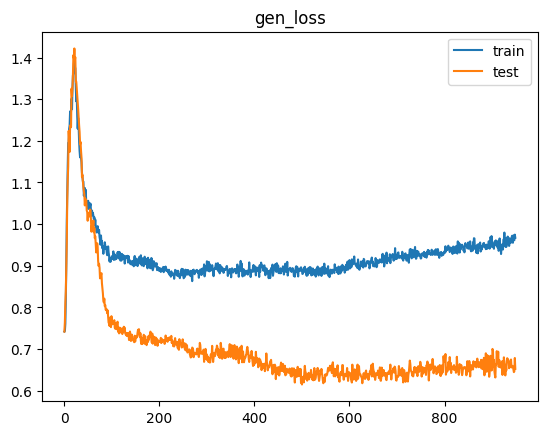

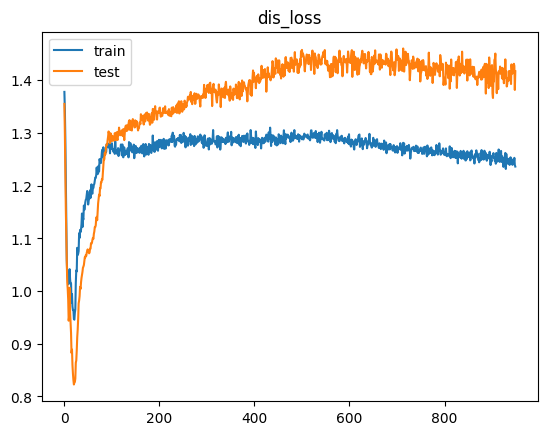

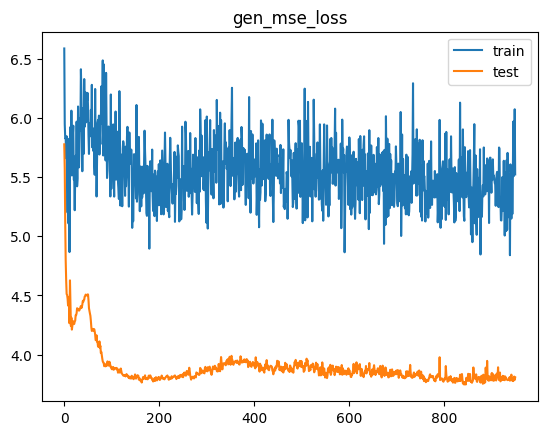

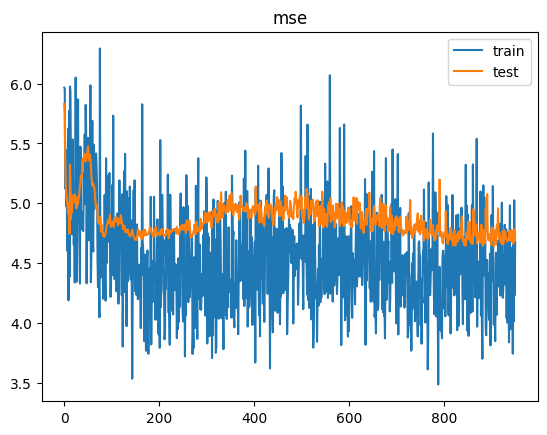

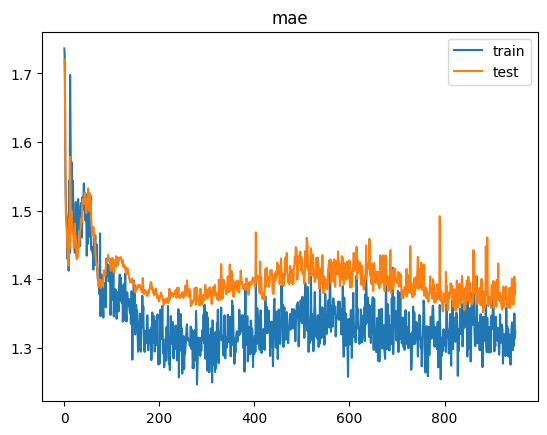

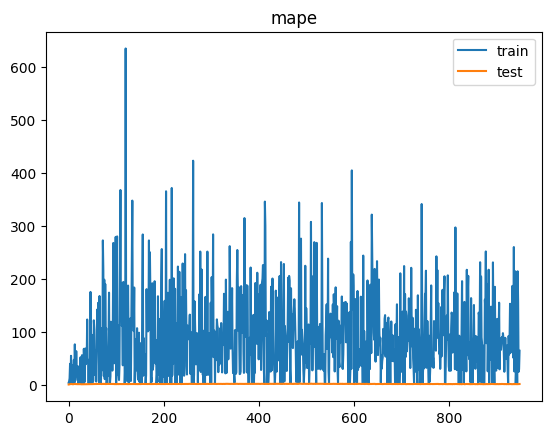

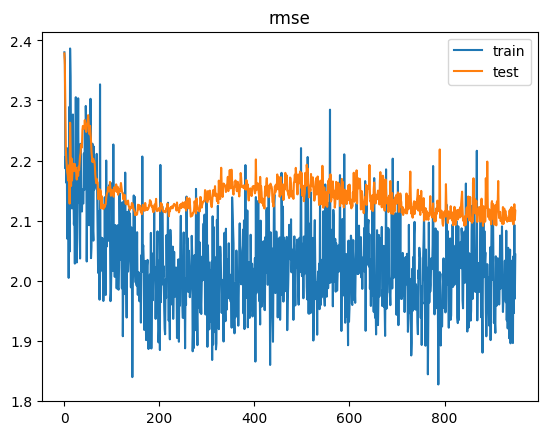

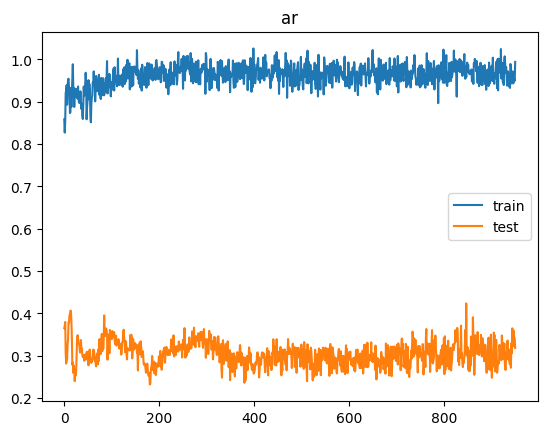

2/2 [==============================] - 0s 4ms/step


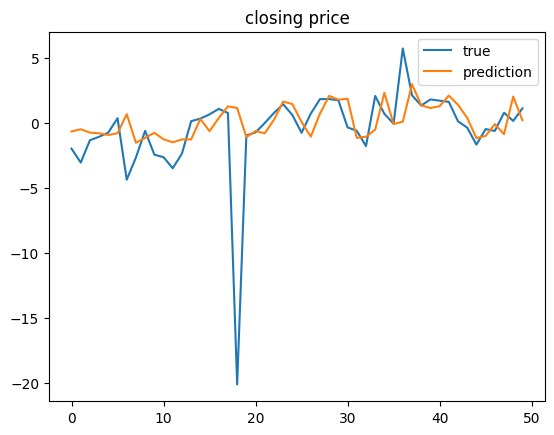

[MSE Baseline] train: 4.503270729089073  test: 4.68758521157695
Delta time with epochs = 950: 0:12:08.749332
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_9 (S

Time for epoch 53 is 0.8441495895385742 sec Generator Loss: 1.0771970748901367,  Discriminator_loss: 1.167749047279358
Time for epoch 54 is 0.825369119644165 sec Generator Loss: 1.0488280057907104,  Discriminator_loss: 1.1761633157730103
Time for epoch 55 is 0.8547713756561279 sec Generator Loss: 1.0735427141189575,  Discriminator_loss: 1.18358314037323
Time for epoch 56 is 0.8459880352020264 sec Generator Loss: 1.034789800643921,  Discriminator_loss: 1.1873527765274048
Time for epoch 57 is 0.8240039348602295 sec Generator Loss: 1.0335066318511963,  Discriminator_loss: 1.1959428787231445
Time for epoch 58 is 0.8080582618713379 sec Generator Loss: 1.0396876335144043,  Discriminator_loss: 1.2020503282546997
Time for epoch 59 is 0.8346784114837646 sec Generator Loss: 1.0152863264083862,  Discriminator_loss: 1.2258293628692627
Time for epoch 60 is 0.830169677734375 sec Generator Loss: 0.9997896552085876,  Discriminator_loss: 1.225432276725769
Time for epoch 61 is 0.9179003238677979 sec Gen

Time for epoch 122 is 0.9461312294006348 sec Generator Loss: 0.906577467918396,  Discriminator_loss: 1.2830135822296143
Time for epoch 123 is 0.8238914012908936 sec Generator Loss: 0.9043947458267212,  Discriminator_loss: 1.2763502597808838
Time for epoch 124 is 0.8226172924041748 sec Generator Loss: 0.9035263061523438,  Discriminator_loss: 1.2803436517715454
Time for epoch 125 is 0.8365075588226318 sec Generator Loss: 0.9028010368347168,  Discriminator_loss: 1.2854094505310059
Time for epoch 126 is 0.8642511367797852 sec Generator Loss: 0.9048535227775574,  Discriminator_loss: 1.2884796857833862
Time for epoch 127 is 0.8063256740570068 sec Generator Loss: 0.9020432829856873,  Discriminator_loss: 1.2854689359664917
Time for epoch 128 is 0.8535501956939697 sec Generator Loss: 0.8856663703918457,  Discriminator_loss: 1.29314124584198
Time for epoch 129 is 0.822040319442749 sec Generator Loss: 0.9031056761741638,  Discriminator_loss: 1.276292085647583
Time for epoch 130 is 0.8265244960784

Time for epoch 191 is 0.8603072166442871 sec Generator Loss: 0.8820415735244751,  Discriminator_loss: 1.2922083139419556
Time for epoch 192 is 0.8578519821166992 sec Generator Loss: 0.8879460692405701,  Discriminator_loss: 1.2859457731246948
Time for epoch 193 is 0.8397486209869385 sec Generator Loss: 0.8818742632865906,  Discriminator_loss: 1.291469693183899
Time for epoch 194 is 0.8385603427886963 sec Generator Loss: 0.8793103098869324,  Discriminator_loss: 1.2958475351333618
Time for epoch 195 is 0.87904953956604 sec Generator Loss: 0.8851256966590881,  Discriminator_loss: 1.296201467514038
Time for epoch 196 is 0.8394880294799805 sec Generator Loss: 0.8845034837722778,  Discriminator_loss: 1.2790528535842896
Time for epoch 197 is 0.8745267391204834 sec Generator Loss: 0.8711926341056824,  Discriminator_loss: 1.2940605878829956
Time for epoch 198 is 0.8672440052032471 sec Generator Loss: 0.876493513584137,  Discriminator_loss: 1.2917269468307495
Time for epoch 199 is 0.8412234783172

Time for epoch 259 is 0.7962875366210938 sec Generator Loss: 0.9022620320320129,  Discriminator_loss: 1.2902196645736694
Time for epoch 260 is 0.7996389865875244 sec Generator Loss: 0.8898096680641174,  Discriminator_loss: 1.28001868724823
Time for epoch 261 is 0.7947008609771729 sec Generator Loss: 0.9016934633255005,  Discriminator_loss: 1.2712185382843018
Time for epoch 262 is 0.8200418949127197 sec Generator Loss: 0.9011303186416626,  Discriminator_loss: 1.2739516496658325
Time for epoch 263 is 0.8454365730285645 sec Generator Loss: 0.8797124028205872,  Discriminator_loss: 1.2937084436416626
Time for epoch 264 is 0.8531613349914551 sec Generator Loss: 0.8926031589508057,  Discriminator_loss: 1.2777292728424072
Time for epoch 265 is 0.8373339176177979 sec Generator Loss: 0.8907071948051453,  Discriminator_loss: 1.2851054668426514
Time for epoch 266 is 0.8473691940307617 sec Generator Loss: 0.891516387462616,  Discriminator_loss: 1.2832651138305664
Time for epoch 267 is 0.86419177055

Time for epoch 327 is 0.8713889122009277 sec Generator Loss: 0.9265851974487305,  Discriminator_loss: 1.2612959146499634
Time for epoch 328 is 0.8778138160705566 sec Generator Loss: 0.9049903750419617,  Discriminator_loss: 1.2732521295547485
Time for epoch 329 is 0.8932809829711914 sec Generator Loss: 0.8991281390190125,  Discriminator_loss: 1.2913798093795776
Time for epoch 330 is 0.9768383502960205 sec Generator Loss: 0.8966079950332642,  Discriminator_loss: 1.285619854927063
Time for epoch 331 is 1.1031725406646729 sec Generator Loss: 0.8853849768638611,  Discriminator_loss: 1.2817397117614746
Time for epoch 332 is 1.0904381275177002 sec Generator Loss: 0.9049777984619141,  Discriminator_loss: 1.275062918663025
Time for epoch 333 is 1.1023521423339844 sec Generator Loss: 0.8898192048072815,  Discriminator_loss: 1.2777259349822998
Time for epoch 334 is 1.1878442764282227 sec Generator Loss: 0.9034737944602966,  Discriminator_loss: 1.2563518285751343
Time for epoch 335 is 0.9570956230

Time for epoch 396 is 0.8230760097503662 sec Generator Loss: 0.9204433560371399,  Discriminator_loss: 1.2520545721054077
Time for epoch 397 is 0.8020527362823486 sec Generator Loss: 0.9205936789512634,  Discriminator_loss: 1.2615752220153809
Time for epoch 398 is 0.788644552230835 sec Generator Loss: 0.9233652949333191,  Discriminator_loss: 1.2601755857467651
Time for epoch 399 is 0.8030149936676025 sec Generator Loss: 0.9267316460609436,  Discriminator_loss: 1.2560608386993408
Time for epoch 400 is 0.8060705661773682 sec Generator Loss: 0.9201362133026123,  Discriminator_loss: 1.2581573724746704
Time for epoch 401 is 0.805264949798584 sec Generator Loss: 0.9239636659622192,  Discriminator_loss: 1.2583121061325073
Time for epoch 402 is 0.8681471347808838 sec Generator Loss: 0.9209837913513184,  Discriminator_loss: 1.2517037391662598
Time for epoch 403 is 0.8747575283050537 sec Generator Loss: 0.9214015603065491,  Discriminator_loss: 1.253434419631958
Time for epoch 404 is 0.85748934745

Time for epoch 464 is 0.8097584247589111 sec Generator Loss: 0.9228154420852661,  Discriminator_loss: 1.254573106765747
Time for epoch 465 is 0.8094844818115234 sec Generator Loss: 0.9298734068870544,  Discriminator_loss: 1.2497774362564087
Time for epoch 466 is 0.8037886619567871 sec Generator Loss: 0.9338550567626953,  Discriminator_loss: 1.2532727718353271
Time for epoch 467 is 0.8048305511474609 sec Generator Loss: 0.9262374043464661,  Discriminator_loss: 1.2475677728652954
Time for epoch 468 is 0.8422057628631592 sec Generator Loss: 0.937309205532074,  Discriminator_loss: 1.2540485858917236
Time for epoch 469 is 0.8274524211883545 sec Generator Loss: 0.9344327449798584,  Discriminator_loss: 1.2410920858383179
Time for epoch 470 is 0.8285062313079834 sec Generator Loss: 0.9405871629714966,  Discriminator_loss: 1.2514941692352295
Time for epoch 471 is 0.8184514045715332 sec Generator Loss: 0.9309307932853699,  Discriminator_loss: 1.2529997825622559
Time for epoch 472 is 0.8029282093

Time for epoch 532 is 0.7968473434448242 sec Generator Loss: 0.9446293115615845,  Discriminator_loss: 1.2421679496765137
Time for epoch 533 is 0.8306725025177002 sec Generator Loss: 0.933705747127533,  Discriminator_loss: 1.2412978410720825
Time for epoch 534 is 0.8386843204498291 sec Generator Loss: 0.944709300994873,  Discriminator_loss: 1.2434210777282715
Time for epoch 535 is 0.864699125289917 sec Generator Loss: 0.9310581684112549,  Discriminator_loss: 1.2571676969528198
Time for epoch 536 is 0.8434133529663086 sec Generator Loss: 0.9311588406562805,  Discriminator_loss: 1.25788152217865
Time for epoch 537 is 0.798870325088501 sec Generator Loss: 0.9196105003356934,  Discriminator_loss: 1.2567428350448608
Time for epoch 538 is 0.8187987804412842 sec Generator Loss: 0.9371404051780701,  Discriminator_loss: 1.2434848546981812
Time for epoch 539 is 0.8480520248413086 sec Generator Loss: 0.9453030228614807,  Discriminator_loss: 1.241571307182312
Time for epoch 540 is 0.830539703369140

Time for epoch 601 is 0.9015977382659912 sec Generator Loss: 0.9386098384857178,  Discriminator_loss: 1.248034954071045
Time for epoch 602 is 0.9239246845245361 sec Generator Loss: 0.9427321553230286,  Discriminator_loss: 1.2543718814849854
Time for epoch 603 is 0.9664154052734375 sec Generator Loss: 0.9381316304206848,  Discriminator_loss: 1.2433598041534424
Time for epoch 604 is 0.9603149890899658 sec Generator Loss: 0.938802182674408,  Discriminator_loss: 1.2355728149414062
Time for epoch 605 is 0.9058170318603516 sec Generator Loss: 0.9480562210083008,  Discriminator_loss: 1.2317183017730713
Time for epoch 606 is 0.8855054378509521 sec Generator Loss: 0.9377549290657043,  Discriminator_loss: 1.249866008758545
Time for epoch 607 is 0.9697840213775635 sec Generator Loss: 0.9542325735092163,  Discriminator_loss: 1.2348613739013672
Time for epoch 608 is 0.9322390556335449 sec Generator Loss: 0.9452319145202637,  Discriminator_loss: 1.239893913269043
Time for epoch 609 is 0.919423580169

Time for epoch 670 is 0.9487054347991943 sec Generator Loss: 0.9404110908508301,  Discriminator_loss: 1.2541667222976685
Time for epoch 671 is 0.8469581604003906 sec Generator Loss: 0.9454717636108398,  Discriminator_loss: 1.241701364517212
Time for epoch 672 is 0.8963901996612549 sec Generator Loss: 0.9554774761199951,  Discriminator_loss: 1.2370542287826538
Time for epoch 673 is 0.8474206924438477 sec Generator Loss: 0.9530831575393677,  Discriminator_loss: 1.2344388961791992
Time for epoch 674 is 0.8734970092773438 sec Generator Loss: 0.9608508944511414,  Discriminator_loss: 1.2278105020523071
Time for epoch 675 is 0.859917402267456 sec Generator Loss: 0.963367760181427,  Discriminator_loss: 1.2308379411697388
Time for epoch 676 is 0.8966925144195557 sec Generator Loss: 0.958919882774353,  Discriminator_loss: 1.2267576456069946
Time for epoch 677 is 0.8788762092590332 sec Generator Loss: 0.9476789236068726,  Discriminator_loss: 1.2445834875106812
Time for epoch 678 is 0.929717302322

Time for epoch 738 is 0.9011497497558594 sec Generator Loss: 0.9557539820671082,  Discriminator_loss: 1.2383877038955688
Time for epoch 739 is 0.8818168640136719 sec Generator Loss: 0.9680047035217285,  Discriminator_loss: 1.2303352355957031
Time for epoch 740 is 0.8900785446166992 sec Generator Loss: 0.9546246528625488,  Discriminator_loss: 1.2416760921478271
Time for epoch 741 is 0.8502647876739502 sec Generator Loss: 0.9585472345352173,  Discriminator_loss: 1.2319438457489014
Time for epoch 742 is 0.8824748992919922 sec Generator Loss: 0.9654210805892944,  Discriminator_loss: 1.2293155193328857
Time for epoch 743 is 0.8884050846099854 sec Generator Loss: 0.9419801831245422,  Discriminator_loss: 1.2472728490829468
Time for epoch 744 is 0.934316873550415 sec Generator Loss: 0.946240246295929,  Discriminator_loss: 1.2496494054794312
Time for epoch 745 is 0.8857741355895996 sec Generator Loss: 0.9526066184043884,  Discriminator_loss: 1.234514594078064
Time for epoch 746 is 0.94681429862

Time for epoch 806 is 0.8716471195220947 sec Generator Loss: 0.9499626755714417,  Discriminator_loss: 1.2409762144088745
Time for epoch 807 is 0.9215302467346191 sec Generator Loss: 0.9525378346443176,  Discriminator_loss: 1.2384278774261475
Time for epoch 808 is 0.9129021167755127 sec Generator Loss: 0.9706032276153564,  Discriminator_loss: 1.2289055585861206
Time for epoch 809 is 0.9564390182495117 sec Generator Loss: 0.9491245746612549,  Discriminator_loss: 1.244235873222351
Time for epoch 810 is 0.9083957672119141 sec Generator Loss: 0.9673609733581543,  Discriminator_loss: 1.2166821956634521
Time for epoch 811 is 0.9367470741271973 sec Generator Loss: 0.9616062641143799,  Discriminator_loss: 1.2329931259155273
Time for epoch 812 is 0.9495398998260498 sec Generator Loss: 0.9600455164909363,  Discriminator_loss: 1.2409679889678955
Time for epoch 813 is 0.9626429080963135 sec Generator Loss: 0.9517565369606018,  Discriminator_loss: 1.24314546585083
Time for epoch 814 is 1.00903725624

Time for epoch 875 is 0.8742060661315918 sec Generator Loss: 0.9550355076789856,  Discriminator_loss: 1.2318506240844727
Time for epoch 876 is 0.8958821296691895 sec Generator Loss: 0.9589847326278687,  Discriminator_loss: 1.2299535274505615
Time for epoch 877 is 0.8663556575775146 sec Generator Loss: 0.9609347581863403,  Discriminator_loss: 1.236941933631897
Time for epoch 878 is 0.879112720489502 sec Generator Loss: 0.955040693283081,  Discriminator_loss: 1.2391639947891235
Time for epoch 879 is 0.9253692626953125 sec Generator Loss: 0.9657224416732788,  Discriminator_loss: 1.2298353910446167
Time for epoch 880 is 0.8970606327056885 sec Generator Loss: 0.9678291082382202,  Discriminator_loss: 1.2265629768371582
Time for epoch 881 is 0.9069726467132568 sec Generator Loss: 0.9719840288162231,  Discriminator_loss: 1.2256876230239868
Time for epoch 882 is 0.8915793895721436 sec Generator Loss: 0.9731612205505371,  Discriminator_loss: 1.2334033250808716
Time for epoch 883 is 0.89935135841

Time for epoch 943 is 1.105116367340088 sec Generator Loss: 0.9702184200286865,  Discriminator_loss: 1.2232387065887451
Time for epoch 944 is 1.100370168685913 sec Generator Loss: 0.9759832620620728,  Discriminator_loss: 1.2279356718063354
Time for epoch 945 is 1.0021541118621826 sec Generator Loss: 0.9452351927757263,  Discriminator_loss: 1.2483744621276855
Time for epoch 946 is 0.9378643035888672 sec Generator Loss: 0.9826816320419312,  Discriminator_loss: 1.2117496728897095
Time for epoch 947 is 0.9184608459472656 sec Generator Loss: 0.9722118377685547,  Discriminator_loss: 1.2308799028396606
Time for epoch 948 is 0.900444746017456 sec Generator Loss: 0.958864152431488,  Discriminator_loss: 1.2390589714050293
Time for epoch 949 is 0.90041184425354 sec Generator Loss: 0.9727671146392822,  Discriminator_loss: 1.2244199514389038
Time for epoch 950 is 0.9284098148345947 sec Generator Loss: 0.9631341695785522,  Discriminator_loss: 1.2185643911361694
Time for epoch 951 is 0.92332005500793

Time for epoch 1011 is 0.9712727069854736 sec Generator Loss: 0.9725505113601685,  Discriminator_loss: 1.229414701461792
Time for epoch 1012 is 0.9089946746826172 sec Generator Loss: 0.9652184247970581,  Discriminator_loss: 1.2455637454986572
Time for epoch 1013 is 0.9054362773895264 sec Generator Loss: 0.9709061980247498,  Discriminator_loss: 1.2257800102233887
Time for epoch 1014 is 0.8968887329101562 sec Generator Loss: 0.9580841660499573,  Discriminator_loss: 1.2433253526687622
Time for epoch 1015 is 0.9335792064666748 sec Generator Loss: 0.9736723303794861,  Discriminator_loss: 1.2249282598495483
Time for epoch 1016 is 0.9013364315032959 sec Generator Loss: 0.9622308015823364,  Discriminator_loss: 1.2400009632110596
Time for epoch 1017 is 0.9636356830596924 sec Generator Loss: 0.9568095207214355,  Discriminator_loss: 1.2445900440216064
Time for epoch 1018 is 0.8867919445037842 sec Generator Loss: 0.9870416522026062,  Discriminator_loss: 1.2222706079483032
Time for epoch 1019 is 0.

Time for epoch 1079 is 0.9311954975128174 sec Generator Loss: 0.9459781050682068,  Discriminator_loss: 1.2355468273162842
Time for epoch 1080 is 0.9124717712402344 sec Generator Loss: 0.9628357291221619,  Discriminator_loss: 1.2383077144622803
Time for epoch 1081 is 0.906179666519165 sec Generator Loss: 0.9667149186134338,  Discriminator_loss: 1.2352944612503052
Time for epoch 1082 is 0.9109885692596436 sec Generator Loss: 0.9751708507537842,  Discriminator_loss: 1.2239984273910522
Time for epoch 1083 is 0.9239852428436279 sec Generator Loss: 0.969871997833252,  Discriminator_loss: 1.2286242246627808
Time for epoch 1084 is 0.970360517501831 sec Generator Loss: 0.9750661253929138,  Discriminator_loss: 1.2305797338485718
Time for epoch 1085 is 0.9149887561798096 sec Generator Loss: 0.9710862040519714,  Discriminator_loss: 1.2274707555770874
Time for epoch 1086 is 0.8946588039398193 sec Generator Loss: 0.9634363055229187,  Discriminator_loss: 1.2311781644821167
Time for epoch 1087 is 0.88

Time for epoch 1147 is 0.9006912708282471 sec Generator Loss: 0.9717690348625183,  Discriminator_loss: 1.2220923900604248
Time for epoch 1148 is 0.9068353176116943 sec Generator Loss: 0.9715319871902466,  Discriminator_loss: 1.2252498865127563
Time for epoch 1149 is 0.8986282348632812 sec Generator Loss: 0.9819888472557068,  Discriminator_loss: 1.2191129922866821
Time for epoch 1150 is 0.9376406669616699 sec Generator Loss: 0.9716864228248596,  Discriminator_loss: 1.2355676889419556
Time for epoch 1151 is 0.9625716209411621 sec Generator Loss: 0.9698412418365479,  Discriminator_loss: 1.2237516641616821
Time for epoch 1152 is 0.9024658203125 sec Generator Loss: 0.9906548261642456,  Discriminator_loss: 1.2298613786697388
Time for epoch 1153 is 0.8973429203033447 sec Generator Loss: 0.9715877175331116,  Discriminator_loss: 1.2402616739273071
Time for epoch 1154 is 0.9070589542388916 sec Generator Loss: 0.9585646390914917,  Discriminator_loss: 1.2402153015136719
Time for epoch 1155 is 0.91

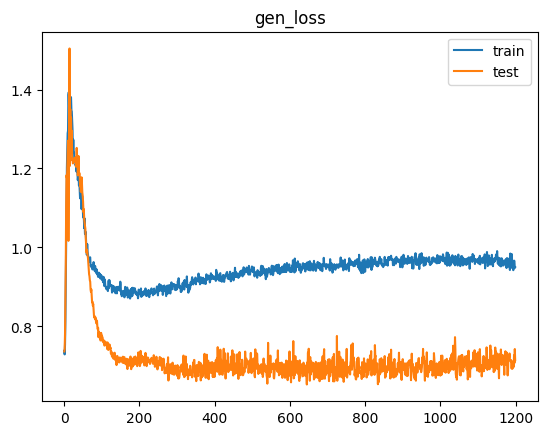

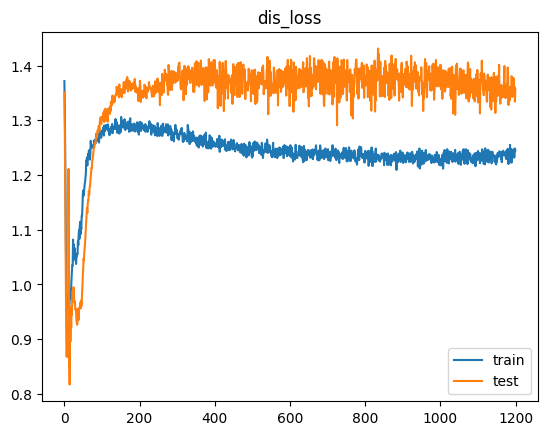

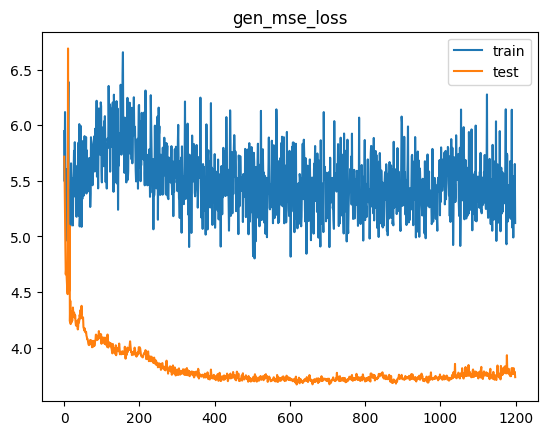

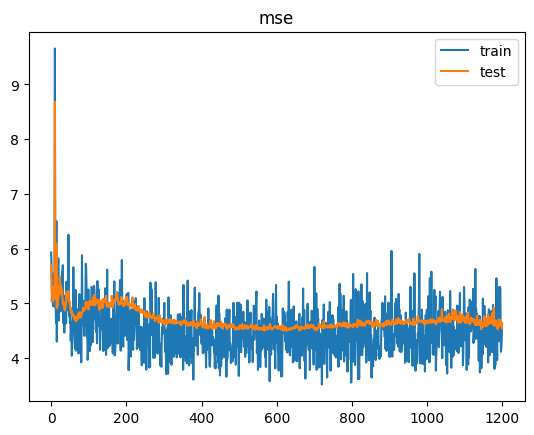

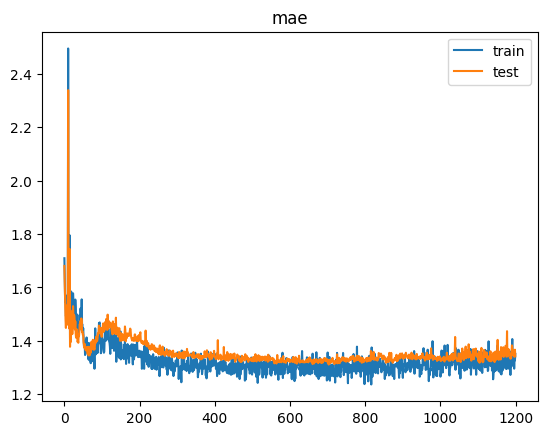

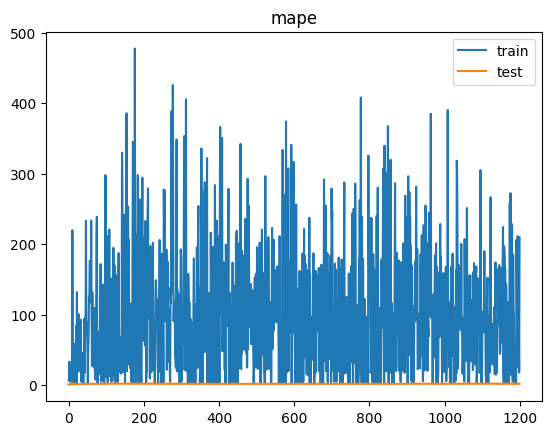

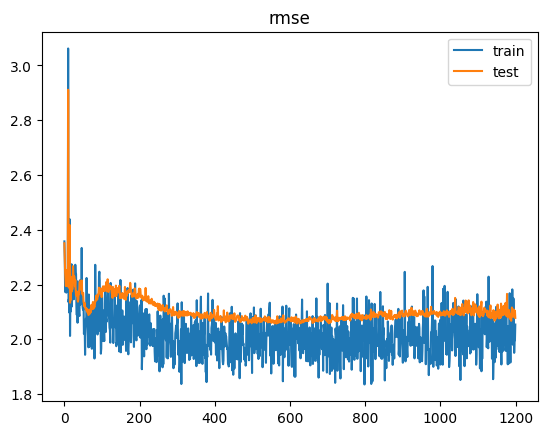

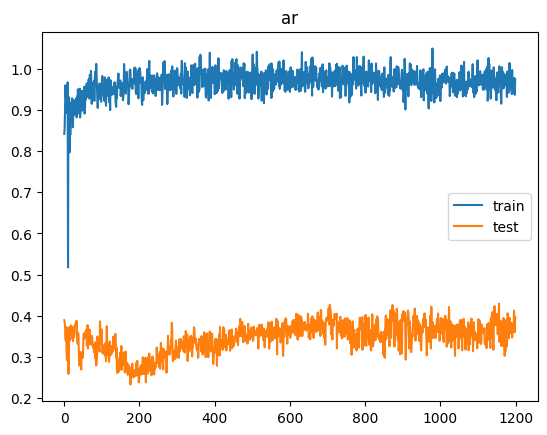

2/2 [==============================] - 0s 6ms/step


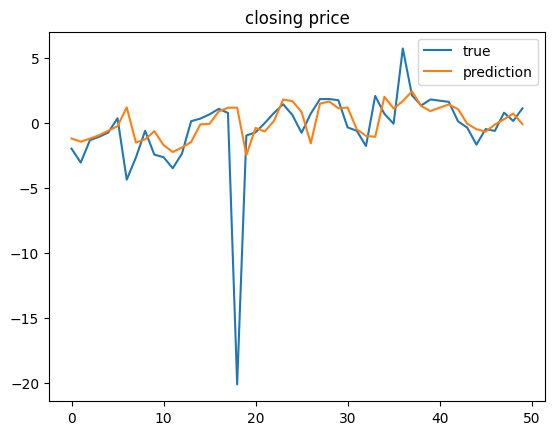

[MSE Baseline] train: 4.449451496231897  test: 4.68758521157695
Delta time with epochs = 1200: 0:17:46.331445
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 5, 10)             180       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_11 

Time for epoch 52 is 0.8589882850646973 sec Generator Loss: 0.9597980976104736,  Discriminator_loss: 1.2404941320419312
Time for epoch 53 is 0.8698534965515137 sec Generator Loss: 0.9639155864715576,  Discriminator_loss: 1.2497490644454956
Time for epoch 54 is 0.8550982475280762 sec Generator Loss: 0.9478994607925415,  Discriminator_loss: 1.257413387298584
Time for epoch 55 is 0.8738405704498291 sec Generator Loss: 0.9391730427742004,  Discriminator_loss: 1.2621067762374878
Time for epoch 56 is 0.8498275279998779 sec Generator Loss: 0.9470895528793335,  Discriminator_loss: 1.252026915550232
Time for epoch 57 is 0.8444147109985352 sec Generator Loss: 0.9333160519599915,  Discriminator_loss: 1.2619991302490234
Time for epoch 58 is 0.8557143211364746 sec Generator Loss: 0.945480465888977,  Discriminator_loss: 1.251790165901184
Time for epoch 59 is 0.8665449619293213 sec Generator Loss: 0.9422307014465332,  Discriminator_loss: 1.2672210931777954
Time for epoch 60 is 0.8494961261749268 sec 

Time for epoch 121 is 0.9161477088928223 sec Generator Loss: 0.8823964595794678,  Discriminator_loss: 1.2962911128997803
Time for epoch 122 is 0.8925111293792725 sec Generator Loss: 0.8847795724868774,  Discriminator_loss: 1.2979382276535034
Time for epoch 123 is 0.8785004615783691 sec Generator Loss: 0.8834460973739624,  Discriminator_loss: 1.3041197061538696
Time for epoch 124 is 0.8398227691650391 sec Generator Loss: 0.8861172199249268,  Discriminator_loss: 1.2949414253234863
Time for epoch 125 is 0.8369243144989014 sec Generator Loss: 0.8850122690200806,  Discriminator_loss: 1.3012605905532837
Time for epoch 126 is 0.8445870876312256 sec Generator Loss: 0.892833948135376,  Discriminator_loss: 1.2955267429351807
Time for epoch 127 is 0.8621971607208252 sec Generator Loss: 0.8781867623329163,  Discriminator_loss: 1.3041443824768066
Time for epoch 128 is 0.8408071994781494 sec Generator Loss: 0.894690752029419,  Discriminator_loss: 1.2999197244644165
Time for epoch 129 is 0.8446614742

Time for epoch 189 is 0.8839573860168457 sec Generator Loss: 0.869812548160553,  Discriminator_loss: 1.2980743646621704
Time for epoch 190 is 0.8657622337341309 sec Generator Loss: 0.8679890632629395,  Discriminator_loss: 1.2912921905517578
Time for epoch 191 is 0.8715875148773193 sec Generator Loss: 0.859441339969635,  Discriminator_loss: 1.3036500215530396
Time for epoch 192 is 0.883436918258667 sec Generator Loss: 0.8625890016555786,  Discriminator_loss: 1.3000354766845703
Time for epoch 193 is 0.8541533946990967 sec Generator Loss: 0.8630891442298889,  Discriminator_loss: 1.3067628145217896
Time for epoch 194 is 0.8656389713287354 sec Generator Loss: 0.8659359812736511,  Discriminator_loss: 1.2997819185256958
Time for epoch 195 is 0.8875875473022461 sec Generator Loss: 0.8731350302696228,  Discriminator_loss: 1.3007205724716187
Time for epoch 196 is 0.8602008819580078 sec Generator Loss: 0.8671779632568359,  Discriminator_loss: 1.2971395254135132
Time for epoch 197 is 0.89876794815

Time for epoch 258 is 0.8793826103210449 sec Generator Loss: 0.8501641750335693,  Discriminator_loss: 1.3123679161071777
Time for epoch 259 is 0.8571221828460693 sec Generator Loss: 0.8589268326759338,  Discriminator_loss: 1.313145637512207
Time for epoch 260 is 0.8458969593048096 sec Generator Loss: 0.8565425872802734,  Discriminator_loss: 1.3055975437164307
Time for epoch 261 is 0.8688690662384033 sec Generator Loss: 0.8433588743209839,  Discriminator_loss: 1.3132727146148682
Time for epoch 262 is 0.8770956993103027 sec Generator Loss: 0.8557577133178711,  Discriminator_loss: 1.3083654642105103
Time for epoch 263 is 0.8901419639587402 sec Generator Loss: 0.8497831225395203,  Discriminator_loss: 1.3100595474243164
Time for epoch 264 is 0.8537530899047852 sec Generator Loss: 0.8537572622299194,  Discriminator_loss: 1.3073265552520752
Time for epoch 265 is 0.9341855049133301 sec Generator Loss: 0.847623884677887,  Discriminator_loss: 1.3119255304336548
Time for epoch 266 is 0.8723607063

Time for epoch 326 is 0.8566169738769531 sec Generator Loss: 0.8608867526054382,  Discriminator_loss: 1.3099279403686523
Time for epoch 327 is 0.8501496315002441 sec Generator Loss: 0.8641979694366455,  Discriminator_loss: 1.2996984720230103
Time for epoch 328 is 0.8696935176849365 sec Generator Loss: 0.8580020666122437,  Discriminator_loss: 1.3140666484832764
Time for epoch 329 is 0.9029338359832764 sec Generator Loss: 0.8717853426933289,  Discriminator_loss: 1.2967321872711182
Time for epoch 330 is 0.8567461967468262 sec Generator Loss: 0.8688297867774963,  Discriminator_loss: 1.299996018409729
Time for epoch 331 is 0.8779454231262207 sec Generator Loss: 0.872340738773346,  Discriminator_loss: 1.2968918085098267
Time for epoch 332 is 0.9343416690826416 sec Generator Loss: 0.8738446831703186,  Discriminator_loss: 1.3026039600372314
Time for epoch 333 is 0.8720014095306396 sec Generator Loss: 0.8650488257408142,  Discriminator_loss: 1.298969030380249
Time for epoch 334 is 0.87625384330

Time for epoch 394 is 0.9163846969604492 sec Generator Loss: 0.8725593090057373,  Discriminator_loss: 1.2945078611373901
Time for epoch 395 is 0.9461672306060791 sec Generator Loss: 0.879176914691925,  Discriminator_loss: 1.2952723503112793
Time for epoch 396 is 1.0050792694091797 sec Generator Loss: 0.8725903034210205,  Discriminator_loss: 1.3059886693954468
Time for epoch 397 is 0.9893491268157959 sec Generator Loss: 0.8732593655586243,  Discriminator_loss: 1.296019196510315
Time for epoch 398 is 0.9759268760681152 sec Generator Loss: 0.873439610004425,  Discriminator_loss: 1.3108913898468018
Time for epoch 399 is 0.9419925212860107 sec Generator Loss: 0.8776437044143677,  Discriminator_loss: 1.29690682888031
Time for epoch 400 is 1.0021891593933105 sec Generator Loss: 0.8696815371513367,  Discriminator_loss: 1.3021348714828491
Time for epoch 401 is 0.9676814079284668 sec Generator Loss: 0.8787142634391785,  Discriminator_loss: 1.294864535331726
Time for epoch 402 is 0.97900462150573

Time for epoch 462 is 0.9667947292327881 sec Generator Loss: 0.8855704665184021,  Discriminator_loss: 1.2989802360534668
Time for epoch 463 is 0.9752750396728516 sec Generator Loss: 0.8885926008224487,  Discriminator_loss: 1.2947298288345337
Time for epoch 464 is 0.9856829643249512 sec Generator Loss: 0.8807528614997864,  Discriminator_loss: 1.2904249429702759
Time for epoch 465 is 1.0293149948120117 sec Generator Loss: 0.8788992762565613,  Discriminator_loss: 1.2978776693344116
Time for epoch 466 is 0.9928913116455078 sec Generator Loss: 0.8834706544876099,  Discriminator_loss: 1.2917085886001587
Time for epoch 467 is 0.969078779220581 sec Generator Loss: 0.8867576718330383,  Discriminator_loss: 1.2999478578567505
Time for epoch 468 is 1.0030875205993652 sec Generator Loss: 0.8815904259681702,  Discriminator_loss: 1.2926373481750488
Time for epoch 469 is 0.984776496887207 sec Generator Loss: 0.8913992047309875,  Discriminator_loss: 1.2933475971221924
Time for epoch 470 is 1.0329656600

Time for epoch 531 is 1.0476198196411133 sec Generator Loss: 0.8931116461753845,  Discriminator_loss: 1.2823420763015747
Time for epoch 532 is 1.03818941116333 sec Generator Loss: 0.8982856869697571,  Discriminator_loss: 1.287768006324768
Time for epoch 533 is 1.0061087608337402 sec Generator Loss: 0.8865360021591187,  Discriminator_loss: 1.2953811883926392
Time for epoch 534 is 1.0113673210144043 sec Generator Loss: 0.8890039920806885,  Discriminator_loss: 1.292160987854004
Time for epoch 535 is 0.9791178703308105 sec Generator Loss: 0.9027422666549683,  Discriminator_loss: 1.28413987159729
Time for epoch 536 is 1.0240209102630615 sec Generator Loss: 0.873720645904541,  Discriminator_loss: 1.30000638961792
Time for epoch 537 is 1.032564401626587 sec Generator Loss: 0.8960137963294983,  Discriminator_loss: 1.2870018482208252
Time for epoch 538 is 0.9697844982147217 sec Generator Loss: 0.8861676454544067,  Discriminator_loss: 1.2924535274505615
Time for epoch 539 is 0.9741013050079346 s

Time for epoch 600 is 1.0374047756195068 sec Generator Loss: 0.8992741703987122,  Discriminator_loss: 1.277919054031372
Time for epoch 601 is 1.0097808837890625 sec Generator Loss: 0.9052239060401917,  Discriminator_loss: 1.2847015857696533
Time for epoch 602 is 1.028712511062622 sec Generator Loss: 0.8936585187911987,  Discriminator_loss: 1.2852060794830322
Time for epoch 603 is 1.182882308959961 sec Generator Loss: 0.9146682024002075,  Discriminator_loss: 1.266886591911316
Time for epoch 604 is 1.106602430343628 sec Generator Loss: 0.90720134973526,  Discriminator_loss: 1.2775721549987793
Time for epoch 605 is 1.0443336963653564 sec Generator Loss: 0.8898029327392578,  Discriminator_loss: 1.289536952972412
Time for epoch 606 is 1.1545987129211426 sec Generator Loss: 0.9016982316970825,  Discriminator_loss: 1.281398892402649
Time for epoch 607 is 1.1166527271270752 sec Generator Loss: 0.8923234939575195,  Discriminator_loss: 1.2868841886520386
Time for epoch 608 is 1.0369577407836914 

Time for epoch 669 is 1.0559866428375244 sec Generator Loss: 0.9113255143165588,  Discriminator_loss: 1.2773054838180542
Time for epoch 670 is 0.9886820316314697 sec Generator Loss: 0.9075365662574768,  Discriminator_loss: 1.27471125125885
Time for epoch 671 is 0.9741942882537842 sec Generator Loss: 0.9019380807876587,  Discriminator_loss: 1.2850821018218994
Time for epoch 672 is 0.9504604339599609 sec Generator Loss: 0.8988848328590393,  Discriminator_loss: 1.2835296392440796
Time for epoch 673 is 0.9630839824676514 sec Generator Loss: 0.9145662188529968,  Discriminator_loss: 1.283815622329712
Time for epoch 674 is 0.9810450077056885 sec Generator Loss: 0.898431658744812,  Discriminator_loss: 1.2801867723464966
Time for epoch 675 is 0.9414684772491455 sec Generator Loss: 0.9095550775527954,  Discriminator_loss: 1.2813531160354614
Time for epoch 676 is 0.9849715232849121 sec Generator Loss: 0.9074898362159729,  Discriminator_loss: 1.2808442115783691
Time for epoch 677 is 0.969217061996

Time for epoch 738 is 1.040149450302124 sec Generator Loss: 0.897895336151123,  Discriminator_loss: 1.2850456237792969
Time for epoch 739 is 1.0324194431304932 sec Generator Loss: 0.9031994342803955,  Discriminator_loss: 1.2877159118652344
Time for epoch 740 is 1.0564756393432617 sec Generator Loss: 0.902317225933075,  Discriminator_loss: 1.272653341293335
Time for epoch 741 is 1.1371772289276123 sec Generator Loss: 0.9147629141807556,  Discriminator_loss: 1.2677879333496094
Time for epoch 742 is 1.0837931632995605 sec Generator Loss: 0.9154875874519348,  Discriminator_loss: 1.272760272026062
Time for epoch 743 is 1.0861585140228271 sec Generator Loss: 0.9167455434799194,  Discriminator_loss: 1.2801600694656372
Time for epoch 744 is 1.111027479171753 sec Generator Loss: 0.9134576916694641,  Discriminator_loss: 1.2793493270874023
Time for epoch 745 is 1.183516025543213 sec Generator Loss: 0.9156699776649475,  Discriminator_loss: 1.2732175588607788
Time for epoch 746 is 1.097331762313842

Time for epoch 807 is 1.1031537055969238 sec Generator Loss: 0.9146369695663452,  Discriminator_loss: 1.2648903131484985
Time for epoch 808 is 1.1772351264953613 sec Generator Loss: 0.9244994521141052,  Discriminator_loss: 1.2762835025787354
Time for epoch 809 is 1.2138888835906982 sec Generator Loss: 0.9307079315185547,  Discriminator_loss: 1.2578901052474976
Time for epoch 810 is 1.1532716751098633 sec Generator Loss: 0.9013901352882385,  Discriminator_loss: 1.2935255765914917
Time for epoch 811 is 1.1948862075805664 sec Generator Loss: 0.9128044247627258,  Discriminator_loss: 1.2740460634231567
Time for epoch 812 is 1.1904630661010742 sec Generator Loss: 0.925957977771759,  Discriminator_loss: 1.2679996490478516
Time for epoch 813 is 1.216209888458252 sec Generator Loss: 0.9150607585906982,  Discriminator_loss: 1.2802269458770752
Time for epoch 814 is 1.269162654876709 sec Generator Loss: 0.9333270192146301,  Discriminator_loss: 1.2646100521087646
Time for epoch 815 is 1.12071371078

Time for epoch 876 is 1.269648551940918 sec Generator Loss: 0.9217392206192017,  Discriminator_loss: 1.2672630548477173
Time for epoch 877 is 1.3461415767669678 sec Generator Loss: 0.9254302382469177,  Discriminator_loss: 1.2692794799804688
Time for epoch 878 is 1.351241111755371 sec Generator Loss: 0.9116518497467041,  Discriminator_loss: 1.2696572542190552
Time for epoch 879 is 1.2597322463989258 sec Generator Loss: 0.9300521016120911,  Discriminator_loss: 1.2670257091522217
Time for epoch 880 is 1.279740810394287 sec Generator Loss: 0.9254983067512512,  Discriminator_loss: 1.2725181579589844
Time for epoch 881 is 1.1901183128356934 sec Generator Loss: 0.9024652242660522,  Discriminator_loss: 1.2716503143310547
Time for epoch 882 is 1.3184096813201904 sec Generator Loss: 0.9365538954734802,  Discriminator_loss: 1.2592695951461792
Time for epoch 883 is 1.260042667388916 sec Generator Loss: 0.9404005408287048,  Discriminator_loss: 1.2668811082839966
Time for epoch 884 is 1.311030626296

Time for epoch 945 is 1.034902811050415 sec Generator Loss: 0.9146093130111694,  Discriminator_loss: 1.2707558870315552
Time for epoch 946 is 1.0064876079559326 sec Generator Loss: 0.9227575063705444,  Discriminator_loss: 1.268731713294983
Time for epoch 947 is 1.0050902366638184 sec Generator Loss: 0.9290202260017395,  Discriminator_loss: 1.2600946426391602
Time for epoch 948 is 1.0299277305603027 sec Generator Loss: 0.9425416588783264,  Discriminator_loss: 1.265169620513916
Time for epoch 949 is 1.0433757305145264 sec Generator Loss: 0.9329867362976074,  Discriminator_loss: 1.2733720541000366
Time for epoch 950 is 1.025547981262207 sec Generator Loss: 0.9131545424461365,  Discriminator_loss: 1.2753279209136963
Time for epoch 951 is 1.0189547538757324 sec Generator Loss: 0.931144654750824,  Discriminator_loss: 1.260656714439392
Time for epoch 952 is 1.0065701007843018 sec Generator Loss: 0.9245796799659729,  Discriminator_loss: 1.2738252878189087
Time for epoch 953 is 1.01052260398864

Time for epoch 1013 is 0.9835548400878906 sec Generator Loss: 0.9355517625808716,  Discriminator_loss: 1.262636423110962
Time for epoch 1014 is 1.0370512008666992 sec Generator Loss: 0.9398149847984314,  Discriminator_loss: 1.2565197944641113
Time for epoch 1015 is 1.0134661197662354 sec Generator Loss: 0.9493609666824341,  Discriminator_loss: 1.245826005935669
Time for epoch 1016 is 1.0995137691497803 sec Generator Loss: 0.9445368051528931,  Discriminator_loss: 1.2625213861465454
Time for epoch 1017 is 1.0507726669311523 sec Generator Loss: 0.9427756071090698,  Discriminator_loss: 1.270209550857544
Time for epoch 1018 is 1.078218698501587 sec Generator Loss: 0.937603771686554,  Discriminator_loss: 1.2592236995697021
Time for epoch 1019 is 1.0882492065429688 sec Generator Loss: 0.9353255033493042,  Discriminator_loss: 1.2661155462265015
Time for epoch 1020 is 1.0871024131774902 sec Generator Loss: 0.9456026554107666,  Discriminator_loss: 1.2650507688522339
Time for epoch 1021 is 1.1317

Time for epoch 1081 is 1.1345694065093994 sec Generator Loss: 0.963218092918396,  Discriminator_loss: 1.2518107891082764
Time for epoch 1082 is 1.133176565170288 sec Generator Loss: 0.9470747113227844,  Discriminator_loss: 1.2602523565292358
Time for epoch 1083 is 1.0617945194244385 sec Generator Loss: 0.9560985565185547,  Discriminator_loss: 1.2548978328704834
Time for epoch 1084 is 1.0703856945037842 sec Generator Loss: 0.9446671605110168,  Discriminator_loss: 1.259601354598999
Time for epoch 1085 is 1.0764744281768799 sec Generator Loss: 0.9550942182540894,  Discriminator_loss: 1.2575950622558594
Time for epoch 1086 is 1.1509833335876465 sec Generator Loss: 0.9495801329612732,  Discriminator_loss: 1.2585760354995728
Time for epoch 1087 is 1.095250129699707 sec Generator Loss: 0.9531974196434021,  Discriminator_loss: 1.253234624862671
Time for epoch 1088 is 1.0995228290557861 sec Generator Loss: 0.9423848390579224,  Discriminator_loss: 1.2587363719940186
Time for epoch 1089 is 1.0966

Time for epoch 1149 is 1.0390124320983887 sec Generator Loss: 0.9490790367126465,  Discriminator_loss: 1.2578531503677368
Time for epoch 1150 is 1.0588133335113525 sec Generator Loss: 0.9434916377067566,  Discriminator_loss: 1.2570390701293945
Time for epoch 1151 is 1.070296049118042 sec Generator Loss: 0.9543303847312927,  Discriminator_loss: 1.2519745826721191
Time for epoch 1152 is 1.025564432144165 sec Generator Loss: 0.9699110388755798,  Discriminator_loss: 1.2510803937911987
Time for epoch 1153 is 1.0466644763946533 sec Generator Loss: 0.9538639187812805,  Discriminator_loss: 1.2581932544708252
Time for epoch 1154 is 1.0085945129394531 sec Generator Loss: 0.9611967206001282,  Discriminator_loss: 1.2484791278839111
Time for epoch 1155 is 1.052398920059204 sec Generator Loss: 0.9578911662101746,  Discriminator_loss: 1.2565089464187622
Time for epoch 1156 is 1.0185208320617676 sec Generator Loss: 0.9544199109077454,  Discriminator_loss: 1.2633612155914307
Time for epoch 1157 is 0.99

Time for epoch 1217 is 1.0459284782409668 sec Generator Loss: 0.9532652497291565,  Discriminator_loss: 1.2607945203781128
Time for epoch 1218 is 1.0171124935150146 sec Generator Loss: 0.9536550641059875,  Discriminator_loss: 1.2573670148849487
Time for epoch 1219 is 1.0382165908813477 sec Generator Loss: 0.9435855150222778,  Discriminator_loss: 1.2686131000518799
Time for epoch 1220 is 1.0767550468444824 sec Generator Loss: 0.954047441482544,  Discriminator_loss: 1.2646875381469727
Time for epoch 1221 is 1.0497171878814697 sec Generator Loss: 0.932241678237915,  Discriminator_loss: 1.2692958116531372
Time for epoch 1222 is 1.0373449325561523 sec Generator Loss: 0.9463967680931091,  Discriminator_loss: 1.2543476819992065
Time for epoch 1223 is 1.0530498027801514 sec Generator Loss: 0.9520888924598694,  Discriminator_loss: 1.244941234588623
Time for epoch 1224 is 1.0691602230072021 sec Generator Loss: 0.9560367465019226,  Discriminator_loss: 1.253146767616272
Time for epoch 1225 is 1.117

Time for epoch 1285 is 1.0713658332824707 sec Generator Loss: 0.961083710193634,  Discriminator_loss: 1.2505019903182983
Time for epoch 1286 is 1.1052017211914062 sec Generator Loss: 0.9618234634399414,  Discriminator_loss: 1.2525278329849243
Time for epoch 1287 is 1.1235735416412354 sec Generator Loss: 0.9465650320053101,  Discriminator_loss: 1.2576404809951782
Time for epoch 1288 is 1.052109718322754 sec Generator Loss: 0.9541054368019104,  Discriminator_loss: 1.2437934875488281
Time for epoch 1289 is 1.0746116638183594 sec Generator Loss: 0.9420844912528992,  Discriminator_loss: 1.2673419713974
Time for epoch 1290 is 1.0605177879333496 sec Generator Loss: 0.9613150954246521,  Discriminator_loss: 1.2520248889923096
Time for epoch 1291 is 1.1019866466522217 sec Generator Loss: 0.9488294124603271,  Discriminator_loss: 1.2531347274780273
Time for epoch 1292 is 1.1350641250610352 sec Generator Loss: 0.947393536567688,  Discriminator_loss: 1.253046989440918
Time for epoch 1293 is 1.128834

Time for epoch 1353 is 1.2149052619934082 sec Generator Loss: 0.9698920845985413,  Discriminator_loss: 1.2547848224639893
Time for epoch 1354 is 1.168921709060669 sec Generator Loss: 0.9602007269859314,  Discriminator_loss: 1.2647448778152466
Time for epoch 1355 is 1.1288783550262451 sec Generator Loss: 0.9525783061981201,  Discriminator_loss: 1.251874327659607
Time for epoch 1356 is 1.1466691493988037 sec Generator Loss: 0.9563397765159607,  Discriminator_loss: 1.2586042881011963
Time for epoch 1357 is 1.2027485370635986 sec Generator Loss: 0.9671905636787415,  Discriminator_loss: 1.246955156326294
Time for epoch 1358 is 1.160506248474121 sec Generator Loss: 0.9636493921279907,  Discriminator_loss: 1.2454975843429565
Time for epoch 1359 is 1.121657371520996 sec Generator Loss: 0.9649111032485962,  Discriminator_loss: 1.247278094291687
Time for epoch 1360 is 1.102717638015747 sec Generator Loss: 0.9641878604888916,  Discriminator_loss: 1.2460761070251465
Time for epoch 1361 is 1.194174

Time for epoch 1421 is 1.0953338146209717 sec Generator Loss: 0.968952476978302,  Discriminator_loss: 1.2526895999908447
Time for epoch 1422 is 1.0907189846038818 sec Generator Loss: 0.9854816794395447,  Discriminator_loss: 1.2433176040649414
Time for epoch 1423 is 1.0755772590637207 sec Generator Loss: 0.9760982990264893,  Discriminator_loss: 1.250590443611145
Time for epoch 1424 is 1.1500248908996582 sec Generator Loss: 0.9650159478187561,  Discriminator_loss: 1.2510566711425781
Time for epoch 1425 is 1.087979793548584 sec Generator Loss: 0.9639039635658264,  Discriminator_loss: 1.2542874813079834
Time for epoch 1426 is 1.0858852863311768 sec Generator Loss: 0.9686231017112732,  Discriminator_loss: 1.2481123208999634
Time for epoch 1427 is 1.099414587020874 sec Generator Loss: 0.9525555372238159,  Discriminator_loss: 1.2587624788284302
Time for epoch 1428 is 1.1307661533355713 sec Generator Loss: 0.9707191586494446,  Discriminator_loss: 1.247007131576538
Time for epoch 1429 is 1.1347

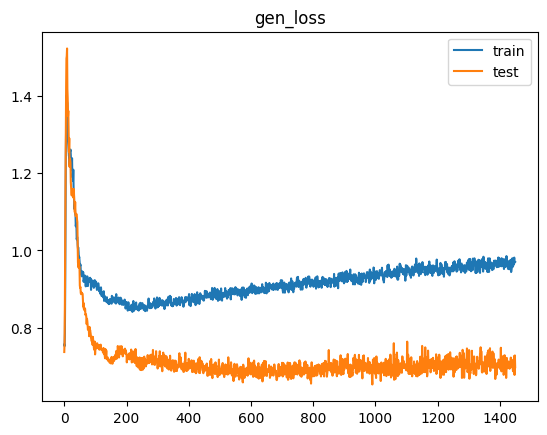

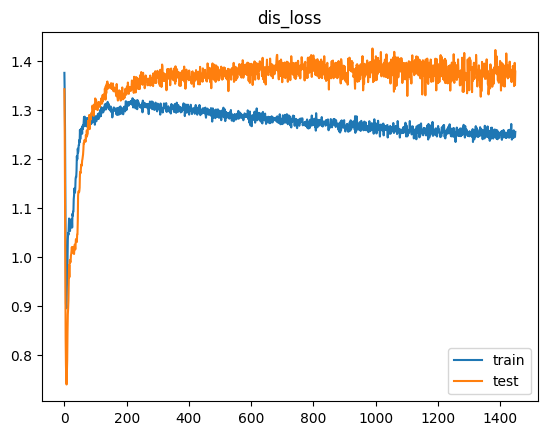

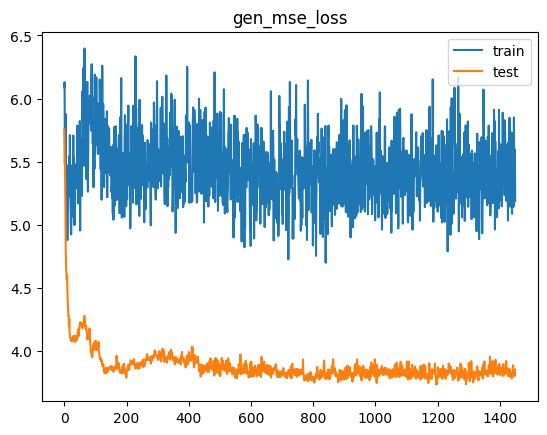

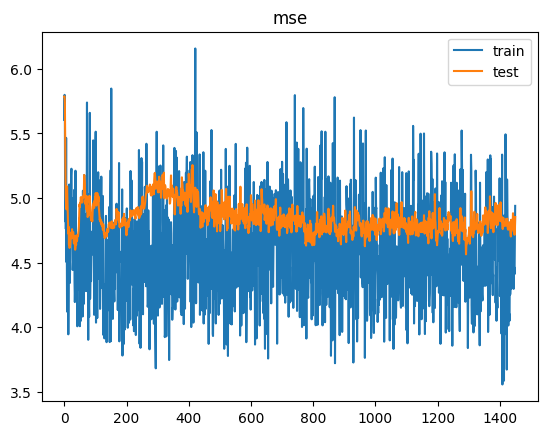

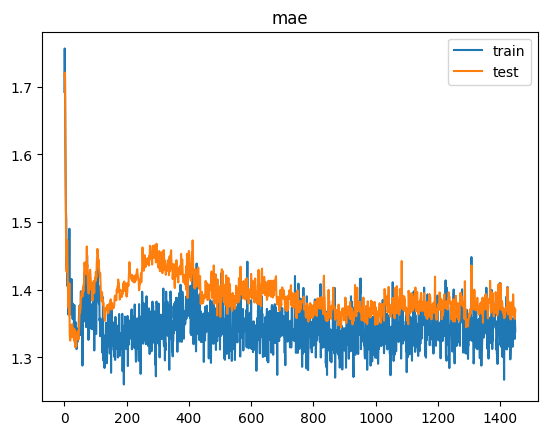

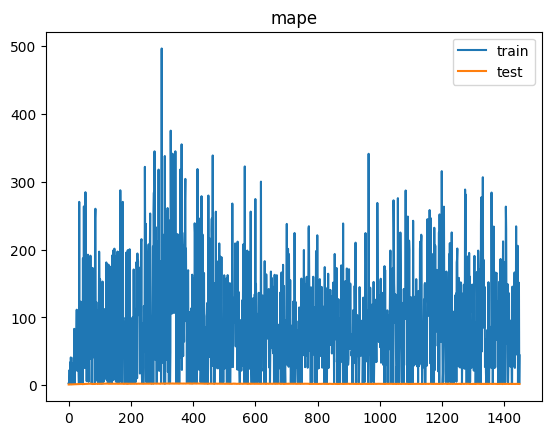

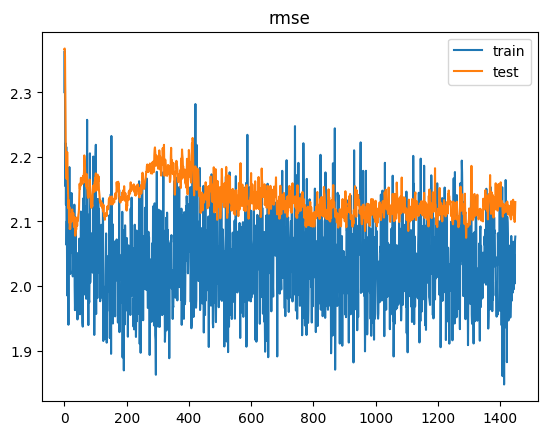

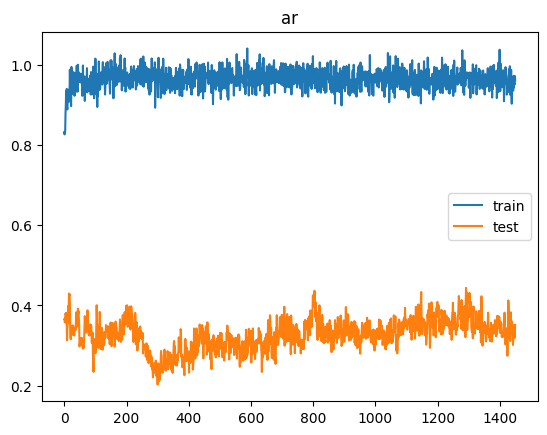

2/2 [==============================] - 0s 8ms/step


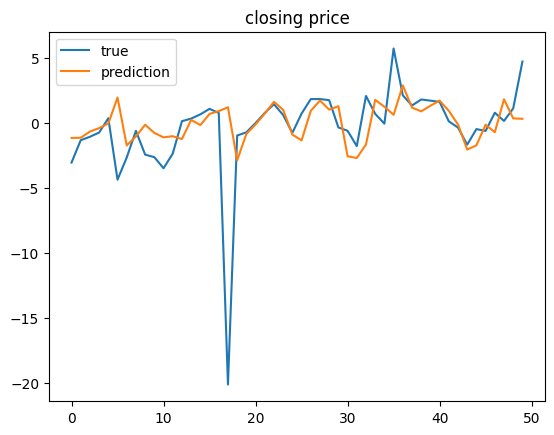

[MSE Baseline] train: 4.399642659943936  test: 4.695498675820508
Delta time with epochs = 1450: 0:25:08.206425
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 5, 10)             180       
                                                                 
 batch_normalization_12 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_13

Time for epoch 52 is 1.3910534381866455 sec Generator Loss: 1.0565954446792603,  Discriminator_loss: 1.1838563680648804
Time for epoch 53 is 1.2525970935821533 sec Generator Loss: 1.0539288520812988,  Discriminator_loss: 1.179012417793274
Time for epoch 54 is 1.2062397003173828 sec Generator Loss: 1.0401843786239624,  Discriminator_loss: 1.1999439001083374
Time for epoch 55 is 1.3637895584106445 sec Generator Loss: 1.0384777784347534,  Discriminator_loss: 1.2012677192687988
Time for epoch 56 is 1.4962646961212158 sec Generator Loss: 1.0467031002044678,  Discriminator_loss: 1.176878809928894
Time for epoch 57 is 1.1547508239746094 sec Generator Loss: 1.0270832777023315,  Discriminator_loss: 1.2017954587936401
Time for epoch 58 is 1.2801704406738281 sec Generator Loss: 1.0243842601776123,  Discriminator_loss: 1.186845302581787
Time for epoch 59 is 1.299738883972168 sec Generator Loss: 1.0318981409072876,  Discriminator_loss: 1.1974092721939087
Time for epoch 60 is 1.236358880996704 sec G

Time for epoch 121 is 1.0821912288665771 sec Generator Loss: 0.9174035787582397,  Discriminator_loss: 1.268046498298645
Time for epoch 122 is 1.28597092628479 sec Generator Loss: 0.9208033084869385,  Discriminator_loss: 1.2761653661727905
Time for epoch 123 is 1.2716155052185059 sec Generator Loss: 0.9326665997505188,  Discriminator_loss: 1.2479742765426636
Time for epoch 124 is 1.156235694885254 sec Generator Loss: 0.9303114414215088,  Discriminator_loss: 1.262860894203186
Time for epoch 125 is 1.1127099990844727 sec Generator Loss: 0.9208296537399292,  Discriminator_loss: 1.2569012641906738
Time for epoch 126 is 1.4697394371032715 sec Generator Loss: 0.9312158226966858,  Discriminator_loss: 1.2649973630905151
Time for epoch 127 is 1.741382122039795 sec Generator Loss: 0.9292885065078735,  Discriminator_loss: 1.2660351991653442
Time for epoch 128 is 1.2457103729248047 sec Generator Loss: 0.918321430683136,  Discriminator_loss: 1.2672855854034424
Time for epoch 129 is 1.199032306671142

Time for epoch 190 is 1.2216193675994873 sec Generator Loss: 0.8829604387283325,  Discriminator_loss: 1.2936517000198364
Time for epoch 191 is 1.284438133239746 sec Generator Loss: 0.8740395903587341,  Discriminator_loss: 1.2819856405258179
Time for epoch 192 is 1.4135825634002686 sec Generator Loss: 0.8847926259040833,  Discriminator_loss: 1.2952011823654175
Time for epoch 193 is 1.3300809860229492 sec Generator Loss: 0.8761895298957825,  Discriminator_loss: 1.2858073711395264
Time for epoch 194 is 1.354907751083374 sec Generator Loss: 0.8821032643318176,  Discriminator_loss: 1.2931783199310303
Time for epoch 195 is 1.3572218418121338 sec Generator Loss: 0.8661569356918335,  Discriminator_loss: 1.2969056367874146
Time for epoch 196 is 1.511308193206787 sec Generator Loss: 0.8859811425209045,  Discriminator_loss: 1.2825573682785034
Time for epoch 197 is 1.5266757011413574 sec Generator Loss: 0.8791569471359253,  Discriminator_loss: 1.2955405712127686
Time for epoch 198 is 1.54803991317

Time for epoch 259 is 1.1894564628601074 sec Generator Loss: 0.8749985694885254,  Discriminator_loss: 1.295897126197815
Time for epoch 260 is 1.2418968677520752 sec Generator Loss: 0.8638066053390503,  Discriminator_loss: 1.3005329370498657
Time for epoch 261 is 1.2145044803619385 sec Generator Loss: 0.8704400062561035,  Discriminator_loss: 1.2999131679534912
Time for epoch 262 is 1.1930017471313477 sec Generator Loss: 0.8792209029197693,  Discriminator_loss: 1.2892143726348877
Time for epoch 263 is 1.1929969787597656 sec Generator Loss: 0.8703041076660156,  Discriminator_loss: 1.2947417497634888
Time for epoch 264 is 1.1729803085327148 sec Generator Loss: 0.876499593257904,  Discriminator_loss: 1.2823914289474487
Time for epoch 265 is 1.1238679885864258 sec Generator Loss: 0.881181538105011,  Discriminator_loss: 1.2792733907699585
Time for epoch 266 is 1.13718581199646 sec Generator Loss: 0.8607571721076965,  Discriminator_loss: 1.2961498498916626
Time for epoch 267 is 1.1681334972381

Time for epoch 328 is 1.309255838394165 sec Generator Loss: 0.8779292106628418,  Discriminator_loss: 1.2850115299224854
Time for epoch 329 is 1.2527456283569336 sec Generator Loss: 0.9042931795120239,  Discriminator_loss: 1.2744140625
Time for epoch 330 is 1.2765405178070068 sec Generator Loss: 0.8988978266716003,  Discriminator_loss: 1.2823373079299927
Time for epoch 331 is 1.2918963432312012 sec Generator Loss: 0.8859843015670776,  Discriminator_loss: 1.2856063842773438
Time for epoch 332 is 1.257551908493042 sec Generator Loss: 0.8930696845054626,  Discriminator_loss: 1.2866069078445435
Time for epoch 333 is 1.1977989673614502 sec Generator Loss: 0.8883563876152039,  Discriminator_loss: 1.2850730419158936
Time for epoch 334 is 1.374746322631836 sec Generator Loss: 0.8868043422698975,  Discriminator_loss: 1.2815841436386108
Time for epoch 335 is 1.3893303871154785 sec Generator Loss: 0.8899928331375122,  Discriminator_loss: 1.2813618183135986
Time for epoch 336 is 1.293168067932129 s

Time for epoch 397 is 1.2093369960784912 sec Generator Loss: 0.9078649282455444,  Discriminator_loss: 1.2821084260940552
Time for epoch 398 is 1.211838722229004 sec Generator Loss: 0.913547158241272,  Discriminator_loss: 1.2697924375534058
Time for epoch 399 is 1.1657943725585938 sec Generator Loss: 0.9037213921546936,  Discriminator_loss: 1.271626591682434
Time for epoch 400 is 1.2460896968841553 sec Generator Loss: 0.8874868154525757,  Discriminator_loss: 1.2951717376708984
Time for epoch 401 is 1.3620026111602783 sec Generator Loss: 0.9081614017486572,  Discriminator_loss: 1.2842319011688232
Time for epoch 402 is 1.1595046520233154 sec Generator Loss: 0.8974828720092773,  Discriminator_loss: 1.2782138586044312
Time for epoch 403 is 1.1939036846160889 sec Generator Loss: 0.8814780712127686,  Discriminator_loss: 1.2854095697402954
Time for epoch 404 is 1.1807682514190674 sec Generator Loss: 0.8934488892555237,  Discriminator_loss: 1.2805966138839722
Time for epoch 405 is 1.29294800758

Time for epoch 466 is 1.2458765506744385 sec Generator Loss: 0.9055891633033752,  Discriminator_loss: 1.2771031856536865
Time for epoch 467 is 1.2816762924194336 sec Generator Loss: 0.9068103432655334,  Discriminator_loss: 1.2701261043548584
Time for epoch 468 is 1.1892170906066895 sec Generator Loss: 0.9082368612289429,  Discriminator_loss: 1.2772036790847778
Time for epoch 469 is 1.2811176776885986 sec Generator Loss: 0.9113637208938599,  Discriminator_loss: 1.275796890258789
Time for epoch 470 is 1.2376439571380615 sec Generator Loss: 0.9209976196289062,  Discriminator_loss: 1.2747708559036255
Time for epoch 471 is 1.302342176437378 sec Generator Loss: 0.912463366985321,  Discriminator_loss: 1.2780684232711792
Time for epoch 472 is 1.2960844039916992 sec Generator Loss: 0.9074887633323669,  Discriminator_loss: 1.2830991744995117
Time for epoch 473 is 1.3527867794036865 sec Generator Loss: 0.8992913365364075,  Discriminator_loss: 1.2807286977767944
Time for epoch 474 is 1.28930807113

Time for epoch 535 is 1.1763253211975098 sec Generator Loss: 0.9165182709693909,  Discriminator_loss: 1.2768537998199463
Time for epoch 536 is 1.1810498237609863 sec Generator Loss: 0.9147576689720154,  Discriminator_loss: 1.2786593437194824
Time for epoch 537 is 1.2186224460601807 sec Generator Loss: 0.9141426682472229,  Discriminator_loss: 1.280773401260376
Time for epoch 538 is 1.1996221542358398 sec Generator Loss: 0.9227621555328369,  Discriminator_loss: 1.2628395557403564
Time for epoch 539 is 1.1959269046783447 sec Generator Loss: 0.9127280116081238,  Discriminator_loss: 1.2801129817962646
Time for epoch 540 is 1.1727595329284668 sec Generator Loss: 0.905591607093811,  Discriminator_loss: 1.2844898700714111
Time for epoch 541 is 1.240680456161499 sec Generator Loss: 0.9161122441291809,  Discriminator_loss: 1.260162591934204
Time for epoch 542 is 1.2194445133209229 sec Generator Loss: 0.9269509315490723,  Discriminator_loss: 1.2734681367874146
Time for epoch 543 is 1.160700082778

Time for epoch 604 is 1.1951425075531006 sec Generator Loss: 0.9338099360466003,  Discriminator_loss: 1.281984567642212
Time for epoch 605 is 1.2541773319244385 sec Generator Loss: 0.917016863822937,  Discriminator_loss: 1.2721951007843018
Time for epoch 606 is 1.2658162117004395 sec Generator Loss: 0.9300891757011414,  Discriminator_loss: 1.2701054811477661
Time for epoch 607 is 1.2451050281524658 sec Generator Loss: 0.9372022747993469,  Discriminator_loss: 1.2697224617004395
Time for epoch 608 is 1.3077566623687744 sec Generator Loss: 0.9260810017585754,  Discriminator_loss: 1.2722508907318115
Time for epoch 609 is 1.214871883392334 sec Generator Loss: 0.9311155676841736,  Discriminator_loss: 1.268659234046936
Time for epoch 610 is 1.3011915683746338 sec Generator Loss: 0.9231551885604858,  Discriminator_loss: 1.2699588537216187
Time for epoch 611 is 1.2480676174163818 sec Generator Loss: 0.9364963173866272,  Discriminator_loss: 1.2607436180114746
Time for epoch 612 is 1.249670982360

Time for epoch 673 is 1.200089454650879 sec Generator Loss: 0.9287756681442261,  Discriminator_loss: 1.260572910308838
Time for epoch 674 is 1.2622132301330566 sec Generator Loss: 0.9314872026443481,  Discriminator_loss: 1.2654176950454712
Time for epoch 675 is 1.175316333770752 sec Generator Loss: 0.9430935978889465,  Discriminator_loss: 1.2579764127731323
Time for epoch 676 is 1.278710126876831 sec Generator Loss: 0.9470500349998474,  Discriminator_loss: 1.2607014179229736
Time for epoch 677 is 1.2446064949035645 sec Generator Loss: 0.9286831021308899,  Discriminator_loss: 1.27323579788208
Time for epoch 678 is 1.151341438293457 sec Generator Loss: 0.9317188262939453,  Discriminator_loss: 1.2613389492034912
Time for epoch 679 is 1.1571850776672363 sec Generator Loss: 0.9259547591209412,  Discriminator_loss: 1.268553376197815
Time for epoch 680 is 1.1469738483428955 sec Generator Loss: 0.938993513584137,  Discriminator_loss: 1.262390375137329
Time for epoch 681 is 1.1209092140197754 s

Time for epoch 742 is 1.409691572189331 sec Generator Loss: 0.9447844624519348,  Discriminator_loss: 1.268425703048706
Time for epoch 743 is 1.208068609237671 sec Generator Loss: 0.937013566493988,  Discriminator_loss: 1.2591532468795776
Time for epoch 744 is 1.2023382186889648 sec Generator Loss: 0.9533967971801758,  Discriminator_loss: 1.262001395225525
Time for epoch 745 is 1.213651418685913 sec Generator Loss: 0.9365199208259583,  Discriminator_loss: 1.2714474201202393
Time for epoch 746 is 1.2434589862823486 sec Generator Loss: 0.9429722428321838,  Discriminator_loss: 1.2701358795166016
Time for epoch 747 is 1.1541550159454346 sec Generator Loss: 0.9503939747810364,  Discriminator_loss: 1.2596523761749268
Time for epoch 748 is 1.268078088760376 sec Generator Loss: 0.9461064338684082,  Discriminator_loss: 1.2657122611999512
Time for epoch 749 is 1.2990996837615967 sec Generator Loss: 0.9255712032318115,  Discriminator_loss: 1.2736297845840454
Time for epoch 750 is 1.354975461959838

In [ ]:
for epochs in [200, 450, 700, 950, 1200, 1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 5, 10)             180       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                             

Time for epoch 53 is 0.6060106754302979 sec Generator Loss: 1.0967257022857666,  Discriminator_loss: 1.1420069932937622
Time for epoch 54 is 0.621344804763794 sec Generator Loss: 1.0892657041549683,  Discriminator_loss: 1.1554738283157349
Time for epoch 55 is 0.6277973651885986 sec Generator Loss: 1.0691488981246948,  Discriminator_loss: 1.1652204990386963
Time for epoch 56 is 0.6175248622894287 sec Generator Loss: 1.0681623220443726,  Discriminator_loss: 1.1685341596603394
Time for epoch 57 is 0.6749424934387207 sec Generator Loss: 1.044352412223816,  Discriminator_loss: 1.1961960792541504
Time for epoch 58 is 0.627479076385498 sec Generator Loss: 1.0300854444503784,  Discriminator_loss: 1.1802518367767334
Time for epoch 59 is 0.6057322025299072 sec Generator Loss: 1.0155211687088013,  Discriminator_loss: 1.197306752204895
Time for epoch 60 is 0.6036787033081055 sec Generator Loss: 1.0334402322769165,  Discriminator_loss: 1.1977869272232056
Time for epoch 61 is 0.6039810180664062 sec 

Time for epoch 122 is 0.6166341304779053 sec Generator Loss: 0.8912530541419983,  Discriminator_loss: 1.2892680168151855
Time for epoch 123 is 0.6175127029418945 sec Generator Loss: 0.9031813144683838,  Discriminator_loss: 1.2870314121246338
Time for epoch 124 is 0.621145486831665 sec Generator Loss: 0.8974529504776001,  Discriminator_loss: 1.2894572019577026
Time for epoch 125 is 0.6170287132263184 sec Generator Loss: 0.898081362247467,  Discriminator_loss: 1.274678349494934
Time for epoch 126 is 0.6722936630249023 sec Generator Loss: 0.8917408585548401,  Discriminator_loss: 1.2856168746948242
Time for epoch 127 is 0.6097826957702637 sec Generator Loss: 0.8817461729049683,  Discriminator_loss: 1.2999532222747803
Time for epoch 128 is 0.6569533348083496 sec Generator Loss: 0.89173823595047,  Discriminator_loss: 1.2927193641662598
Time for epoch 129 is 0.6153848171234131 sec Generator Loss: 0.8891361355781555,  Discriminator_loss: 1.2953568696975708
Time for epoch 130 is 0.6545290946960

Time for epoch 191 is 0.7279245853424072 sec Generator Loss: 0.8634130358695984,  Discriminator_loss: 1.2886329889297485
Time for epoch 192 is 0.6918833255767822 sec Generator Loss: 0.8597874641418457,  Discriminator_loss: 1.291563868522644
Time for epoch 193 is 0.7455728054046631 sec Generator Loss: 0.8661290407180786,  Discriminator_loss: 1.3019424676895142
Time for epoch 194 is 0.6485559940338135 sec Generator Loss: 0.8606692552566528,  Discriminator_loss: 1.2963923215866089
Time for epoch 195 is 0.6516954898834229 sec Generator Loss: 0.870112419128418,  Discriminator_loss: 1.2906625270843506
Time for epoch 196 is 0.6657571792602539 sec Generator Loss: 0.8698329329490662,  Discriminator_loss: 1.3008853197097778
Time for epoch 197 is 0.8764960765838623 sec Generator Loss: 0.8687875866889954,  Discriminator_loss: 1.2862964868545532
Time for epoch 198 is 0.7231740951538086 sec Generator Loss: 0.8796458840370178,  Discriminator_loss: 1.2868953943252563
Time for epoch 199 is 0.7253711223

Time for epoch 259 is 0.649092435836792 sec Generator Loss: 0.8819353580474854,  Discriminator_loss: 1.2919526100158691
Time for epoch 260 is 0.6592028141021729 sec Generator Loss: 0.8751447200775146,  Discriminator_loss: 1.284169316291809
Time for epoch 261 is 0.6516842842102051 sec Generator Loss: 0.8758432865142822,  Discriminator_loss: 1.292536973953247
Time for epoch 262 is 0.6642229557037354 sec Generator Loss: 0.8698152303695679,  Discriminator_loss: 1.2910820245742798
Time for epoch 263 is 0.6429345607757568 sec Generator Loss: 0.8804367184638977,  Discriminator_loss: 1.289115071296692
Time for epoch 264 is 0.638664722442627 sec Generator Loss: 0.867736279964447,  Discriminator_loss: 1.304391860961914
Time for epoch 265 is 0.6598272323608398 sec Generator Loss: 0.8649901151657104,  Discriminator_loss: 1.305044174194336
Time for epoch 266 is 0.6479310989379883 sec Generator Loss: 0.8685392141342163,  Discriminator_loss: 1.2984561920166016
Time for epoch 267 is 0.6501133441925049

Time for epoch 328 is 0.6437764167785645 sec Generator Loss: 0.8844075202941895,  Discriminator_loss: 1.288803219795227
Time for epoch 329 is 0.6505739688873291 sec Generator Loss: 0.8744567036628723,  Discriminator_loss: 1.2977913618087769
Time for epoch 330 is 0.6475510597229004 sec Generator Loss: 0.8888011574745178,  Discriminator_loss: 1.2803982496261597
Time for epoch 331 is 0.6444253921508789 sec Generator Loss: 0.8878450393676758,  Discriminator_loss: 1.2873377799987793
Time for epoch 332 is 0.6475005149841309 sec Generator Loss: 0.8966144919395447,  Discriminator_loss: 1.2730640172958374
Time for epoch 333 is 0.6439416408538818 sec Generator Loss: 0.8822023868560791,  Discriminator_loss: 1.2798532247543335
Time for epoch 334 is 0.6453325748443604 sec Generator Loss: 0.8931926488876343,  Discriminator_loss: 1.277996301651001
Time for epoch 335 is 0.6384906768798828 sec Generator Loss: 0.9001080989837646,  Discriminator_loss: 1.2715716361999512
Time for epoch 336 is 0.6444573402

Time for epoch 396 is 0.660597562789917 sec Generator Loss: 0.8926690816879272,  Discriminator_loss: 1.2797375917434692
Time for epoch 397 is 0.6407508850097656 sec Generator Loss: 0.8905237317085266,  Discriminator_loss: 1.2828269004821777
Time for epoch 398 is 0.6434850692749023 sec Generator Loss: 0.8966617584228516,  Discriminator_loss: 1.274762511253357
Time for epoch 399 is 0.6489810943603516 sec Generator Loss: 0.9014717936515808,  Discriminator_loss: 1.2847901582717896
Time for epoch 400 is 0.6441779136657715 sec Generator Loss: 0.8853237628936768,  Discriminator_loss: 1.2910068035125732
Time for epoch 401 is 0.6394767761230469 sec Generator Loss: 0.8960903882980347,  Discriminator_loss: 1.277173638343811
Time for epoch 402 is 0.6414952278137207 sec Generator Loss: 0.8778154850006104,  Discriminator_loss: 1.2908223867416382
Time for epoch 403 is 0.6517977714538574 sec Generator Loss: 0.8932502269744873,  Discriminator_loss: 1.2862111330032349
Time for epoch 404 is 0.63636898994

Time for epoch 464 is 0.6474308967590332 sec Generator Loss: 0.889468252658844,  Discriminator_loss: 1.2818933725357056
Time for epoch 465 is 0.6482534408569336 sec Generator Loss: 0.9046768546104431,  Discriminator_loss: 1.275789737701416
Time for epoch 466 is 0.6510262489318848 sec Generator Loss: 0.8936694860458374,  Discriminator_loss: 1.2844483852386475
Time for epoch 467 is 0.653541088104248 sec Generator Loss: 0.8938193917274475,  Discriminator_loss: 1.2810702323913574
Time for epoch 468 is 0.6444039344787598 sec Generator Loss: 0.9067943096160889,  Discriminator_loss: 1.2784966230392456
Time for epoch 469 is 0.6395599842071533 sec Generator Loss: 0.8946998119354248,  Discriminator_loss: 1.2812159061431885
Time for epoch 470 is 0.6395931243896484 sec Generator Loss: 0.8986539244651794,  Discriminator_loss: 1.283621072769165
Time for epoch 471 is 0.6374688148498535 sec Generator Loss: 0.8893130421638489,  Discriminator_loss: 1.2803603410720825
Time for epoch 472 is 0.662362575531

Time for epoch 532 is 0.7137651443481445 sec Generator Loss: 0.878430962562561,  Discriminator_loss: 1.2938929796218872
Time for epoch 533 is 0.746882438659668 sec Generator Loss: 0.8865393996238708,  Discriminator_loss: 1.2883509397506714
Time for epoch 534 is 0.6424775123596191 sec Generator Loss: 0.8867111206054688,  Discriminator_loss: 1.2896246910095215
Time for epoch 535 is 0.7035317420959473 sec Generator Loss: 0.8905808925628662,  Discriminator_loss: 1.275344967842102
Time for epoch 536 is 0.6956734657287598 sec Generator Loss: 0.8859500885009766,  Discriminator_loss: 1.2855929136276245
Time for epoch 537 is 0.6456921100616455 sec Generator Loss: 0.892818808555603,  Discriminator_loss: 1.2823851108551025
Time for epoch 538 is 0.721813440322876 sec Generator Loss: 0.8930127620697021,  Discriminator_loss: 1.2812126874923706
Time for epoch 539 is 0.7150735855102539 sec Generator Loss: 0.8879124522209167,  Discriminator_loss: 1.2863340377807617
Time for epoch 540 is 0.6994752883911

Time for epoch 600 is 0.6416571140289307 sec Generator Loss: 0.9057040214538574,  Discriminator_loss: 1.2779057025909424
Time for epoch 601 is 0.6334254741668701 sec Generator Loss: 0.8876584768295288,  Discriminator_loss: 1.2877691984176636
Time for epoch 602 is 0.6424145698547363 sec Generator Loss: 0.8929874300956726,  Discriminator_loss: 1.283171534538269
Time for epoch 603 is 0.644324541091919 sec Generator Loss: 0.8910883665084839,  Discriminator_loss: 1.2879705429077148
Time for epoch 604 is 0.6400504112243652 sec Generator Loss: 0.8815665245056152,  Discriminator_loss: 1.2986836433410645
Time for epoch 605 is 0.658531904220581 sec Generator Loss: 0.8799933195114136,  Discriminator_loss: 1.2971813678741455
Time for epoch 606 is 0.6425318717956543 sec Generator Loss: 0.8903099894523621,  Discriminator_loss: 1.2838629484176636
Time for epoch 607 is 0.6403582096099854 sec Generator Loss: 0.8742833137512207,  Discriminator_loss: 1.2914701700210571
Time for epoch 608 is 0.63740968704

Time for epoch 668 is 0.6364481449127197 sec Generator Loss: 0.8934689164161682,  Discriminator_loss: 1.2812609672546387
Time for epoch 669 is 0.6444470882415771 sec Generator Loss: 0.8872703313827515,  Discriminator_loss: 1.2911274433135986
Time for epoch 670 is 0.6415791511535645 sec Generator Loss: 0.8978496193885803,  Discriminator_loss: 1.2789463996887207
Time for epoch 671 is 0.647815465927124 sec Generator Loss: 0.87743079662323,  Discriminator_loss: 1.2879270315170288
Time for epoch 672 is 0.6471011638641357 sec Generator Loss: 0.8951945900917053,  Discriminator_loss: 1.2855676412582397
Time for epoch 673 is 0.7342586517333984 sec Generator Loss: 0.885381817817688,  Discriminator_loss: 1.2780647277832031
Time for epoch 674 is 0.6953771114349365 sec Generator Loss: 0.8817757368087769,  Discriminator_loss: 1.299443006515503
Time for epoch 675 is 0.6844828128814697 sec Generator Loss: 0.8841807842254639,  Discriminator_loss: 1.2821756601333618
Time for epoch 676 is 0.6869492530822

Time for epoch 737 is 0.6415412425994873 sec Generator Loss: 0.8993968367576599,  Discriminator_loss: 1.271864652633667
Time for epoch 738 is 0.6506109237670898 sec Generator Loss: 0.8979592323303223,  Discriminator_loss: 1.2946782112121582
Time for epoch 739 is 0.6399884223937988 sec Generator Loss: 0.9027239680290222,  Discriminator_loss: 1.2783317565917969
Time for epoch 740 is 0.63482666015625 sec Generator Loss: 0.8890721201896667,  Discriminator_loss: 1.2841475009918213
Time for epoch 741 is 0.6439635753631592 sec Generator Loss: 0.8969094753265381,  Discriminator_loss: 1.2872706651687622
Time for epoch 742 is 0.6496527194976807 sec Generator Loss: 0.8715701103210449,  Discriminator_loss: 1.3027361631393433
Time for epoch 743 is 0.6448974609375 sec Generator Loss: 0.8950074315071106,  Discriminator_loss: 1.2900398969650269
Time for epoch 744 is 0.6413273811340332 sec Generator Loss: 0.8886885643005371,  Discriminator_loss: 1.28053879737854
Time for epoch 745 is 0.6392076015472412

Time for epoch 806 is 0.640718936920166 sec Generator Loss: 0.9052832126617432,  Discriminator_loss: 1.2789092063903809
Time for epoch 807 is 0.6399264335632324 sec Generator Loss: 0.8958102464675903,  Discriminator_loss: 1.2820720672607422
Time for epoch 808 is 0.6351864337921143 sec Generator Loss: 0.9010404348373413,  Discriminator_loss: 1.2795560359954834
Time for epoch 809 is 0.6439433097839355 sec Generator Loss: 0.8949362635612488,  Discriminator_loss: 1.288399338722229
Time for epoch 810 is 0.6487846374511719 sec Generator Loss: 0.8954816460609436,  Discriminator_loss: 1.2836716175079346
Time for epoch 811 is 0.648432731628418 sec Generator Loss: 0.9025837779045105,  Discriminator_loss: 1.2816394567489624
Time for epoch 812 is 0.6905803680419922 sec Generator Loss: 0.9028998017311096,  Discriminator_loss: 1.264487624168396
Time for epoch 813 is 0.6436386108398438 sec Generator Loss: 0.8936627507209778,  Discriminator_loss: 1.2876708507537842
Time for epoch 814 is 0.640751361846

Time for epoch 874 is 0.8062317371368408 sec Generator Loss: 0.895545244216919,  Discriminator_loss: 1.2715978622436523
Time for epoch 875 is 0.7529306411743164 sec Generator Loss: 0.902563750743866,  Discriminator_loss: 1.2815488576889038
Time for epoch 876 is 0.6806445121765137 sec Generator Loss: 0.9062968492507935,  Discriminator_loss: 1.270342230796814
Time for epoch 877 is 0.7832880020141602 sec Generator Loss: 0.905193030834198,  Discriminator_loss: 1.2743600606918335
Time for epoch 878 is 0.8305008411407471 sec Generator Loss: 0.9151992201805115,  Discriminator_loss: 1.268837571144104
Time for epoch 879 is 0.7347288131713867 sec Generator Loss: 0.8948107957839966,  Discriminator_loss: 1.2867863178253174
Time for epoch 880 is 0.6630845069885254 sec Generator Loss: 0.9089435338973999,  Discriminator_loss: 1.2596895694732666
Time for epoch 881 is 0.6632297039031982 sec Generator Loss: 0.9204269647598267,  Discriminator_loss: 1.2669429779052734
Time for epoch 882 is 0.6455240249633

Time for epoch 942 is 0.6427855491638184 sec Generator Loss: 0.930438220500946,  Discriminator_loss: 1.2498458623886108
Time for epoch 943 is 0.7303388118743896 sec Generator Loss: 0.9150377511978149,  Discriminator_loss: 1.2748178243637085
Time for epoch 944 is 0.7179806232452393 sec Generator Loss: 0.8977512121200562,  Discriminator_loss: 1.2800127267837524
Time for epoch 945 is 0.7250118255615234 sec Generator Loss: 0.9125881791114807,  Discriminator_loss: 1.2693185806274414
Time for epoch 946 is 0.6480684280395508 sec Generator Loss: 0.9084113836288452,  Discriminator_loss: 1.2794498205184937
Time for epoch 947 is 0.679443359375 sec Generator Loss: 0.9107245802879333,  Discriminator_loss: 1.2805324792861938
Time for epoch 948 is 0.689068078994751 sec Generator Loss: 0.9079127311706543,  Discriminator_loss: 1.2709615230560303
Time for epoch 949 is 0.6390106678009033 sec Generator Loss: 0.9173197746276855,  Discriminator_loss: 1.2657837867736816
Time for epoch 950 is 0.69305062294006

Time for epoch 1010 is 0.6432170867919922 sec Generator Loss: 0.9029710292816162,  Discriminator_loss: 1.2747808694839478
Time for epoch 1011 is 0.6522488594055176 sec Generator Loss: 0.9125415086746216,  Discriminator_loss: 1.2742104530334473
Time for epoch 1012 is 0.6551685333251953 sec Generator Loss: 0.9139333367347717,  Discriminator_loss: 1.267327904701233
Time for epoch 1013 is 0.6443660259246826 sec Generator Loss: 0.9150092005729675,  Discriminator_loss: 1.2689543962478638
Time for epoch 1014 is 0.6410183906555176 sec Generator Loss: 0.9152281880378723,  Discriminator_loss: 1.269099473953247
Time for epoch 1015 is 0.6473519802093506 sec Generator Loss: 0.910274088382721,  Discriminator_loss: 1.2635512351989746
Time for epoch 1016 is 0.6415424346923828 sec Generator Loss: 0.918847918510437,  Discriminator_loss: 1.2665843963623047
Time for epoch 1017 is 0.6652183532714844 sec Generator Loss: 0.8977212309837341,  Discriminator_loss: 1.2745702266693115
Time for epoch 1018 is 0.649

Time for epoch 1078 is 0.7925653457641602 sec Generator Loss: 0.9131297469139099,  Discriminator_loss: 1.2667721509933472
Time for epoch 1079 is 0.8473117351531982 sec Generator Loss: 0.9136046171188354,  Discriminator_loss: 1.2608495950698853
Time for epoch 1080 is 0.7037365436553955 sec Generator Loss: 0.9278652667999268,  Discriminator_loss: 1.2520650625228882
Time for epoch 1081 is 0.6918532848358154 sec Generator Loss: 0.9317439794540405,  Discriminator_loss: 1.2584136724472046
Time for epoch 1082 is 0.6873245239257812 sec Generator Loss: 0.9304776191711426,  Discriminator_loss: 1.2569209337234497
Time for epoch 1083 is 0.6718947887420654 sec Generator Loss: 0.9131990075111389,  Discriminator_loss: 1.273013949394226
Time for epoch 1084 is 0.6861269474029541 sec Generator Loss: 0.9158949255943298,  Discriminator_loss: 1.2632925510406494
Time for epoch 1085 is 0.6673843860626221 sec Generator Loss: 0.9244689345359802,  Discriminator_loss: 1.25740647315979
Time for epoch 1086 is 0.67

Time for epoch 1146 is 0.6450886726379395 sec Generator Loss: 0.9183568954467773,  Discriminator_loss: 1.2707185745239258
Time for epoch 1147 is 0.6812443733215332 sec Generator Loss: 0.9194663166999817,  Discriminator_loss: 1.2535672187805176
Time for epoch 1148 is 0.6936371326446533 sec Generator Loss: 0.922140896320343,  Discriminator_loss: 1.270065188407898
Time for epoch 1149 is 0.6940181255340576 sec Generator Loss: 0.9262217879295349,  Discriminator_loss: 1.2697114944458008
Time for epoch 1150 is 0.6449599266052246 sec Generator Loss: 0.9129447340965271,  Discriminator_loss: 1.273898720741272
Time for epoch 1151 is 0.6528515815734863 sec Generator Loss: 0.9132621884346008,  Discriminator_loss: 1.2655576467514038
Time for epoch 1152 is 0.6409034729003906 sec Generator Loss: 0.9196821451187134,  Discriminator_loss: 1.2636263370513916
Time for epoch 1153 is 0.6483414173126221 sec Generator Loss: 0.9306421279907227,  Discriminator_loss: 1.2524653673171997
Time for epoch 1154 is 0.65

Time for epoch 1214 is 0.646418571472168 sec Generator Loss: 0.9208946824073792,  Discriminator_loss: 1.2647705078125
Time for epoch 1215 is 0.6458859443664551 sec Generator Loss: 0.9129158854484558,  Discriminator_loss: 1.2664976119995117
Time for epoch 1216 is 0.646714448928833 sec Generator Loss: 0.9146742820739746,  Discriminator_loss: 1.2590794563293457
Time for epoch 1217 is 0.6456518173217773 sec Generator Loss: 0.9359603524208069,  Discriminator_loss: 1.2460325956344604
Time for epoch 1218 is 0.6506533622741699 sec Generator Loss: 0.9297634363174438,  Discriminator_loss: 1.2543696165084839
Time for epoch 1219 is 0.6488099098205566 sec Generator Loss: 0.9235551953315735,  Discriminator_loss: 1.2614636421203613
Time for epoch 1220 is 0.6591074466705322 sec Generator Loss: 0.9327683448791504,  Discriminator_loss: 1.2564210891723633
Time for epoch 1221 is 0.6557066440582275 sec Generator Loss: 0.9376320838928223,  Discriminator_loss: 1.2616004943847656
Time for epoch 1222 is 0.6444

Time for epoch 1282 is 0.678267240524292 sec Generator Loss: 0.9340311288833618,  Discriminator_loss: 1.268889307975769
Time for epoch 1283 is 0.6463274955749512 sec Generator Loss: 0.9397624731063843,  Discriminator_loss: 1.2558071613311768
Time for epoch 1284 is 0.6629126071929932 sec Generator Loss: 0.931572675704956,  Discriminator_loss: 1.2525298595428467
Time for epoch 1285 is 0.6545765399932861 sec Generator Loss: 0.9314893484115601,  Discriminator_loss: 1.2565213441848755
Time for epoch 1286 is 0.6564300060272217 sec Generator Loss: 0.9250269532203674,  Discriminator_loss: 1.2587199211120605
Time for epoch 1287 is 0.6711130142211914 sec Generator Loss: 0.931832492351532,  Discriminator_loss: 1.252195954322815
Time for epoch 1288 is 0.6536850929260254 sec Generator Loss: 0.9430376291275024,  Discriminator_loss: 1.242916226387024
Time for epoch 1289 is 0.648848295211792 sec Generator Loss: 0.932776689529419,  Discriminator_loss: 1.2603472471237183
Time for epoch 1290 is 0.6554481

Time for epoch 1350 is 0.6538498401641846 sec Generator Loss: 0.9386168122291565,  Discriminator_loss: 1.2535051107406616
Time for epoch 1351 is 0.7068302631378174 sec Generator Loss: 0.9249472618103027,  Discriminator_loss: 1.2575995922088623
Time for epoch 1352 is 0.6806278228759766 sec Generator Loss: 0.9271019697189331,  Discriminator_loss: 1.2591605186462402
Time for epoch 1353 is 0.7828428745269775 sec Generator Loss: 0.9295458793640137,  Discriminator_loss: 1.2556569576263428
Time for epoch 1354 is 0.797109842300415 sec Generator Loss: 0.9434598684310913,  Discriminator_loss: 1.2554686069488525
Time for epoch 1355 is 0.7495064735412598 sec Generator Loss: 0.9351277947425842,  Discriminator_loss: 1.2528425455093384
Time for epoch 1356 is 0.7498712539672852 sec Generator Loss: 0.9486517310142517,  Discriminator_loss: 1.243235468864441
Time for epoch 1357 is 0.826923131942749 sec Generator Loss: 0.9406893253326416,  Discriminator_loss: 1.2566168308258057
Time for epoch 1358 is 0.74

Time for epoch 1418 is 0.6531291007995605 sec Generator Loss: 0.9286479353904724,  Discriminator_loss: 1.2557110786437988
Time for epoch 1419 is 0.6673712730407715 sec Generator Loss: 0.9438773989677429,  Discriminator_loss: 1.2416400909423828
Time for epoch 1420 is 0.658226490020752 sec Generator Loss: 0.9487589001655579,  Discriminator_loss: 1.257920742034912
Time for epoch 1421 is 0.6525709629058838 sec Generator Loss: 0.9231212139129639,  Discriminator_loss: 1.266700267791748
Time for epoch 1422 is 0.6794657707214355 sec Generator Loss: 0.9441421627998352,  Discriminator_loss: 1.2522716522216797
Time for epoch 1423 is 0.6531851291656494 sec Generator Loss: 0.9453115463256836,  Discriminator_loss: 1.245990514755249
Time for epoch 1424 is 0.6468889713287354 sec Generator Loss: 0.9237862229347229,  Discriminator_loss: 1.2593213319778442
Time for epoch 1425 is 0.6451983451843262 sec Generator Loss: 0.9406606554985046,  Discriminator_loss: 1.2520166635513306
Time for epoch 1426 is 0.685

Time for epoch 1486 is 0.6539514064788818 sec Generator Loss: 0.936190664768219,  Discriminator_loss: 1.2466245889663696
Time for epoch 1487 is 0.7757248878479004 sec Generator Loss: 0.9551724195480347,  Discriminator_loss: 1.2466775178909302
Time for epoch 1488 is 0.6787922382354736 sec Generator Loss: 0.9292583465576172,  Discriminator_loss: 1.2579177618026733
Time for epoch 1489 is 0.6428816318511963 sec Generator Loss: 0.9438815116882324,  Discriminator_loss: 1.2417967319488525
Time for epoch 1490 is 0.696467399597168 sec Generator Loss: 0.9456192255020142,  Discriminator_loss: 1.2462352514266968
Time for epoch 1491 is 0.667341947555542 sec Generator Loss: 0.946434497833252,  Discriminator_loss: 1.2398735284805298
Time for epoch 1492 is 0.8573136329650879 sec Generator Loss: 0.9350854158401489,  Discriminator_loss: 1.2573086023330688
Time for epoch 1493 is 0.8818933963775635 sec Generator Loss: 0.9479589462280273,  Discriminator_loss: 1.2490884065628052
Time for epoch 1494 is 0.933

Time for epoch 1554 is 0.6619358062744141 sec Generator Loss: 0.9476209282875061,  Discriminator_loss: 1.2486952543258667
Time for epoch 1555 is 0.7423255443572998 sec Generator Loss: 0.9326595664024353,  Discriminator_loss: 1.2465760707855225
Time for epoch 1556 is 0.6973562240600586 sec Generator Loss: 0.9328278303146362,  Discriminator_loss: 1.2450209856033325
Time for epoch 1557 is 0.7054860591888428 sec Generator Loss: 0.9391414523124695,  Discriminator_loss: 1.2570277452468872
Time for epoch 1558 is 0.7116601467132568 sec Generator Loss: 0.9391047358512878,  Discriminator_loss: 1.2584466934204102
Time for epoch 1559 is 0.6907966136932373 sec Generator Loss: 0.9545645713806152,  Discriminator_loss: 1.2460278272628784
Time for epoch 1560 is 0.6639411449432373 sec Generator Loss: 0.9438397884368896,  Discriminator_loss: 1.2518084049224854
Time for epoch 1561 is 0.6674232482910156 sec Generator Loss: 0.9380894899368286,  Discriminator_loss: 1.2541173696517944
Time for epoch 1562 is 0

Time for epoch 1622 is 0.7043735980987549 sec Generator Loss: 0.9478336572647095,  Discriminator_loss: 1.2390834093093872
Time for epoch 1623 is 0.6702380180358887 sec Generator Loss: 0.9561452865600586,  Discriminator_loss: 1.2399269342422485
Time for epoch 1624 is 0.6484928131103516 sec Generator Loss: 0.9493384957313538,  Discriminator_loss: 1.2381672859191895
Time for epoch 1625 is 0.6913080215454102 sec Generator Loss: 0.959134578704834,  Discriminator_loss: 1.2526143789291382
Time for epoch 1626 is 0.6886792182922363 sec Generator Loss: 0.9440391659736633,  Discriminator_loss: 1.2546707391738892
Time for epoch 1627 is 0.7256150245666504 sec Generator Loss: 0.941898763179779,  Discriminator_loss: 1.2583369016647339
Time for epoch 1628 is 0.6823041439056396 sec Generator Loss: 0.9448142647743225,  Discriminator_loss: 1.2541236877441406
Time for epoch 1629 is 0.7048721313476562 sec Generator Loss: 0.9449824094772339,  Discriminator_loss: 1.2562248706817627
Time for epoch 1630 is 0.7

Time for epoch 1690 is 0.7811903953552246 sec Generator Loss: 0.9603093266487122,  Discriminator_loss: 1.2344410419464111
Time for epoch 1691 is 0.7600781917572021 sec Generator Loss: 0.9351020455360413,  Discriminator_loss: 1.2595280408859253
Time for epoch 1692 is 0.7355701923370361 sec Generator Loss: 0.9657266736030579,  Discriminator_loss: 1.233307957649231
Time for epoch 1693 is 0.7119734287261963 sec Generator Loss: 0.9492805600166321,  Discriminator_loss: 1.2539976835250854
Time for epoch 1694 is 0.7086730003356934 sec Generator Loss: 0.9411193132400513,  Discriminator_loss: 1.2503156661987305
Time for epoch 1695 is 0.7059288024902344 sec Generator Loss: 0.9493985176086426,  Discriminator_loss: 1.2443339824676514
Time for epoch 1696 is 0.7298119068145752 sec Generator Loss: 0.9526098370552063,  Discriminator_loss: 1.2407801151275635
Time for epoch 1697 is 0.694188117980957 sec Generator Loss: 0.9405117034912109,  Discriminator_loss: 1.247470736503601
Time for epoch 1698 is 0.68

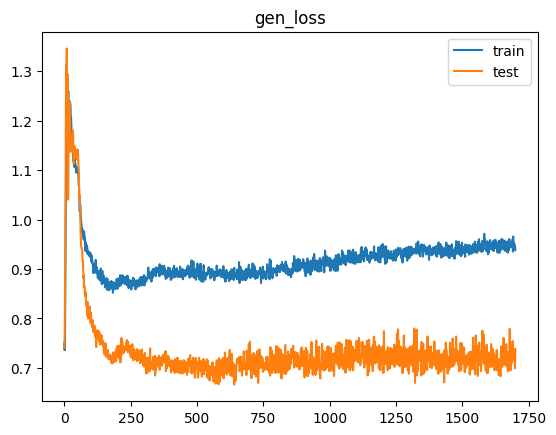

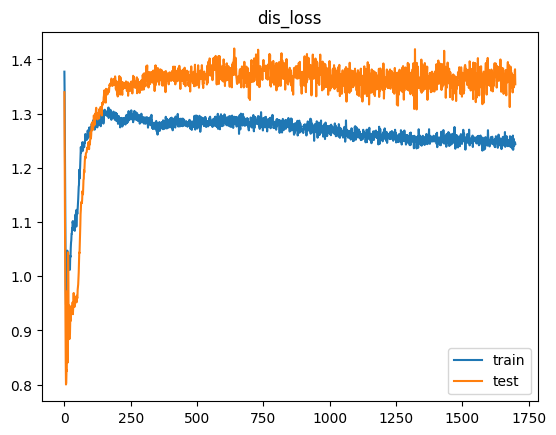

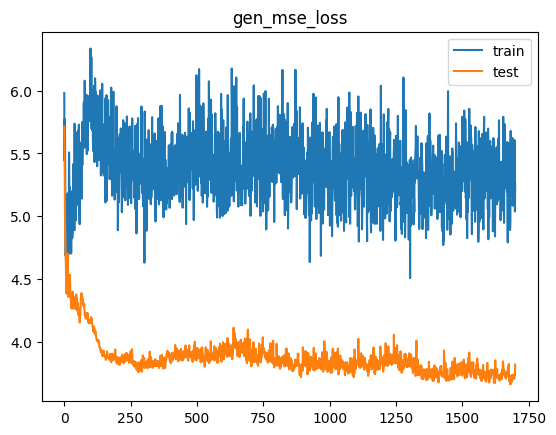

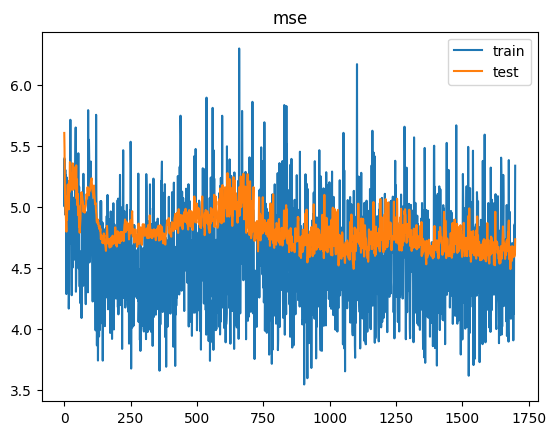

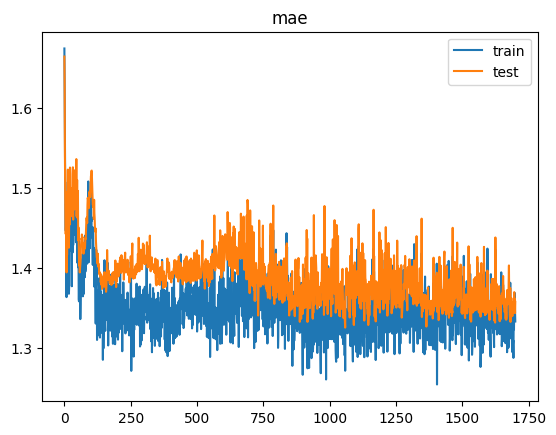

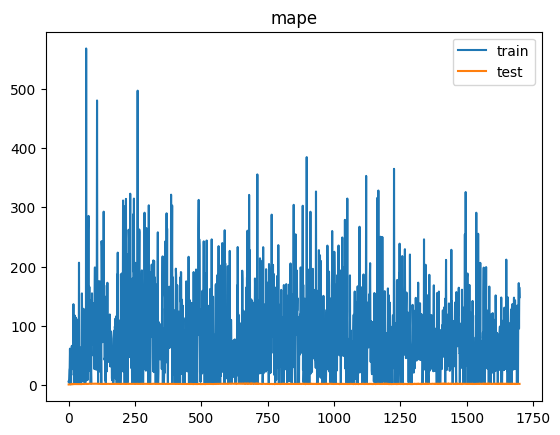

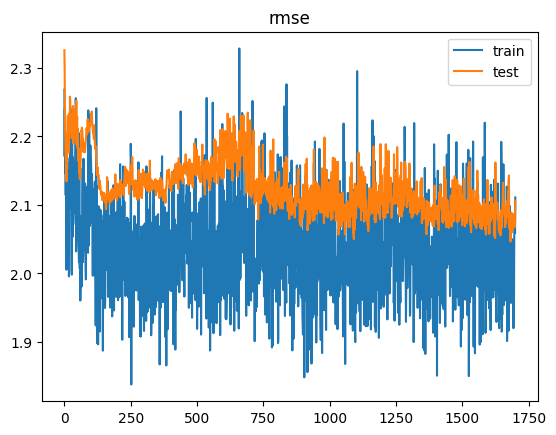

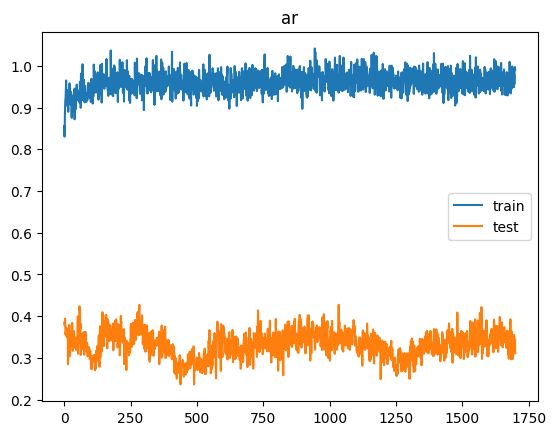

2/2 [==============================] - 0s 2ms/step


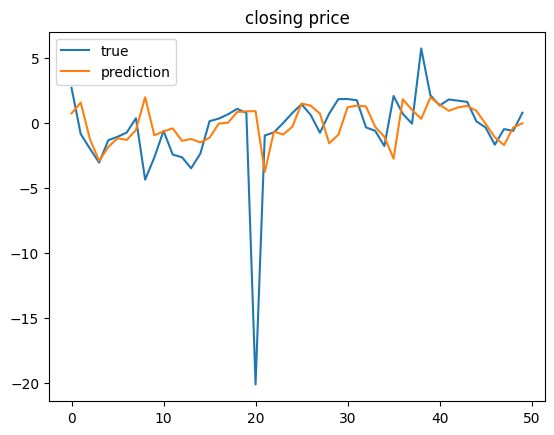

[MSE Baseline] train: 4.2983303944443  test: 4.679867713895856
Delta time with epochs = 1700: 0:19:17.040576
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 simple_rnn_3 (S

Time for epoch 53 is 0.6945297718048096 sec Generator Loss: 1.0824345350265503,  Discriminator_loss: 1.161578893661499
Time for epoch 54 is 0.7091758251190186 sec Generator Loss: 1.0778299570083618,  Discriminator_loss: 1.173927903175354
Time for epoch 55 is 0.6847062110900879 sec Generator Loss: 1.0649935007095337,  Discriminator_loss: 1.1815260648727417
Time for epoch 56 is 0.6985311508178711 sec Generator Loss: 1.0777546167373657,  Discriminator_loss: 1.166664958000183
Time for epoch 57 is 0.6597931385040283 sec Generator Loss: 1.068210244178772,  Discriminator_loss: 1.1793683767318726
Time for epoch 58 is 0.6646261215209961 sec Generator Loss: 1.059319257736206,  Discriminator_loss: 1.1960029602050781
Time for epoch 59 is 0.6843662261962891 sec Generator Loss: 1.0630791187286377,  Discriminator_loss: 1.1825264692306519
Time for epoch 60 is 0.6546790599822998 sec Generator Loss: 1.0443528890609741,  Discriminator_loss: 1.1936496496200562
Time for epoch 61 is 0.6706886291503906 sec G

Time for epoch 122 is 0.7428064346313477 sec Generator Loss: 0.9147570133209229,  Discriminator_loss: 1.2927765846252441
Time for epoch 123 is 0.7076380252838135 sec Generator Loss: 0.895976185798645,  Discriminator_loss: 1.2967259883880615
Time for epoch 124 is 0.6594939231872559 sec Generator Loss: 0.9162570238113403,  Discriminator_loss: 1.2707953453063965
Time for epoch 125 is 0.6664078235626221 sec Generator Loss: 0.9091854691505432,  Discriminator_loss: 1.28641676902771
Time for epoch 126 is 0.6540870666503906 sec Generator Loss: 0.9054093956947327,  Discriminator_loss: 1.2911454439163208
Time for epoch 127 is 0.6488616466522217 sec Generator Loss: 0.9015440940856934,  Discriminator_loss: 1.2919793128967285
Time for epoch 128 is 0.6496193408966064 sec Generator Loss: 0.9052242040634155,  Discriminator_loss: 1.2871195077896118
Time for epoch 129 is 0.6492602825164795 sec Generator Loss: 0.8944151401519775,  Discriminator_loss: 1.2897037267684937
Time for epoch 130 is 0.66228771209

Time for epoch 191 is 0.662421703338623 sec Generator Loss: 0.8690071105957031,  Discriminator_loss: 1.2977287769317627
Time for epoch 192 is 0.672332763671875 sec Generator Loss: 0.8739538788795471,  Discriminator_loss: 1.2921184301376343
Time for epoch 193 is 0.7044224739074707 sec Generator Loss: 0.872420608997345,  Discriminator_loss: 1.2954553365707397
Time for epoch 194 is 0.6980724334716797 sec Generator Loss: 0.8819943070411682,  Discriminator_loss: 1.2781004905700684
Time for epoch 195 is 0.69122314453125 sec Generator Loss: 0.8823508024215698,  Discriminator_loss: 1.2907377481460571
Time for epoch 196 is 0.7108960151672363 sec Generator Loss: 0.8773241639137268,  Discriminator_loss: 1.3000882863998413
Time for epoch 197 is 0.7530760765075684 sec Generator Loss: 0.8820133209228516,  Discriminator_loss: 1.2894173860549927
Time for epoch 198 is 0.6446125507354736 sec Generator Loss: 0.8741905093193054,  Discriminator_loss: 1.2974801063537598
Time for epoch 199 is 0.7111597061157

Time for epoch 259 is 0.7021975517272949 sec Generator Loss: 0.8755660057067871,  Discriminator_loss: 1.3042010068893433
Time for epoch 260 is 0.7062225341796875 sec Generator Loss: 0.8725505471229553,  Discriminator_loss: 1.2986540794372559
Time for epoch 261 is 0.6922104358673096 sec Generator Loss: 0.8875594139099121,  Discriminator_loss: 1.2868632078170776
Time for epoch 262 is 0.7046284675598145 sec Generator Loss: 0.8720138072967529,  Discriminator_loss: 1.3000065088272095
Time for epoch 263 is 0.6959831714630127 sec Generator Loss: 0.8866688013076782,  Discriminator_loss: 1.291346788406372
Time for epoch 264 is 0.6924116611480713 sec Generator Loss: 0.8836387395858765,  Discriminator_loss: 1.2980186939239502
Time for epoch 265 is 0.7588162422180176 sec Generator Loss: 0.8794538974761963,  Discriminator_loss: 1.2954721450805664
Time for epoch 266 is 0.7448911666870117 sec Generator Loss: 0.8883099555969238,  Discriminator_loss: 1.2969496250152588
Time for epoch 267 is 0.731860399

Time for epoch 327 is 0.6566436290740967 sec Generator Loss: 0.8753358125686646,  Discriminator_loss: 1.3113113641738892
Time for epoch 328 is 0.6478440761566162 sec Generator Loss: 0.8627923727035522,  Discriminator_loss: 1.3069043159484863
Time for epoch 329 is 0.6533379554748535 sec Generator Loss: 0.8690865635871887,  Discriminator_loss: 1.3017886877059937
Time for epoch 330 is 0.6550917625427246 sec Generator Loss: 0.8844590187072754,  Discriminator_loss: 1.2910377979278564
Time for epoch 331 is 0.661224365234375 sec Generator Loss: 0.8756551742553711,  Discriminator_loss: 1.304486870765686
Time for epoch 332 is 1.5122721195220947 sec Generator Loss: 0.8814362287521362,  Discriminator_loss: 1.2943339347839355
Time for epoch 333 is 0.6608757972717285 sec Generator Loss: 0.8683902621269226,  Discriminator_loss: 1.2943294048309326
Time for epoch 334 is 0.6619539260864258 sec Generator Loss: 0.8763099312782288,  Discriminator_loss: 1.3073139190673828
Time for epoch 335 is 0.6665940284

Time for epoch 395 is 0.6932826042175293 sec Generator Loss: 0.8771340250968933,  Discriminator_loss: 1.2960474491119385
Time for epoch 396 is 0.7069201469421387 sec Generator Loss: 0.8786278367042542,  Discriminator_loss: 1.3023488521575928
Time for epoch 397 is 0.6995351314544678 sec Generator Loss: 0.8880312442779541,  Discriminator_loss: 1.295882225036621
Time for epoch 398 is 0.704594612121582 sec Generator Loss: 0.8755591511726379,  Discriminator_loss: 1.3027395009994507
Time for epoch 399 is 0.7118909358978271 sec Generator Loss: 0.8862793445587158,  Discriminator_loss: 1.2973474264144897
Time for epoch 400 is 0.715611457824707 sec Generator Loss: 0.8907126784324646,  Discriminator_loss: 1.2958699464797974
Time for epoch 401 is 0.7045035362243652 sec Generator Loss: 0.882724940776825,  Discriminator_loss: 1.2962216138839722
Time for epoch 402 is 0.7036130428314209 sec Generator Loss: 0.8861026167869568,  Discriminator_loss: 1.2926822900772095
Time for epoch 403 is 0.700859785079

Time for epoch 463 is 0.7133259773254395 sec Generator Loss: 0.8946771025657654,  Discriminator_loss: 1.2924926280975342
Time for epoch 464 is 0.731818675994873 sec Generator Loss: 0.8933592438697815,  Discriminator_loss: 1.2872473001480103
Time for epoch 465 is 0.7139077186584473 sec Generator Loss: 0.8984690308570862,  Discriminator_loss: 1.2877899408340454
Time for epoch 466 is 0.6963784694671631 sec Generator Loss: 0.9064531326293945,  Discriminator_loss: 1.2858507633209229
Time for epoch 467 is 0.7089648246765137 sec Generator Loss: 0.9115867018699646,  Discriminator_loss: 1.2770951986312866
Time for epoch 468 is 0.7076539993286133 sec Generator Loss: 0.8923451900482178,  Discriminator_loss: 1.292526125907898
Time for epoch 469 is 0.6974353790283203 sec Generator Loss: 0.9047311544418335,  Discriminator_loss: 1.284698486328125
Time for epoch 470 is 0.7034680843353271 sec Generator Loss: 0.8934231996536255,  Discriminator_loss: 1.2870367765426636
Time for epoch 471 is 0.71656680107

Time for epoch 532 is 0.6504452228546143 sec Generator Loss: 0.9045450687408447,  Discriminator_loss: 1.284561038017273
Time for epoch 533 is 0.6572048664093018 sec Generator Loss: 0.9120097756385803,  Discriminator_loss: 1.2761547565460205
Time for epoch 534 is 0.685868501663208 sec Generator Loss: 0.8976545929908752,  Discriminator_loss: 1.2906949520111084
Time for epoch 535 is 0.6657075881958008 sec Generator Loss: 0.9036875367164612,  Discriminator_loss: 1.2840321063995361
Time for epoch 536 is 0.668536901473999 sec Generator Loss: 0.8997436165809631,  Discriminator_loss: 1.2849724292755127
Time for epoch 537 is 0.6524815559387207 sec Generator Loss: 0.9115833640098572,  Discriminator_loss: 1.2747795581817627
Time for epoch 538 is 0.6534664630889893 sec Generator Loss: 0.9103894233703613,  Discriminator_loss: 1.2685744762420654
Time for epoch 539 is 0.6550085544586182 sec Generator Loss: 0.8970574140548706,  Discriminator_loss: 1.2914320230484009
Time for epoch 540 is 0.65264821052

Time for epoch 601 is 0.6547675132751465 sec Generator Loss: 0.8991318345069885,  Discriminator_loss: 1.2869329452514648
Time for epoch 602 is 0.6678674221038818 sec Generator Loss: 0.910445511341095,  Discriminator_loss: 1.2664048671722412
Time for epoch 603 is 0.6548933982849121 sec Generator Loss: 0.9216732978820801,  Discriminator_loss: 1.2664430141448975
Time for epoch 604 is 0.6547279357910156 sec Generator Loss: 0.9200408458709717,  Discriminator_loss: 1.268897533416748
Time for epoch 605 is 0.6593451499938965 sec Generator Loss: 0.9150722026824951,  Discriminator_loss: 1.2767773866653442
Time for epoch 606 is 0.6608877182006836 sec Generator Loss: 0.9141213893890381,  Discriminator_loss: 1.273055076599121
Time for epoch 607 is 0.7071921825408936 sec Generator Loss: 0.910035252571106,  Discriminator_loss: 1.2808740139007568
Time for epoch 608 is 0.702272891998291 sec Generator Loss: 0.9214328527450562,  Discriminator_loss: 1.2661006450653076
Time for epoch 609 is 0.7276387214660

Time for epoch 669 is 0.7184028625488281 sec Generator Loss: 0.9139275550842285,  Discriminator_loss: 1.273861289024353
Time for epoch 670 is 0.7075052261352539 sec Generator Loss: 0.9058573246002197,  Discriminator_loss: 1.2716041803359985
Time for epoch 671 is 0.7133512496948242 sec Generator Loss: 0.9177233576774597,  Discriminator_loss: 1.2724244594573975
Time for epoch 672 is 0.7114765644073486 sec Generator Loss: 0.9191160202026367,  Discriminator_loss: 1.2778546810150146
Time for epoch 673 is 0.7452011108398438 sec Generator Loss: 0.911715567111969,  Discriminator_loss: 1.2747856378555298
Time for epoch 674 is 0.719956636428833 sec Generator Loss: 0.9219412207603455,  Discriminator_loss: 1.2636266946792603
Time for epoch 675 is 0.7202029228210449 sec Generator Loss: 0.9097865223884583,  Discriminator_loss: 1.2739508152008057
Time for epoch 676 is 0.737006664276123 sec Generator Loss: 0.9195618033409119,  Discriminator_loss: 1.2778195142745972
Time for epoch 677 is 0.715153455734

Time for epoch 737 is 0.8273026943206787 sec Generator Loss: 0.9288731813430786,  Discriminator_loss: 1.2629379034042358
Time for epoch 738 is 0.8285691738128662 sec Generator Loss: 0.9315319657325745,  Discriminator_loss: 1.2668229341506958
Time for epoch 739 is 0.7239458560943604 sec Generator Loss: 0.9132255911827087,  Discriminator_loss: 1.279044270515442
Time for epoch 740 is 0.8349342346191406 sec Generator Loss: 0.9382811188697815,  Discriminator_loss: 1.2620429992675781
Time for epoch 741 is 0.7189254760742188 sec Generator Loss: 0.9319167733192444,  Discriminator_loss: 1.2669926881790161
Time for epoch 742 is 0.6871461868286133 sec Generator Loss: 0.926501452922821,  Discriminator_loss: 1.2765846252441406
Time for epoch 743 is 0.677626371383667 sec Generator Loss: 0.9106928110122681,  Discriminator_loss: 1.2660342454910278
Time for epoch 744 is 0.7385644912719727 sec Generator Loss: 0.9205347299575806,  Discriminator_loss: 1.267347812652588
Time for epoch 745 is 0.721073865890

Time for epoch 805 is 0.7541928291320801 sec Generator Loss: 0.9239436388015747,  Discriminator_loss: 1.2786476612091064
Time for epoch 806 is 0.7408113479614258 sec Generator Loss: 0.9317268133163452,  Discriminator_loss: 1.2713918685913086
Time for epoch 807 is 0.7366776466369629 sec Generator Loss: 0.9288003444671631,  Discriminator_loss: 1.2599273920059204
Time for epoch 808 is 0.7259037494659424 sec Generator Loss: 0.9413095712661743,  Discriminator_loss: 1.2694885730743408
Time for epoch 809 is 0.7051610946655273 sec Generator Loss: 0.9299034476280212,  Discriminator_loss: 1.2651622295379639
Time for epoch 810 is 0.7302823066711426 sec Generator Loss: 0.9254466891288757,  Discriminator_loss: 1.269823670387268
Time for epoch 811 is 0.6782131195068359 sec Generator Loss: 0.9254313707351685,  Discriminator_loss: 1.2663583755493164
Time for epoch 812 is 0.7523584365844727 sec Generator Loss: 0.9433513879776001,  Discriminator_loss: 1.265142560005188
Time for epoch 813 is 0.6671502590

Time for epoch 874 is 0.731050968170166 sec Generator Loss: 0.9318150281906128,  Discriminator_loss: 1.2618061304092407
Time for epoch 875 is 0.7336456775665283 sec Generator Loss: 0.9178799390792847,  Discriminator_loss: 1.2795679569244385
Time for epoch 876 is 0.7103562355041504 sec Generator Loss: 0.9296537637710571,  Discriminator_loss: 1.2768174409866333
Time for epoch 877 is 0.7175025939941406 sec Generator Loss: 0.936764121055603,  Discriminator_loss: 1.2572840452194214
Time for epoch 878 is 0.7056052684783936 sec Generator Loss: 0.9207158088684082,  Discriminator_loss: 1.271026611328125
Time for epoch 879 is 0.6979031562805176 sec Generator Loss: 0.9379912614822388,  Discriminator_loss: 1.2689127922058105
Time for epoch 880 is 0.6844251155853271 sec Generator Loss: 0.9267392754554749,  Discriminator_loss: 1.2648836374282837
Time for epoch 881 is 0.6844861507415771 sec Generator Loss: 0.9298849701881409,  Discriminator_loss: 1.2684330940246582
Time for epoch 882 is 0.69490003585

Time for epoch 943 is 0.7828166484832764 sec Generator Loss: 0.94938725233078,  Discriminator_loss: 1.2679051160812378
Time for epoch 944 is 0.8045847415924072 sec Generator Loss: 0.9410237669944763,  Discriminator_loss: 1.2616995573043823
Time for epoch 945 is 0.8673489093780518 sec Generator Loss: 0.9378079175949097,  Discriminator_loss: 1.2577608823776245
Time for epoch 946 is 0.8869786262512207 sec Generator Loss: 0.9272810220718384,  Discriminator_loss: 1.270132064819336
Time for epoch 947 is 0.85719895362854 sec Generator Loss: 0.9427276849746704,  Discriminator_loss: 1.256440281867981
Time for epoch 948 is 0.77494215965271 sec Generator Loss: 0.9484520554542542,  Discriminator_loss: 1.2662309408187866
Time for epoch 949 is 0.7673373222351074 sec Generator Loss: 0.9356529116630554,  Discriminator_loss: 1.2803150415420532
Time for epoch 950 is 0.7525296211242676 sec Generator Loss: 0.9322407245635986,  Discriminator_loss: 1.2636226415634155
Time for epoch 951 is 0.7661499977111816

Time for epoch 1012 is 0.7536749839782715 sec Generator Loss: 0.938737154006958,  Discriminator_loss: 1.248386263847351
Time for epoch 1013 is 0.7603230476379395 sec Generator Loss: 0.9348441958427429,  Discriminator_loss: 1.2643986940383911
Time for epoch 1014 is 0.7609114646911621 sec Generator Loss: 0.9513698816299438,  Discriminator_loss: 1.2546296119689941
Time for epoch 1015 is 0.7630219459533691 sec Generator Loss: 0.9548535346984863,  Discriminator_loss: 1.2492692470550537
Time for epoch 1016 is 0.7325413227081299 sec Generator Loss: 0.9252845644950867,  Discriminator_loss: 1.2604446411132812
Time for epoch 1017 is 0.7184348106384277 sec Generator Loss: 0.9348722100257874,  Discriminator_loss: 1.2648786306381226
Time for epoch 1018 is 0.7131805419921875 sec Generator Loss: 0.9243674874305725,  Discriminator_loss: 1.2671113014221191
Time for epoch 1019 is 0.7025582790374756 sec Generator Loss: 0.940973699092865,  Discriminator_loss: 1.258192777633667
Time for epoch 1020 is 0.721

Time for epoch 1080 is 0.6848452091217041 sec Generator Loss: 0.9516401886940002,  Discriminator_loss: 1.2466230392456055
Time for epoch 1081 is 0.6761171817779541 sec Generator Loss: 0.9538739919662476,  Discriminator_loss: 1.2545527219772339
Time for epoch 1082 is 0.6738455295562744 sec Generator Loss: 0.9567998051643372,  Discriminator_loss: 1.2514243125915527
Time for epoch 1083 is 0.6627774238586426 sec Generator Loss: 0.9531079530715942,  Discriminator_loss: 1.2537846565246582
Time for epoch 1084 is 0.6900572776794434 sec Generator Loss: 0.9402782917022705,  Discriminator_loss: 1.2690608501434326
Time for epoch 1085 is 0.7091774940490723 sec Generator Loss: 0.9551939964294434,  Discriminator_loss: 1.2530834674835205
Time for epoch 1086 is 0.6759037971496582 sec Generator Loss: 0.937717616558075,  Discriminator_loss: 1.259534239768982
Time for epoch 1087 is 0.7009000778198242 sec Generator Loss: 0.953231692314148,  Discriminator_loss: 1.2512744665145874
Time for epoch 1088 is 0.66

Time for epoch 1148 is 0.7091526985168457 sec Generator Loss: 0.9507973194122314,  Discriminator_loss: 1.251125454902649
Time for epoch 1149 is 0.7180402278900146 sec Generator Loss: 0.9603337049484253,  Discriminator_loss: 1.242040991783142
Time for epoch 1150 is 0.7417490482330322 sec Generator Loss: 0.9470754861831665,  Discriminator_loss: 1.255676031112671
Time for epoch 1151 is 0.7192237377166748 sec Generator Loss: 0.9591580033302307,  Discriminator_loss: 1.2515814304351807
Time for epoch 1152 is 0.7264194488525391 sec Generator Loss: 0.9624842405319214,  Discriminator_loss: 1.2511861324310303
Time for epoch 1153 is 0.7060613632202148 sec Generator Loss: 0.9533477425575256,  Discriminator_loss: 1.251796007156372
Time for epoch 1154 is 0.7083187103271484 sec Generator Loss: 0.9548894166946411,  Discriminator_loss: 1.257039189338684
Time for epoch 1155 is 0.7081046104431152 sec Generator Loss: 0.9559243321418762,  Discriminator_loss: 1.253782868385315
Time for epoch 1156 is 0.72743

Time for epoch 1216 is 0.720304012298584 sec Generator Loss: 0.9506509900093079,  Discriminator_loss: 1.2523977756500244
Time for epoch 1217 is 0.7183408737182617 sec Generator Loss: 0.9522334933280945,  Discriminator_loss: 1.247450828552246
Time for epoch 1218 is 0.72794508934021 sec Generator Loss: 0.9534677863121033,  Discriminator_loss: 1.251429796218872
Time for epoch 1219 is 0.7179844379425049 sec Generator Loss: 0.9643243551254272,  Discriminator_loss: 1.2483083009719849
Time for epoch 1220 is 0.7223186492919922 sec Generator Loss: 0.9525309801101685,  Discriminator_loss: 1.2591415643692017
Time for epoch 1221 is 0.7295899391174316 sec Generator Loss: 0.954425036907196,  Discriminator_loss: 1.25278639793396
Time for epoch 1222 is 0.7711880207061768 sec Generator Loss: 0.9564109444618225,  Discriminator_loss: 1.2469052076339722
Time for epoch 1223 is 0.7513654232025146 sec Generator Loss: 0.9539543986320496,  Discriminator_loss: 1.2576946020126343
Time for epoch 1224 is 0.7282838

Time for epoch 1284 is 0.7224500179290771 sec Generator Loss: 0.9445332288742065,  Discriminator_loss: 1.266985535621643
Time for epoch 1285 is 0.7351846694946289 sec Generator Loss: 0.95746248960495,  Discriminator_loss: 1.2472487688064575
Time for epoch 1286 is 0.7027199268341064 sec Generator Loss: 0.9698336124420166,  Discriminator_loss: 1.2374471426010132
Time for epoch 1287 is 0.6966068744659424 sec Generator Loss: 0.9566443562507629,  Discriminator_loss: 1.248831868171692
Time for epoch 1288 is 0.6754105091094971 sec Generator Loss: 0.9520693421363831,  Discriminator_loss: 1.2502232789993286
Time for epoch 1289 is 0.6791832447052002 sec Generator Loss: 0.9498128890991211,  Discriminator_loss: 1.252015233039856
Time for epoch 1290 is 0.680497407913208 sec Generator Loss: 0.9591132998466492,  Discriminator_loss: 1.2531721591949463
Time for epoch 1291 is 0.6794576644897461 sec Generator Loss: 0.955234706401825,  Discriminator_loss: 1.2473371028900146
Time for epoch 1292 is 0.692236

Time for epoch 1352 is 0.7426345348358154 sec Generator Loss: 0.9654018878936768,  Discriminator_loss: 1.2403388023376465
Time for epoch 1353 is 0.7255237102508545 sec Generator Loss: 0.955941379070282,  Discriminator_loss: 1.238366961479187
Time for epoch 1354 is 0.7277963161468506 sec Generator Loss: 0.962695837020874,  Discriminator_loss: 1.2575170993804932
Time for epoch 1355 is 0.7175910472869873 sec Generator Loss: 0.9572470784187317,  Discriminator_loss: 1.246350884437561
Time for epoch 1356 is 0.7572112083435059 sec Generator Loss: 0.9634783864021301,  Discriminator_loss: 1.2429701089859009
Time for epoch 1357 is 0.7406797409057617 sec Generator Loss: 0.9610211253166199,  Discriminator_loss: 1.2545599937438965
Time for epoch 1358 is 0.7214784622192383 sec Generator Loss: 0.9572557210922241,  Discriminator_loss: 1.2533810138702393
Time for epoch 1359 is 0.7245147228240967 sec Generator Loss: 0.9614745378494263,  Discriminator_loss: 1.2475534677505493
Time for epoch 1360 is 0.726

Time for epoch 1420 is 0.7297537326812744 sec Generator Loss: 0.9577474594116211,  Discriminator_loss: 1.2523099184036255
Time for epoch 1421 is 0.7170619964599609 sec Generator Loss: 0.9488075971603394,  Discriminator_loss: 1.2571202516555786
Time for epoch 1422 is 0.7618739604949951 sec Generator Loss: 0.9504226446151733,  Discriminator_loss: 1.2508560419082642
Time for epoch 1423 is 0.7412300109863281 sec Generator Loss: 0.96982342004776,  Discriminator_loss: 1.2436304092407227
Time for epoch 1424 is 0.7204210758209229 sec Generator Loss: 0.9634261131286621,  Discriminator_loss: 1.2376463413238525
Time for epoch 1425 is 0.7383584976196289 sec Generator Loss: 0.9588684439659119,  Discriminator_loss: 1.2490413188934326
Time for epoch 1426 is 0.7414588928222656 sec Generator Loss: 0.9631908535957336,  Discriminator_loss: 1.2446545362472534
Time for epoch 1427 is 0.7659919261932373 sec Generator Loss: 0.9721593856811523,  Discriminator_loss: 1.2374237775802612
Time for epoch 1428 is 0.7

Time for epoch 1488 is 0.7281372547149658 sec Generator Loss: 0.949479341506958,  Discriminator_loss: 1.2676695585250854
Time for epoch 1489 is 0.7463934421539307 sec Generator Loss: 0.9612664580345154,  Discriminator_loss: 1.244317889213562
Time for epoch 1490 is 0.7306649684906006 sec Generator Loss: 0.9600279331207275,  Discriminator_loss: 1.2553759813308716
Time for epoch 1491 is 0.7273056507110596 sec Generator Loss: 0.9673240780830383,  Discriminator_loss: 1.237386703491211
Time for epoch 1492 is 0.7307753562927246 sec Generator Loss: 0.9847095608711243,  Discriminator_loss: 1.2270549535751343
Time for epoch 1493 is 0.7251169681549072 sec Generator Loss: 0.9778017997741699,  Discriminator_loss: 1.2360641956329346
Time for epoch 1494 is 0.6876578330993652 sec Generator Loss: 0.9743431806564331,  Discriminator_loss: 1.2446600198745728
Time for epoch 1495 is 0.682478666305542 sec Generator Loss: 0.9781826138496399,  Discriminator_loss: 1.2276155948638916
Time for epoch 1496 is 0.720

Time for epoch 1556 is 0.6872127056121826 sec Generator Loss: 0.9713819622993469,  Discriminator_loss: 1.2335150241851807
Time for epoch 1557 is 0.6798286437988281 sec Generator Loss: 0.9705770611763,  Discriminator_loss: 1.2433323860168457
Time for epoch 1558 is 0.6830835342407227 sec Generator Loss: 0.9628580212593079,  Discriminator_loss: 1.2392313480377197
Time for epoch 1559 is 0.688284158706665 sec Generator Loss: 0.9689534902572632,  Discriminator_loss: 1.2383818626403809
Time for epoch 1560 is 0.7080609798431396 sec Generator Loss: 0.9545260667800903,  Discriminator_loss: 1.2500303983688354
Time for epoch 1561 is 0.7291030883789062 sec Generator Loss: 0.9791539907455444,  Discriminator_loss: 1.2276228666305542
Time for epoch 1562 is 0.687063455581665 sec Generator Loss: 0.9619543552398682,  Discriminator_loss: 1.2436671257019043
Time for epoch 1563 is 0.7079224586486816 sec Generator Loss: 0.9623906016349792,  Discriminator_loss: 1.249955654144287
Time for epoch 1564 is 0.68855

Time for epoch 1624 is 0.6879386901855469 sec Generator Loss: 0.9834165573120117,  Discriminator_loss: 1.2289974689483643
Time for epoch 1625 is 0.6860678195953369 sec Generator Loss: 0.9619661569595337,  Discriminator_loss: 1.2526211738586426
Time for epoch 1626 is 0.6863789558410645 sec Generator Loss: 0.9669857621192932,  Discriminator_loss: 1.2341935634613037
Time for epoch 1627 is 0.7096943855285645 sec Generator Loss: 0.9854459166526794,  Discriminator_loss: 1.224790334701538
Time for epoch 1628 is 0.6918871402740479 sec Generator Loss: 0.980760931968689,  Discriminator_loss: 1.2395702600479126
Time for epoch 1629 is 0.6896243095397949 sec Generator Loss: 0.9631236791610718,  Discriminator_loss: 1.2403489351272583
Time for epoch 1630 is 0.6893754005432129 sec Generator Loss: 0.9689924716949463,  Discriminator_loss: 1.2499043941497803
Time for epoch 1631 is 0.6966145038604736 sec Generator Loss: 0.9867182970046997,  Discriminator_loss: 1.2352772951126099
Time for epoch 1632 is 0.6

Time for epoch 1692 is 0.8306608200073242 sec Generator Loss: 0.966844379901886,  Discriminator_loss: 1.2334591150283813
Time for epoch 1693 is 0.7507815361022949 sec Generator Loss: 0.9745833873748779,  Discriminator_loss: 1.245124101638794
Time for epoch 1694 is 0.7702422142028809 sec Generator Loss: 0.9792196750640869,  Discriminator_loss: 1.2355852127075195
Time for epoch 1695 is 0.7475647926330566 sec Generator Loss: 0.9804785251617432,  Discriminator_loss: 1.249045968055725
Time for epoch 1696 is 0.7605924606323242 sec Generator Loss: 0.9647278189659119,  Discriminator_loss: 1.2484030723571777
Time for epoch 1697 is 0.8379843235015869 sec Generator Loss: 0.9783966541290283,  Discriminator_loss: 1.233150601387024
Time for epoch 1698 is 0.8177649974822998 sec Generator Loss: 0.9753652215003967,  Discriminator_loss: 1.2341150045394897
Time for epoch 1699 is 0.7967674732208252 sec Generator Loss: 0.9668608903884888,  Discriminator_loss: 1.246273159980774
Time for epoch 1700 is 0.7862

Time for epoch 1760 is 0.7093355655670166 sec Generator Loss: 0.9805393218994141,  Discriminator_loss: 1.237840175628662
Time for epoch 1761 is 0.7032034397125244 sec Generator Loss: 0.9917332530021667,  Discriminator_loss: 1.239219069480896
Time for epoch 1762 is 0.6901295185089111 sec Generator Loss: 0.9872303605079651,  Discriminator_loss: 1.2264387607574463
Time for epoch 1763 is 0.6974427700042725 sec Generator Loss: 1.0047783851623535,  Discriminator_loss: 1.2248209714889526
Time for epoch 1764 is 0.7013664245605469 sec Generator Loss: 0.9913550615310669,  Discriminator_loss: 1.2295082807540894
Time for epoch 1765 is 0.6911613941192627 sec Generator Loss: 0.9700842499732971,  Discriminator_loss: 1.242616891860962
Time for epoch 1766 is 0.6884384155273438 sec Generator Loss: 0.989936113357544,  Discriminator_loss: 1.2459514141082764
Time for epoch 1767 is 0.7018532752990723 sec Generator Loss: 0.9753972887992859,  Discriminator_loss: 1.2395298480987549
Time for epoch 1768 is 0.746

Time for epoch 1828 is 0.6994326114654541 sec Generator Loss: 0.9898841977119446,  Discriminator_loss: 1.2241874933242798
Time for epoch 1829 is 0.6953878402709961 sec Generator Loss: 0.9784740805625916,  Discriminator_loss: 1.239456057548523
Time for epoch 1830 is 0.6895649433135986 sec Generator Loss: 0.9881211519241333,  Discriminator_loss: 1.2469477653503418
Time for epoch 1831 is 0.7063710689544678 sec Generator Loss: 0.9832006096839905,  Discriminator_loss: 1.2454047203063965
Time for epoch 1832 is 0.6875784397125244 sec Generator Loss: 0.9770486354827881,  Discriminator_loss: 1.2440829277038574
Time for epoch 1833 is 0.6920382976531982 sec Generator Loss: 0.994408130645752,  Discriminator_loss: 1.230280876159668
Time for epoch 1834 is 0.699099063873291 sec Generator Loss: 0.9788928031921387,  Discriminator_loss: 1.2402316331863403
Time for epoch 1835 is 0.6980795860290527 sec Generator Loss: 0.9712785482406616,  Discriminator_loss: 1.242234468460083
Time for epoch 1836 is 0.7072

Time for epoch 1896 is 0.7062118053436279 sec Generator Loss: 0.9855358004570007,  Discriminator_loss: 1.239801049232483
Time for epoch 1897 is 0.6937909126281738 sec Generator Loss: 0.9896908402442932,  Discriminator_loss: 1.228884220123291
Time for epoch 1898 is 0.7018475532531738 sec Generator Loss: 0.9864717721939087,  Discriminator_loss: 1.2317122220993042
Time for epoch 1899 is 0.6926548480987549 sec Generator Loss: 0.981086254119873,  Discriminator_loss: 1.2331794500350952
Time for epoch 1900 is 0.7179622650146484 sec Generator Loss: 0.9804189801216125,  Discriminator_loss: 1.247208833694458
Time for epoch 1901 is 0.6907429695129395 sec Generator Loss: 0.9771214127540588,  Discriminator_loss: 1.2402287721633911
Time for epoch 1902 is 0.7019405364990234 sec Generator Loss: 0.9769973754882812,  Discriminator_loss: 1.236623764038086
Time for epoch 1903 is 0.6955809593200684 sec Generator Loss: 0.9880985021591187,  Discriminator_loss: 1.2407296895980835
Time for epoch 1904 is 0.6945

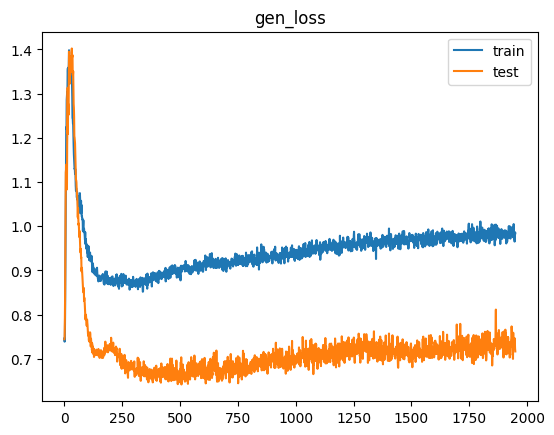

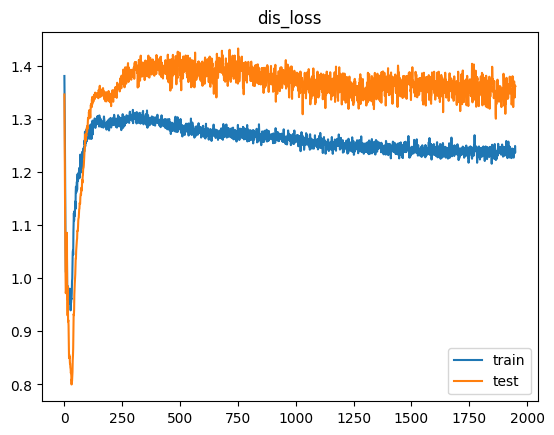

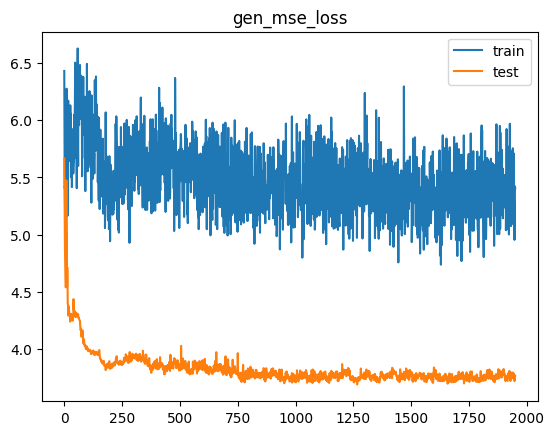

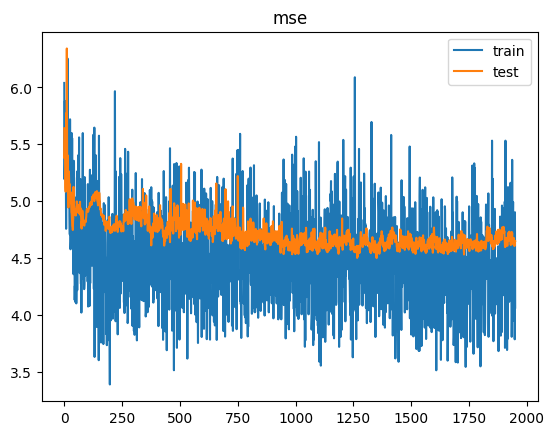

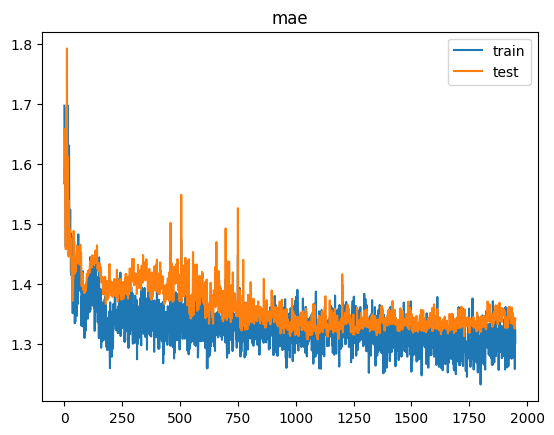

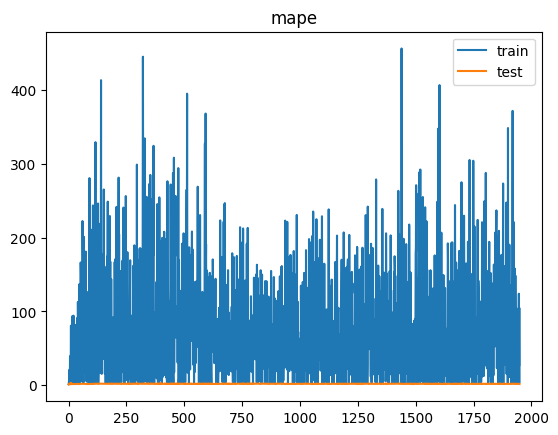

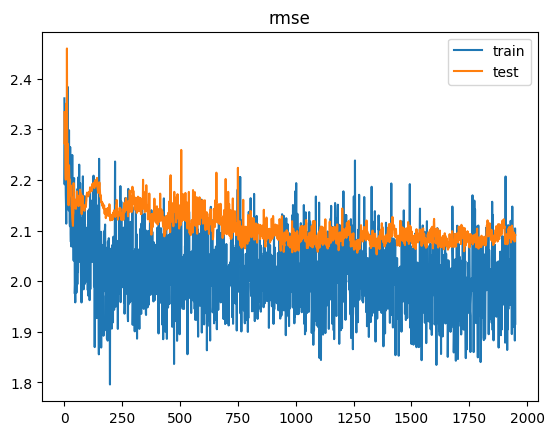

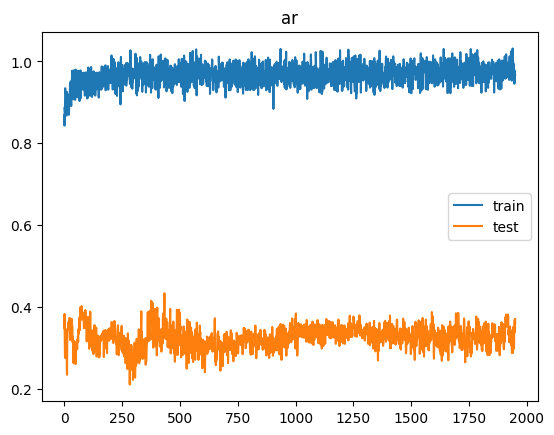

2/2 [==============================] - 0s 3ms/step


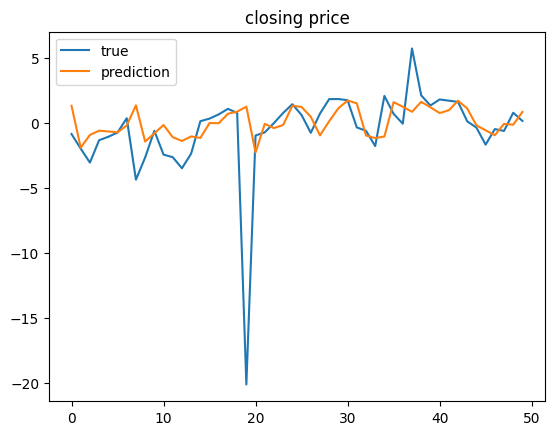

[MSE Baseline] train: 4.609959424213994  test: 4.6881765064049805
Delta time with epochs = 1950: 0:23:13.550889


In [20]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))